# IMPORTACIÓN LIBRERIAS


In [5]:
import numpy as np
import pandas as pd
from math import *
import math
import matplotlib.pyplot as plt
# from PIL import Image
import seaborn as sns
# import itertools
# import io 
# import plotly.offline as py
#py.init_notebook_mode(connect=True)
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
# import plotly.figure_factory as ff
import warnings
warnings.filterwarnings('ignore')
# CARGA DE ARCHIVOS

In [6]:
import os
import joblib


SEED = 42
np.random.seed(SEED)

# ML libs
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_score,
    brier_score_loss, confusion_matrix, f1_score, recall_score
)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# imbalanced
from imblearn.over_sampling import SMOTE

# LightGBM
import lightgbm as lgb

# SHAP
import shap

# CARGA DE ARCHIVOS

In [7]:
def load_dataset(file_path, file_type=None, separator=None, encoding='utf-8', **kwargs):
    """
    Loads a dataset in different formats, with support for custom separators, encoding, and more options.
    """
    # If the file type is not specified, infer from file extension
    if not file_type:
        file_type = file_path.split('.')[-1].lower()

    # Load according to the file type
    if file_type == 'csv':
        return pd.read_csv(file_path, sep=separator or ',', encoding=encoding, **kwargs)
    elif file_type in ['xls', 'xlsx']:
        return pd.read_excel(file_path, **kwargs)
    elif file_type == 'json':
        return pd.read_json(file_path, encoding=encoding, **kwargs)
    else:
        raise ValueError(f"File format '{file_type}' not supported. Use 'csv', 'excel', or 'json'.")

Cargamos el archivo final para acabar de prepararlo y empezar con el modelo


In [8]:
df = load_dataset('../data/dataframe_final_abonado.csv')
df

,IdPersona,Edad,Sexo_Mujer,Churn,AntiguedadAños,TipoUltimoAbono,Irregularidad_ActivoIrregular,Irregularidad_ActivoRegular,Irregularidad_BajaFinalIrregular,Irregularidad_BajaFinalRegular,...,DiaFav_lunes,DiaFav_martes,DiaFav_miércoles,DiaFav_sábado,DiaFav_viernes,EstFav_invierno,EstFav_otono,EstFav_primavera,EstFav_verano,TieneAccesos
0,334,82.0,False,0,69.81,AVET,True,False,False,False,...,False,True,False,False,False,False,True,False,False,True
1,452,85.0,False,0,69.00,AVET,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,642,77.0,False,0,67.54,AVET,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,849,85.0,False,0,67.12,CL04,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,891,78.0,False,0,66.70,AVET,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8180,116944,11.0,True,1,1.10,FA00,False,False,True,False,...,True,False,False,False,False,False,False,False,True,True
8181,116981,17.0,False,1,0.09,AM00,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
8182,116987,23.0,False,1,0.08,JO00,False,False,True,False,...,False,False,True,False,False,False,False,False,True,True
8183,116996,17.0,False,1,1.00,AM00,False,False,True,False,...,False,False,False,False,True,False,False,False,True,True


## DEA

In [9]:
sns.set(style='whitegrid', context='notebook')

# Ajustes
ID_COL = 'IdPersona'
TARGET = 'Churn'
RANDOM_STATE = 42
plt.rcParams['figure.figsize'] = (10,5)

In [10]:
# Utilizamos esta linea de codigo para poder ver todas las columnas del dataframe
pd.set_option('display.max_columns', None)

In [11]:
print("Shape:", df.shape)

Shape: (8185, 168)


In [12]:
display(df.info(verbose=True, show_counts=True))  # muestra tipos y NA

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8185 entries, 0 to 8184
Data columns (total 168 columns):
 #    Column                                              Non-Null Count  Dtype  
---   ------                                              --------------  -----  
 0    IdPersona                                           8185 non-null   int64  
 1    Edad                                                8185 non-null   float64
 2    Sexo_Mujer                                          8185 non-null   bool   
 3    Churn                                               8185 non-null   int64  
 4    AntiguedadAños                                      8185 non-null   float64
 5    TipoUltimoAbono                                     8185 non-null   object 
 6    Irregularidad_ActivoIrregular                       8185 non-null   bool   
 7    Irregularidad_ActivoRegular                         8185 non-null   bool   
 8    Irregularidad_BajaFinalIrregular                    8185 non-null 

None

In [13]:
display(df)


,IdPersona,Edad,Sexo_Mujer,Churn,AntiguedadAños,TipoUltimoAbono,Irregularidad_ActivoIrregular,Irregularidad_ActivoRegular,Irregularidad_BajaFinalIrregular,Irregularidad_BajaFinalRegular,MesesDesdeUltimoAbono,Importe_2024_servicios,Cantidad_2024_servicios,Importe_2025_servicios,Cantidad_2025_servicios,Importe_total_pagado_servicios,Cantidad_total_pagado_servicios,Concepto_ENTRENADOR PERSONAL 1 /2 SESSIO ABONAT,Concepto_ENTRENADOR PERSONAL 1 SESSIO,Concepto_ENTRENADOR PERSONAL 1 SESSIÓ ABONAT,Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS),Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS) ABONAT,Concepto_ENTRENADOR PERSONAL 10 SESSIONS ABONAT,Concepto_ENTRENADOR PERSONAL 5 (30 MINUTS) ABONAT,Concepto_ENTRENADOR PERSONAL 5 SESSIONS ABONAT,Concepto_FISIO ABONAMENT 10 SESSIONS 60' ABONAT,Concepto_FISIO ABONAMENT 5 SESSIONS 30' ABONAT,Concepto_FISIO ABONAMENT 5 SESSIONS 60',Concepto_FISIO PACK BENVINGUDA,Concepto_FISIOTERÀPIA 60' ABONAT,Concepto_FISIOTERÀPIA 30' ABONAT,Concepto_NUTRI ANTROPOMETRIA,Concepto_NUTRI ANTROPOMETRIA ABONAT,Concepto_NUTRI PACK 3 SEGUIMENTS ABONAT,Concepto_NUTRI VISITA DE SEGUIMENT ABONAT,Concepto_PACK 3 SEGUIMENTS ABONAT,Concepto_PACK NUTRICIÓ (2 VISITES) ABONAT,TipoServicio_ENTRENAMENTS PERSONALS,TipoServicio_FISIOTERÀPIA,TipoServicio_NUTRICIÓ,Total_conceptos_unicos,Total_tipos_servicios_unicos,UsoServiciosExtra,NumRenovaciones,NumTiposAbono,TotalPagado,MediaPagada,TotalMetálico,TotalRecibo,TotalTarjeta,TotalTransferencia,CambioAbono,RatioMesesPagados,CefVarImporte,MesesDesdeUltimoPago,MesesDesdePrimerPago,DuracionRenovacionMeses,FormaPagoMayoritaria,TipoAbonoInicial,TipoAbonoFinal,TotalAbono_AA0,TotalAbono_AA00,TotalAbono_AA03,TotalAbono_AA12,TotalAbono_AC00,TotalAbono_AC03,TotalAbono_AF00,TotalAbono_AF03,TotalAbono_AG00,TotalAbono_AG03,TotalAbono_AG12,TotalAbono_AM00,TotalAbono_AM03,TotalAbono_AP00,TotalAbono_AP03,TotalAbono_AR00,TotalAbono_AR03,TotalAbono_AR12,TotalAbono_AT00,TotalAbono_AT01,TotalAbono_AVET,TotalAbono_CL04,TotalAbono_CR01,TotalAbono_CR03,TotalAbono_EMPF,TotalAbono_FA00,TotalAbono_FA12,TotalAbono_FM01,TotalAbono_JO00,TotalAbono_JO03,TotalAbono_MA00,TotalAbono_MA03,TotalAbono_MA06,TotalAbono_MA12,TotalAbono_NI00,TotalAbono_QM01,TotalAbono_QM03,TotalAbono_TEMP,TotalAbono_VIP,TipoAbonoFrecuente,NumCambiosAbono,TendenciaPago,TendenciaPagoMismoAbono,NumImpagosReales,NumReactivaciones,TienePagos,PagoSinSaltos_irregular,PagoSinSaltos_no_aplica,PagoSinSaltos_regular,TotalVisitas,DiasActivo,VisitasPorSemana,VisitasPorMes,MaxVisitasDia,VarVisitasMes,DuracionMediaTotal,DuracionStdTotal,DuracionMediaUlt90,DeltaDuracionUlt90VsTotal,PropVisitasLargas,VisitasUlt30,VisitasUlt90,VisitasUlt180,PropUlt90,DiasDesdeUltima,DiasHastaPrimera,StdDiasEntreVisitas,FrecuenciaModal,SemanasConVisita,SemanasTotales,SemanasConUnaVisita,MaxRachaSinVisita,MaxRachaConVisita,HoraMediaAcceso,HoraStdAcceso,VarDiasSemana,PropFindesemana,PropPrimavera,PropVerano,PropOtono,PropInvierno,VisitasFestivos,PropVisitasFestivos,VisitasFindesemana,PropVisitasFindesemana,VisitasCerrado,PropVisitasCerrado,VisitasRed9a14,PropVisitasRed9a14,VisitasRed7a20,PropVisitasRed7a20,VisitasRed7a15,PropVisitasRed7a15,TiempoActivoDias,VisitasPrimerTrimestre,VisitasUltimoTrimestre,DiaFav_domingo,DiaFav_jueves,DiaFav_lunes,DiaFav_martes,DiaFav_miércoles,DiaFav_sábado,DiaFav_viernes,EstFav_invierno,EstFav_otono,EstFav_primavera,EstFav_verano,TieneAccesos
0,334,82.0,False,0,69.81,AVET,True,False,False,False,175.9,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,False,2.0,1.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.166667,0.0,1.0,7.0,5.946124,Metálico,AVET,AVET,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AVET,0.0,0.0,0.0,1.0,0.0,True,True,False,False,3.0,3.0,1.500000,2.432432,1.0,0.00,50.422222,8.675597,50.422222,0.0,0.333333,3.0,3.0,3.0,1.0,383.0,

In [14]:
# Forma 1: con astype
df["Churn"] = df["Churn"].astype(bool)

# Forma 2: usando comparación explícita
df["Churn"] = df["Churn"] == 1

In [15]:
df["ratio_importe_2025_2024"] = df["Importe_2025_servicios"] / (df["Importe_2024_servicios"] + 1)
df["ratio_cantidad_2025_2024"] = df["Cantidad_2025_servicios"] / (df["Cantidad_2024_servicios"] + 1)

In [16]:
# 🔹 Crear variables resumen como True/False
df["Uso_entrenamientos_personales"] = (
    df.filter(regex="ENTRENADOR PERSONAL|ENTRENAMENTS PERSONALS").sum(axis=1) > 0
)

df["Uso_fisioterapia"] = (
    df.filter(regex="FISIO|FISIOTERÀPIA").sum(axis=1) > 0
)

df["Uso_nutricion"] = (
    df.filter(regex="NUTRI").sum(axis=1) > 0
)

# 🔹 Diversidad de servicios extra (suma de True/False sigue funcionando)
df["Diversidad_servicios_extra"] = (
    df[["Uso_entrenamientos_personales", "Uso_fisioterapia", "Uso_nutricion"]].sum(axis=1)
)

In [24]:
list(df.columns)

['IdPersona',
 'Edad',
 'Sexo_Mujer',
 'Churn',
 'AntiguedadAños',
 'TipoUltimoAbono',
 'Irregularidad_ActivoIrregular',
 'Irregularidad_ActivoRegular',
 'Irregularidad_BajaFinalIrregular',
 'Irregularidad_BajaFinalRegular',
 'MesesDesdeUltimoAbono',
 'Importe_2024_servicios',
 'Cantidad_2024_servicios',
 'Importe_2025_servicios',
 'Cantidad_2025_servicios',
 'Importe_total_pagado_servicios',
 'Cantidad_total_pagado_servicios',
 'Concepto_ENTRENADOR PERSONAL 1 /2 SESSIO ABONAT',
 'Concepto_ENTRENADOR PERSONAL 1 SESSIO',
 'Concepto_ENTRENADOR PERSONAL 1 SESSIÓ ABONAT',
 'Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS)',
 'Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS) ABONAT',
 'Concepto_ENTRENADOR PERSONAL 10 SESSIONS ABONAT',
 'Concepto_ENTRENADOR PERSONAL 5 (30 MINUTS) ABONAT',
 'Concepto_ENTRENADOR PERSONAL 5 SESSIONS ABONAT',
 "Concepto_FISIO ABONAMENT 10 SESSIONS 60' ABONAT",
 "Concepto_FISIO ABONAMENT 5 SESSIONS  30' ABONAT",
 "Concepto_FISIO ABONAMENT 5 SESSIONS  60'  ",
 'Concepto_FIS

In [17]:
df_encoded = pd.get_dummies(df, drop_first=True)
corr_matrix = df_encoded.iloc[:, 12:38].corr()

In [18]:
corr_matrix

,Importe_2025_servicios,Cantidad_2025_servicios,Importe_total_pagado_servicios,Cantidad_total_pagado_servicios,Concepto_ENTRENADOR PERSONAL 1 /2 SESSIO ABONAT,Concepto_ENTRENADOR PERSONAL 1 SESSIO,Concepto_ENTRENADOR PERSONAL 1 SESSIÓ ABONAT,Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS),Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS) ABONAT,Concepto_ENTRENADOR PERSONAL 10 SESSIONS ABONAT,Concepto_ENTRENADOR PERSONAL 5 (30 MINUTS) ABONAT,Concepto_ENTRENADOR PERSONAL 5 SESSIONS ABONAT,Concepto_FISIO ABONAMENT 10 SESSIONS 60' ABONAT,Concepto_FISIO ABONAMENT 5 SESSIONS 30' ABONAT,Concepto_FISIO ABONAMENT 5 SESSIONS 60',Concepto_FISIO PACK BENVINGUDA,Concepto_FISIOTERÀPIA 60' ABONAT,Concepto_FISIOTERÀPIA 30' ABONAT,Concepto_NUTRI ANTROPOMETRIA,Concepto_NUTRI ANTROPOMETRIA ABONAT,Concepto_NUTRI PACK 3 SEGUIMENTS ABONAT,Concepto_NUTRI VISITA DE SEGUIMENT ABONAT,Concepto_PACK 3 SEGUIMENTS ABONAT,Concepto_PACK NUTRICIÓ (2 VISITES) ABONAT,TipoServicio_ENTRENAMENTS PERSONALS,TipoServicio_FISIOTERÀPIA
Importe_2025_servicios,1.000000,0.772754,0.909704,0.819574,0.056257,0.136776,0.123533,NaN,0.473896,0.783928,0.152143,0.679586,0.557671,0.129434,NaN,0.337406,0.031945,0.055380,NaN,0.164548,-0.000620,0.263823,-0.000439,0.205781,0.824499,0.364762
Cantidad_2025_servicios,0.772754,1.000000,0.647085,0.866090,0.289587,0.301354,0.347697,NaN,0.313879,0.403913,0.283876,0.426205,0.401990,0.200718,NaN,0.426205,0.099547,0.286323,NaN,0.115260,-0.000783,0.100082,-0.000553,0.226840,0.745994,0.563194
Importe_total_pagado_servicios,0.909704,0.647085,1.000000,0.862598,0.030996,0.075795,0.068344,NaN,0.420260,0.817340,0.084270,0.687884,0.748973,0.071719,NaN,0.187118,0.035317,0.034797,NaN,0.266828,0.037219,0.417947,0.020325,0.237600,0.763210,0.331970
Cantidad_total_pagado_servicios,0.819574,0.866090,0.862598,1.000000,0.204999,0.213468,0.246195,NaN,0.413618,0.605103,0.201005,0.503714,0.570193,0.142123,NaN,0.301908,0.141583,0.231695,NaN,0.369783,0.150553,0.427503,0.070778,0.349185,0.793385,0.532200
Concepto_ENTRENADOR PERSONAL 1 /2 SESSIO ABONAT,0.056257,0.289587,0.030996,0.204999,1.000000,-0.000212,-0.000367,NaN,-0.000473,-0.000473,-0.000299,-0.000299,-0.000212,-0.000212,NaN,-0.000299,-0.000423,-0.000519,NaN,-0.000367,-0.000299,-0.000212,-0.000212,-0.000560,0.321166,-0.000793
Concepto_ENTRENADOR PERSONAL 1 SESSIO,0.136776,0.301354,0.075795,0.213468,-0.000212,1.000000,-0.000212,NaN,-0.000273,-0.000273,0.707064,-0.000173,-0.000122,-0.000122,NaN,-0.000173,-0.000244,-0.000299,NaN,-0.000212,-0.000173,-0.000122,-0.000122,-0.000323,0.371282,-0.000458
Concepto_ENTRENADOR PERSONAL 1 SESSIÓ ABONAT,0.123533,0.347697,0.068344,0.246195,-0.000367,-0.000212,1.000000,NaN,-0.000473,-0.000473,-0.000299,-0.000299,-0.000212,-0.000212,NaN,0.408074,-0.000423,-0.000519,NaN,-0.000367,-0.000299,-0.000212,-0.000212,-0.000560,0.321166,0.153671
Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS) ABONAT,0.473896,0.313879,0.420260,0.413618,-0.000473,-0.000273,-0.000473,NaN,1.000000,0.199511,-0.000387,-0.000387,-0.000273,-0.000273,NaN,0.315977,-0.000547,-0.000670,NaN,0.257852,-0.000387,0.447104,-0.000273,0.168432,0.497822,0.118638
Concepto_ENTRENADOR PERSONAL 10 SESSIONS ABONAT,0.783928,0.403913,0.817340,0.605103,-0.000473,-0.000273,-0.000473,NaN,0.199511,1.000000,-0.000387,0.632340,0.447104,-0.000273,NaN,-0.000387,-0.000547,-0.000670,NaN,0.257852,-0.000387,0.447104,-0.000273,0.168432,0.664118,0.118638


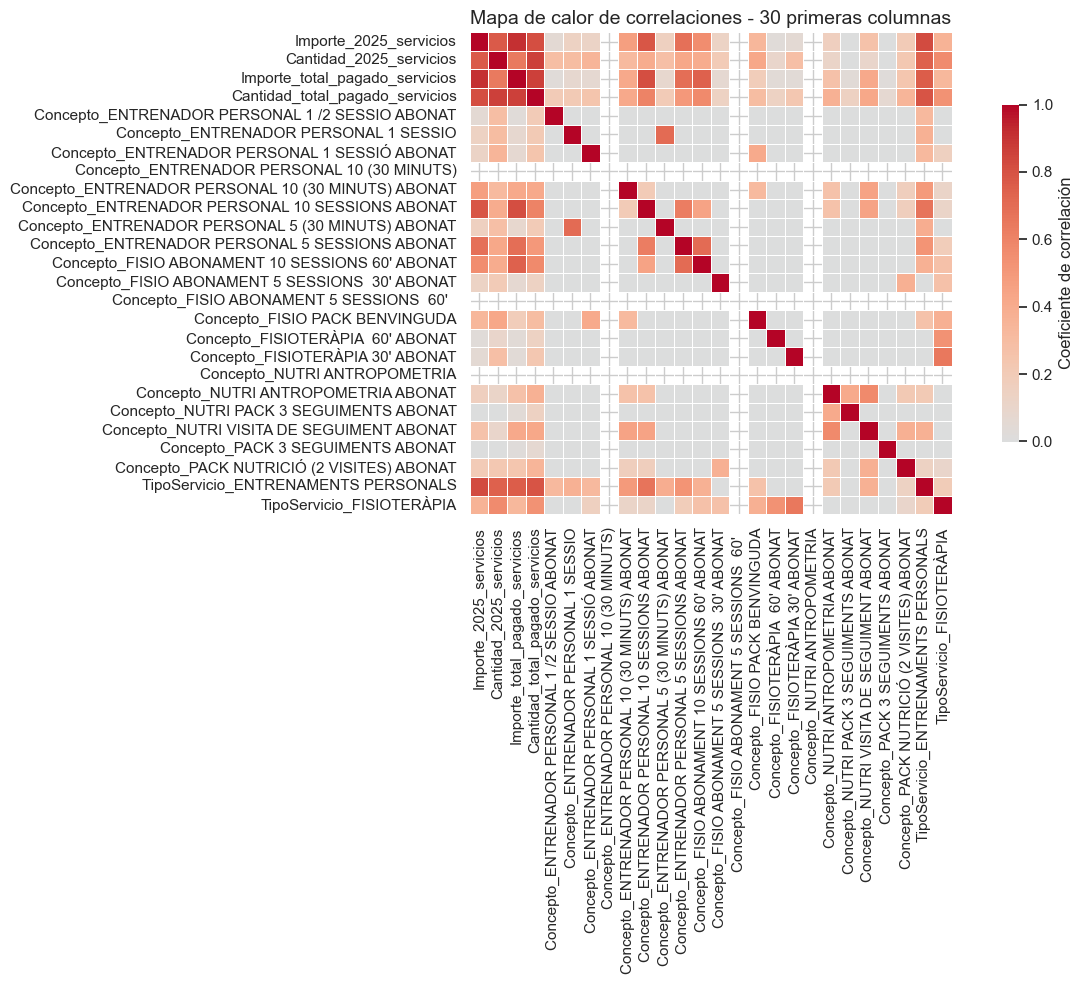

In [19]:
# Calcular la matriz de correlación solo para las 30 primeras columnas


# Crear el heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',       # Colores rojo-azul según el signo de la correlación
    center=0,              # El valor central (0) estará en el color neutro
    annot=False,           # Si quieres mostrar los valores numéricos: True
    linewidths=0.5,        # Líneas entre celdas
    square=True,           # Mantiene las celdas cuadradas
    cbar_kws={'shrink': .7, 'label': 'Coeficiente de correlación'}  # Barra lateral
)

plt.title("Mapa de calor de correlaciones - 30 primeras columnas", fontsize=14)
plt.tight_layout()
plt.show()

In [20]:



df= df.drop(columns= [ 'Importe_2024_servicios', 'Cantidad_2024_servicios', 'Importe_2025_servicios', 'Cantidad_2025_servicios','Concepto_ENTRENADOR PERSONAL 1 /2 SESSIO ABONAT',
    'Concepto_ENTRENADOR PERSONAL 1 SESSIO',
    'Concepto_ENTRENADOR PERSONAL 1 SESSIÓ ABONAT',
    'Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS)',
    'Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS) ABONAT',
    'Concepto_ENTRENADOR PERSONAL 10 SESSIONS ABONAT',
    'Concepto_ENTRENADOR PERSONAL 5 (30 MINUTS) ABONAT',
    'Concepto_ENTRENADOR PERSONAL 5 SESSIONS ABONAT',
    "Concepto_FISIO ABONAMENT 10 SESSIONS 60' ABONAT",
    "Concepto_FISIO ABONAMENT 5 SESSIONS  30' ABONAT",
    "Concepto_FISIO ABONAMENT 5 SESSIONS  60'  ",
    'Concepto_FISIO PACK BENVINGUDA',
    "Concepto_FISIOTERÀPIA  60' ABONAT",
    "Concepto_FISIOTERÀPIA 30' ABONAT",
    'Concepto_NUTRI ANTROPOMETRIA',
    'Concepto_NUTRI ANTROPOMETRIA ABONAT',
    'Concepto_NUTRI PACK 3 SEGUIMENTS ABONAT',
    'Concepto_NUTRI VISITA DE SEGUIMENT ABONAT',
    'Concepto_PACK 3 SEGUIMENTS ABONAT',
    'Concepto_PACK NUTRICIÓ (2 VISITES) ABONAT','Total_tipos_servicios_unicos', 'Total_conceptos_unicos'])


In [21]:
df

,IdPersona,Edad,Sexo_Mujer,Churn,AntiguedadAños,TipoUltimoAbono,Irregularidad_ActivoIrregular,Irregularidad_ActivoRegular,Irregularidad_BajaFinalIrregular,Irregularidad_BajaFinalRegular,MesesDesdeUltimoAbono,Importe_total_pagado_servicios,Cantidad_total_pagado_servicios,TipoServicio_ENTRENAMENTS PERSONALS,TipoServicio_FISIOTERÀPIA,TipoServicio_NUTRICIÓ,UsoServiciosExtra,NumRenovaciones,NumTiposAbono,TotalPagado,MediaPagada,TotalMetálico,TotalRecibo,TotalTarjeta,TotalTransferencia,CambioAbono,RatioMesesPagados,CefVarImporte,MesesDesdeUltimoPago,MesesDesdePrimerPago,DuracionRenovacionMeses,FormaPagoMayoritaria,TipoAbonoInicial,TipoAbonoFinal,TotalAbono_AA0,TotalAbono_AA00,TotalAbono_AA03,TotalAbono_AA12,TotalAbono_AC00,TotalAbono_AC03,TotalAbono_AF00,TotalAbono_AF03,TotalAbono_AG00,TotalAbono_AG03,TotalAbono_AG12,TotalAbono_AM00,TotalAbono_AM03,TotalAbono_AP00,TotalAbono_AP03,TotalAbono_AR00,TotalAbono_AR03,TotalAbono_AR12,TotalAbono_AT00,TotalAbono_AT01,TotalAbono_AVET,TotalAbono_CL04,TotalAbono_CR01,TotalAbono_CR03,TotalAbono_EMPF,TotalAbono_FA00,TotalAbono_FA12,TotalAbono_FM01,TotalAbono_JO00,TotalAbono_JO03,TotalAbono_MA00,TotalAbono_MA03,TotalAbono_MA06,TotalAbono_MA12,TotalAbono_NI00,TotalAbono_QM01,TotalAbono_QM03,TotalAbono_TEMP,TotalAbono_VIP,TipoAbonoFrecuente,NumCambiosAbono,TendenciaPago,TendenciaPagoMismoAbono,NumImpagosReales,NumReactivaciones,TienePagos,PagoSinSaltos_irregular,PagoSinSaltos_no_aplica,PagoSinSaltos_regular,TotalVisitas,DiasActivo,VisitasPorSemana,VisitasPorMes,MaxVisitasDia,VarVisitasMes,DuracionMediaTotal,DuracionStdTotal,DuracionMediaUlt90,DeltaDuracionUlt90VsTotal,PropVisitasLargas,VisitasUlt30,VisitasUlt90,VisitasUlt180,PropUlt90,DiasDesdeUltima,DiasHastaPrimera,StdDiasEntreVisitas,FrecuenciaModal,SemanasConVisita,SemanasTotales,SemanasConUnaVisita,MaxRachaSinVisita,MaxRachaConVisita,HoraMediaAcceso,HoraStdAcceso,VarDiasSemana,PropFindesemana,PropPrimavera,PropVerano,PropOtono,PropInvierno,VisitasFestivos,PropVisitasFestivos,VisitasFindesemana,PropVisitasFindesemana,VisitasCerrado,PropVisitasCerrado,VisitasRed9a14,PropVisitasRed9a14,VisitasRed7a20,PropVisitasRed7a20,VisitasRed7a15,PropVisitasRed7a15,TiempoActivoDias,VisitasPrimerTrimestre,VisitasUltimoTrimestre,DiaFav_domingo,DiaFav_jueves,DiaFav_lunes,DiaFav_martes,DiaFav_miércoles,DiaFav_sábado,DiaFav_viernes,EstFav_invierno,EstFav_otono,EstFav_primavera,EstFav_verano,TieneAccesos,ratio_importe_2025_2024,ratio_cantidad_2025_2024,Uso_entrenamientos_personales,Uso_fisioterapia,Uso_nutricion,Diversidad_servicios_extra
0,334,82.0,False,False,69.81,AVET,True,False,False,False,175.9,0.0,0.0,0.0,0.0,0.0,False,2.0,1.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.166667,0.0,1.0,7.0,5.946124,Metálico,AVET,AVET,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AVET,0.0,0.0,0.0,1.0,0.0,True,True,False,False,3.0,3.0,1.500000,2.432432,1.0,0.00,50.422222,8.675597,50.422222,0.0,0.333333,3.0,3.0,3.0,1.0,383.0,9.0,1.500000,2.0,2.0,2.0,1.0,5.0,1.0,11.144444,0.452224,0.530612,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,3.0,3.0,False,False,False,True,False,False,False,False,True,False,False,True,0.0,0.0,False,False,False,0
1,452,85.0,False,False,69.00,AVET,False,True,False,False,839.5,0.0,0.0,0.0,0.0,0.0,False,2.0,1.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.166667,0.0,1.0,7.0,5.946124,Metálico,AVET,AVET,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AVET,0.0,0.0,0.0,1.0,0.0,True,True,False,False,0.0,0.0,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,False,False,F

In [22]:
list(df.columns)

['IdPersona',
 'Edad',
 'Sexo_Mujer',
 'Churn',
 'AntiguedadAños',
 'TipoUltimoAbono',
 'Irregularidad_ActivoIrregular',
 'Irregularidad_ActivoRegular',
 'Irregularidad_BajaFinalIrregular',
 'Irregularidad_BajaFinalRegular',
 'MesesDesdeUltimoAbono',
 'Importe_total_pagado_servicios',
 'Cantidad_total_pagado_servicios',
 'TipoServicio_ENTRENAMENTS PERSONALS',
 'TipoServicio_FISIOTERÀPIA',
 'TipoServicio_NUTRICIÓ',
 'UsoServiciosExtra',
 'NumRenovaciones',
 'NumTiposAbono',
 'TotalPagado',
 'MediaPagada',
 'TotalMetálico',
 'TotalRecibo',
 'TotalTarjeta',
 'TotalTransferencia',
 'CambioAbono',
 'RatioMesesPagados',
 'CefVarImporte',
 'MesesDesdeUltimoPago',
 'MesesDesdePrimerPago',
 'DuracionRenovacionMeses',
 'FormaPagoMayoritaria',
 'TipoAbonoInicial',
 'TipoAbonoFinal',
 'TotalAbono_AA0',
 'TotalAbono_AA00',
 'TotalAbono_AA03',
 'TotalAbono_AA12',
 'TotalAbono_AC00',
 'TotalAbono_AC03',
 'TotalAbono_AF00',
 'TotalAbono_AF03',
 'TotalAbono_AG00',
 'TotalAbono_AG03',
 'TotalAbono_AG12'

In [23]:
# Resumen numérico básico
display(df.describe(include='number').T)

# Resumen categórico básico
display(df.describe(include=['object','category','bool']).T)

,count,mean,std,min,25%,50%,75%,max
IdPersona,8185.0,99772.362370,25475.123243,334.0,98023.00,108742.00,114378.0,117538.00
Edad,8185.0,41.622236,20.090782,0.0,25.00,41.00,55.0,225.00
AntiguedadAños,8185.0,3.357850,6.781625,0.0,0.38,1.14,3.0,69.81
MesesDesdeUltimoAbono,8185.0,22.827721,40.806640,0.0,2.80,8.20,24.0,839.50
Importe_total_pagado_servicios,8185.0,0.930794,27.123442,0.0,0.00,0.00,0.0,1838.60
...,...,...,...,...,...,...,...,...
VisitasPrimerTrimestre,8185.0,9.208797,11.248765,0.0,1.00,5.00,13.0,137.00
VisitasUltimoTrimestre,8185.0,9.924863,11.358821,0.0,2.00,6.00,14.0,94.00
ratio_importe_2025_2024,8185.0,0.417039,11.163977,0.0,0.00,0.00,0.0,550.00
ratio_cantidad_2025_2024,8185.0,0.004944,0.099925,0.0,0.00,0.00,0.0,4.00


,count,unique,top,freq
Sexo_Mujer,8185,2,True,4429
Churn,8185,2,False,4941
TipoUltimoAbono,8185,53,AA00,2671
Irregularidad_ActivoIrregular,8185,2,False,5854
Irregularidad_ActivoRegular,8185,2,False,5575
Irregularidad_BajaFinalIrregular,8185,2,False,7966
Irregularidad_BajaFinalRegular,8185,2,False,5160
UsoServiciosExtra,8185,2,False,8148
FormaPagoMayoritaria,8185,5,Recibo,6076
TipoAbonoInicial,8185,38,AA00,2337


Se detecta una incoherencia en la columna edad, abonados sin informacion con una edad demasiada alta. (225). Se decide eliminarlos

In [24]:
df = df[df['Edad'] != 225]

In [25]:
# Resumen numérico básico
display(df.describe(include='number').T)

,count,mean,std,min,25%,50%,75%,max
IdPersona,8176.0,99830.692515,25428.363948,334.0,98071.75,108756.50,114380.25,117538.00
Edad,8176.0,41.420377,19.157822,0.0,25.00,41.00,55.00,97.00
AntiguedadAños,8176.0,3.360126,6.785006,0.0,0.38,1.14,3.00,69.81
MesesDesdeUltimoAbono,8176.0,22.835506,40.828319,0.0,2.80,8.10,24.00,839.50
Importe_total_pagado_servicios,8176.0,0.931819,27.138351,0.0,0.00,0.00,0.00,1838.60
...,...,...,...,...,...,...,...,...
VisitasPrimerTrimestre,8176.0,9.218933,11.250803,0.0,1.00,5.00,13.00,137.00
VisitasUltimoTrimestre,8176.0,9.935788,11.360295,0.0,2.00,6.00,14.00,94.00
ratio_importe_2025_2024,8176.0,0.417498,11.170112,0.0,0.00,0.00,0.00,550.00
ratio_cantidad_2025_2024,8176.0,0.004949,0.099980,0.0,0.00,0.00,0.00,4.00


In [26]:
# Utilizamos esta linea de codigo para poder ver todas las columnas del dataframe
pd.set_option('display.max_columns', None)

In [27]:
# 1) Detectar tipos automáticamente (pero comprueba manualmente)
def detect_types(df, id_col=ID_COL, target=TARGET):
    excl = {id_col, target}
    cols = [c for c in df.columns if c not in excl]
    bool_cols = df.select_dtypes(include=['bool']).columns.tolist()
    # detectar 0/1 como booleano
    for c in cols:
        if c in bool_cols: 
            continue
        vals = df[c].dropna().unique()
        if set(vals).issubset({0,1}):
            bool_cols.append(c)
    cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
    # ints with low cardinality -> categorical
    for c in df.select_dtypes(include=['int64','Int64']).columns:
        if c not in bool_cols and c not in cat_cols:
            if df[c].nunique() < 30 and c not in excl:
                cat_cols.append(c)
    num_cols = [c for c in df.select_dtypes(include=['float64','int64']).columns if c not in cat_cols and c not in bool_cols and c not in excl]
    return num_cols, cat_cols, sorted(list(set(bool_cols)))

num_cols, cat_cols, bool_cols = detect_types(df)
print("Num:", len(num_cols), num_cols)
print("Cat:", len(cat_cols), cat_cols)
print("Bool:", len(bool_cols), bool_cols)

Num: 104 ['Edad', 'AntiguedadAños', 'MesesDesdeUltimoAbono', 'Importe_total_pagado_servicios', 'Cantidad_total_pagado_servicios', 'TipoServicio_ENTRENAMENTS PERSONALS', 'TipoServicio_NUTRICIÓ', 'NumRenovaciones', 'NumTiposAbono', 'TotalPagado', 'MediaPagada', 'TotalMetálico', 'TotalRecibo', 'TotalTarjeta', 'TotalTransferencia', 'RatioMesesPagados', 'CefVarImporte', 'MesesDesdeUltimoPago', 'MesesDesdePrimerPago', 'DuracionRenovacionMeses', 'TotalAbono_AA0', 'TotalAbono_AA00', 'TotalAbono_AA03', 'TotalAbono_AA12', 'TotalAbono_AC00', 'TotalAbono_AC03', 'TotalAbono_AF00', 'TotalAbono_AF03', 'TotalAbono_AG00', 'TotalAbono_AG03', 'TotalAbono_AG12', 'TotalAbono_AM00', 'TotalAbono_AM03', 'TotalAbono_AP03', 'TotalAbono_AR00', 'TotalAbono_AR03', 'TotalAbono_AR12', 'TotalAbono_AT00', 'TotalAbono_AT01', 'TotalAbono_CL04', 'TotalAbono_CR01', 'TotalAbono_CR03', 'TotalAbono_FA00', 'TotalAbono_FM01', 'TotalAbono_JO00', 'TotalAbono_JO03', 'TotalAbono_MA00', 'TotalAbono_MA03', 'TotalAbono_MA06', 'TotalA

In [28]:
# Regla rápida (sugerencias)
na_summary = pd.DataFrame({
    'n_missing': df.isna().sum(),
    'pct_missing': df.isna().mean()
}).sort_values('pct_missing', ascending=False)
display(na_summary)

,n_missing,pct_missing
IdPersona,0,0.0
Edad,0,0.0
Sexo_Mujer,0,0.0
Churn,0,0.0
AntiguedadAños,0,0.0
...,...,...
ratio_cantidad_2025_2024,0,0.0
Uso_entrenamientos_personales,0,0.0
Uso_fisioterapia,0,0.0
Uso_nutricion,0,0.0


In [19]:
df

,IdPersona,Edad,Sexo_Mujer,Churn,AntiguedadAños,TipoUltimoAbono,Irregularidad_ActivoIrregular,Irregularidad_ActivoRegular,Irregularidad_BajaFinalIrregular,Irregularidad_BajaFinalRegular,MesesDesdeUltimoAbono,Importe_2024_servicios,Cantidad_2024_servicios,Importe_2025_servicios,Cantidad_2025_servicios,Importe_total_pagado_servicios,Cantidad_total_pagado_servicios,Concepto_ENTRENADOR PERSONAL 1 /2 SESSIO ABONAT,Concepto_ENTRENADOR PERSONAL 1 SESSIO,Concepto_ENTRENADOR PERSONAL 1 SESSIÓ ABONAT,Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS),Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS) ABONAT,Concepto_ENTRENADOR PERSONAL 10 SESSIONS ABONAT,Concepto_ENTRENADOR PERSONAL 5 (30 MINUTS) ABONAT,Concepto_ENTRENADOR PERSONAL 5 SESSIONS ABONAT,Concepto_FISIO ABONAMENT 10 SESSIONS 60' ABONAT,Concepto_FISIO ABONAMENT 5 SESSIONS 30' ABONAT,Concepto_FISIO ABONAMENT 5 SESSIONS 60',Concepto_FISIO PACK BENVINGUDA,Concepto_FISIOTERÀPIA 60' ABONAT,Concepto_FISIOTERÀPIA 30' ABONAT,Concepto_NUTRI ANTROPOMETRIA,Concepto_NUTRI ANTROPOMETRIA ABONAT,Concepto_NUTRI PACK 3 SEGUIMENTS ABONAT,Concepto_NUTRI VISITA DE SEGUIMENT ABONAT,Concepto_PACK 3 SEGUIMENTS ABONAT,Concepto_PACK NUTRICIÓ (2 VISITES) ABONAT,TipoServicio_ENTRENAMENTS PERSONALS,TipoServicio_FISIOTERÀPIA,TipoServicio_NUTRICIÓ,Total_conceptos_unicos,Total_tipos_servicios_unicos,UsoServiciosExtra,NumRenovaciones,NumTiposAbono,TotalPagado,MediaPagada,TotalMetálico,TotalRecibo,TotalTarjeta,TotalTransferencia,CambioAbono,RatioMesesPagados,CefVarImporte,MesesDesdeUltimoPago,MesesDesdePrimerPago,DuracionRenovacionMeses,FormaPagoMayoritaria,TipoAbonoInicial,TipoAbonoFinal,TotalAbono_AA0,TotalAbono_AA00,TotalAbono_AA03,TotalAbono_AA12,TotalAbono_AC00,TotalAbono_AC03,TotalAbono_AF00,TotalAbono_AF03,TotalAbono_AG00,TotalAbono_AG03,TotalAbono_AG12,TotalAbono_AM00,TotalAbono_AM03,TotalAbono_AP00,TotalAbono_AP03,TotalAbono_AR00,TotalAbono_AR03,TotalAbono_AR12,TotalAbono_AT00,TotalAbono_AT01,TotalAbono_AVET,TotalAbono_CL04,TotalAbono_CR01,TotalAbono_CR03,TotalAbono_EMPF,TotalAbono_FA00,TotalAbono_FA12,TotalAbono_FM01,TotalAbono_JO00,TotalAbono_JO03,TotalAbono_MA00,TotalAbono_MA03,TotalAbono_MA06,TotalAbono_MA12,TotalAbono_NI00,TotalAbono_QM01,TotalAbono_QM03,TotalAbono_TEMP,TotalAbono_VIP,TipoAbonoFrecuente,NumCambiosAbono,TendenciaPago,TendenciaPagoMismoAbono,NumImpagosReales,NumReactivaciones,TienePagos,PagoSinSaltos_irregular,PagoSinSaltos_no_aplica,PagoSinSaltos_regular,TotalVisitas,DiasActivo,VisitasPorSemana,VisitasPorMes,MaxVisitasDia,VarVisitasMes,DuracionMediaTotal,DuracionStdTotal,DuracionMediaUlt90,DeltaDuracionUlt90VsTotal,PropVisitasLargas,VisitasUlt30,VisitasUlt90,VisitasUlt180,PropUlt90,DiasDesdeUltima,DiasHastaPrimera,StdDiasEntreVisitas,FrecuenciaModal,SemanasConVisita,SemanasTotales,SemanasConUnaVisita,MaxRachaSinVisita,MaxRachaConVisita,HoraMediaAcceso,HoraStdAcceso,VarDiasSemana,PropFindesemana,PropPrimavera,PropVerano,PropOtono,PropInvierno,VisitasFestivos,PropVisitasFestivos,VisitasFindesemana,PropVisitasFindesemana,VisitasCerrado,PropVisitasCerrado,VisitasRed9a14,PropVisitasRed9a14,VisitasRed7a20,PropVisitasRed7a20,VisitasRed7a15,PropVisitasRed7a15,TiempoActivoDias,VisitasPrimerTrimestre,VisitasUltimoTrimestre,DiaFav_domingo,DiaFav_jueves,DiaFav_lunes,DiaFav_martes,DiaFav_miércoles,DiaFav_sábado,DiaFav_viernes,EstFav_invierno,EstFav_otono,EstFav_primavera,EstFav_verano,TieneAccesos
0,334,82.0,False,0,69.81,AVET,True,False,False,False,175.9,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,False,2.0,1.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.166667,0.0,1.0,7.0,5.946124,Metálico,AVET,AVET,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AVET,0.0,0.0,0.0,1.0,0.0,True,True,False,False,3.0,3.0,1.500000,2.432432,1.0,0.00,50.422222,8.675597,50.422222,0.0,0.333333,3.0,3.0,3.0,1.0,383.0,

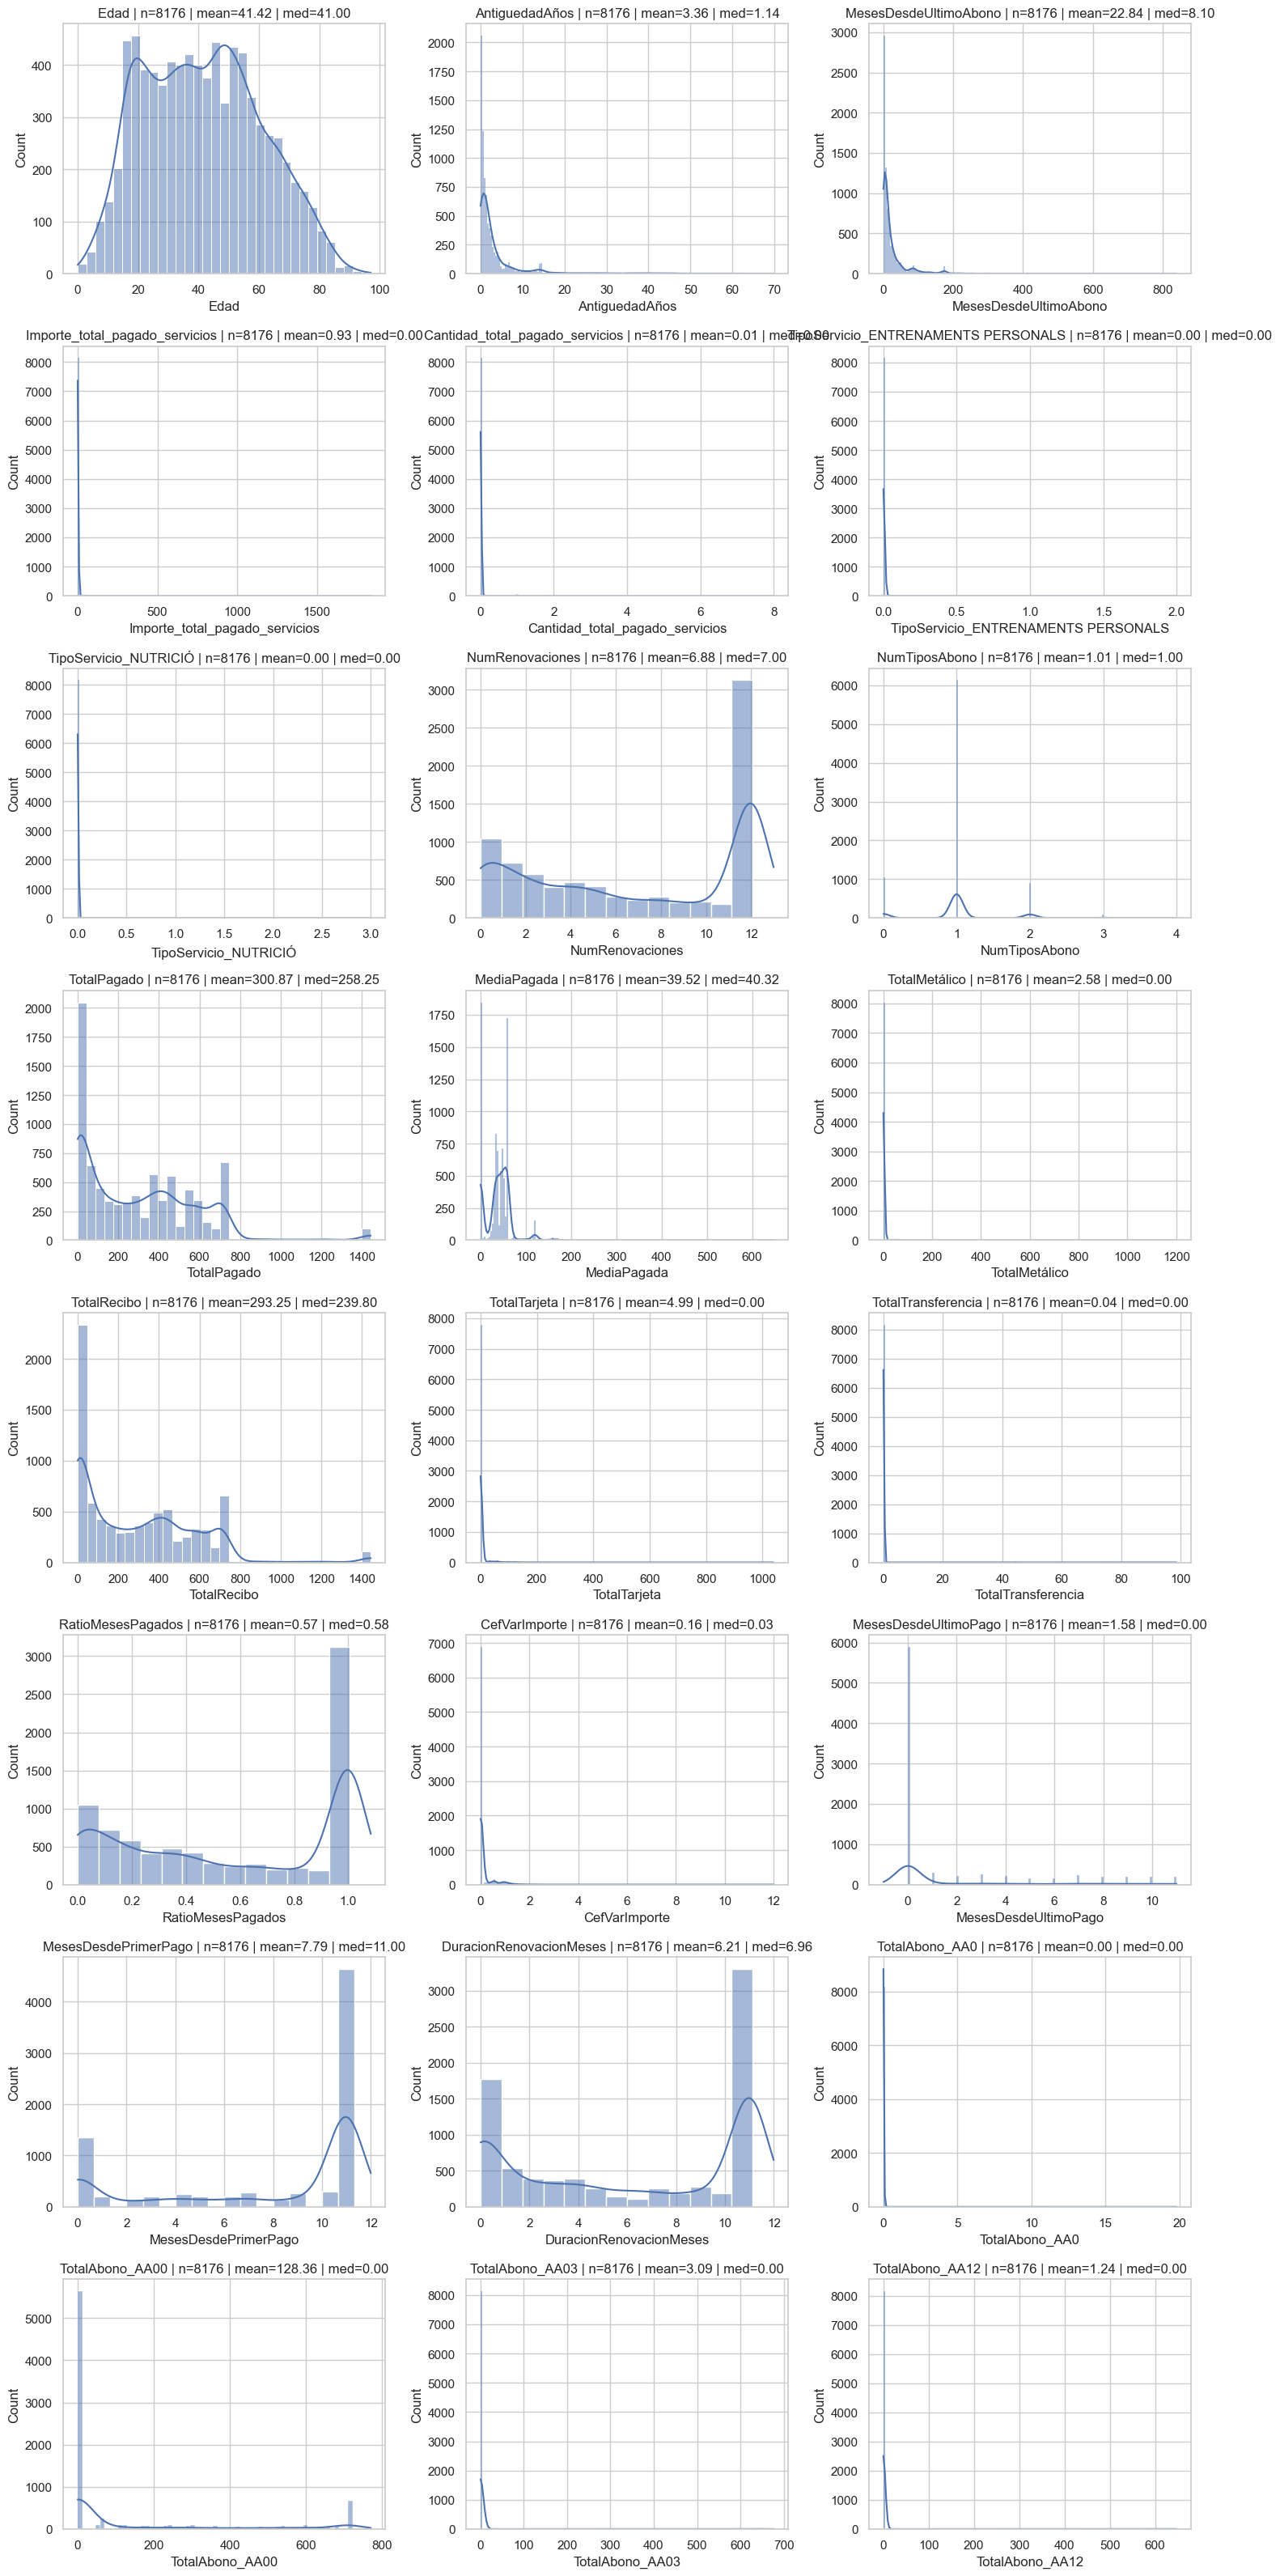

In [29]:
# Función para graficar distribuciones y estadísticas clave
def univariate_num(df, cols, nrows=4, max_plots=24):
    cols = cols[:max_plots]
    n = len(cols)
    ncols = 3
    nrows = int(np.ceil(n/ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
    axes = axes.flatten()
    for i, c in enumerate(cols):
        sns.histplot(df[c].dropna(), kde=True, ax=axes[i])
        axes[i].set_title(f"{c} | n={df[c].notna().sum()} | mean={df[c].mean():.2f} | med={df[c].median():.2f}")
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()

univariate_num(df, num_cols)

In [30]:
def top_freq(df, cols, topk=10):
    for c in cols:
        vc = df[c].value_counts(dropna=False).head(topk)
        print(f"--- {c} (n_unique={df[c].nunique()}) ---")
        display(vc.to_frame('count').assign(pct=lambda x: x['count']/len(df)))
        print()

top_freq(df, cat_cols[:40])
# Booleanas: proporción True/False
bool_summary = pd.DataFrame({c: df[c].value_counts(dropna=False) for c in bool_cols})
# mejor ver por loop
for c in bool_cols[:50]:
    print(c, df[c].value_counts(normalize=True, dropna=False).to_dict())

--- TipoUltimoAbono (n_unique=53) ---


,count,pct
TipoUltimoAbono,,
AA00,2671,0.326688
JO00,1001,0.122432
FA00,953,0.116561
AG00,694,0.084883
MA00,515,0.062989
AM00,470,0.057485
AR00,324,0.039628
QM01,309,0.037794
AF00,238,0.029110



--- FormaPagoMayoritaria (n_unique=5) ---


,count,pct
FormaPagoMayoritaria,,
Recibo,6076,0.743151
Indefinido,1046,0.127935
Metálico,884,0.108121
Tarjeta,163,0.019936
Transferencia,7,0.000856



--- TipoAbonoInicial (n_unique=38) ---


,count,pct
TipoAbonoInicial,,
AA00,2337,0.285837
Indefinido,1046,0.127935
FA00,875,0.107021
JO00,845,0.103351
AG00,701,0.085739
MA00,483,0.059075
AM00,407,0.049780
AR00,321,0.039261
AF00,219,0.026786



--- TipoAbonoFinal (n_unique=39) ---


,count,pct
TipoAbonoFinal,,
AA00,2270,0.277642
Indefinido,1046,0.127935
FA00,894,0.109344
JO00,863,0.105553
AG00,684,0.083659
MA00,457,0.055895
AM00,343,0.041952
AR00,309,0.037794
QM01,221,0.027030



--- TipoAbonoFrecuente (n_unique=37) ---


,count,pct
TipoAbonoFrecuente,,
AA00,2332,0.285225
Indefinido,1046,0.127935
FA00,881,0.107754
JO00,854,0.104452
AG00,721,0.088185
MA00,473,0.057852
AM00,382,0.046722
AR00,322,0.039384
AF00,229,0.028009



--- Diversidad_servicios_extra (n_unique=3) ---


,count,pct
Diversidad_servicios_extra,,
0,8139,0.995475
1,32,0.003914
2,5,0.000612



CambioAbono {0.0: 0.8784246575342466, 1.0: 0.12157534246575342}
Churn {False: 0.6032289628180039, True: 0.3967710371819961}
DiaFav_domingo {False: 0.9652641878669276, True: 0.034735812133072405}
DiaFav_jueves {False: 0.9141389432485323, True: 0.08586105675146771}
DiaFav_lunes {False: 0.7193003913894325, True: 0.28069960861056753}
DiaFav_martes {False: 0.8236301369863014, True: 0.17636986301369864}
DiaFav_miércoles {False: 0.8825831702544031, True: 0.11741682974559686}
DiaFav_sábado {False: 0.9377446183953033, True: 0.06225538160469667}
DiaFav_viernes {False: 0.9344422700587084, True: 0.06555772994129158}
EstFav_invierno {False: 0.9005626223091977, True: 0.09943737769080235}
EstFav_otono {False: 0.7657778864970646, True: 0.23422211350293543}
EstFav_primavera {False: 0.7869373776908023, True: 0.21306262230919765}
EstFav_verano {False: 0.723825831702544, True: 0.27617416829745595}
Irregularidad_ActivoIrregular {False: 0.7148972602739726, True: 0.2851027397260274}
Irregularidad_ActivoRegu

Target counts:
Churn
False    4932
True     3244
Name: count, dtype: int64
Target proportion:
Churn
False    0.603229
True     0.396771
Name: proportion, dtype: float64


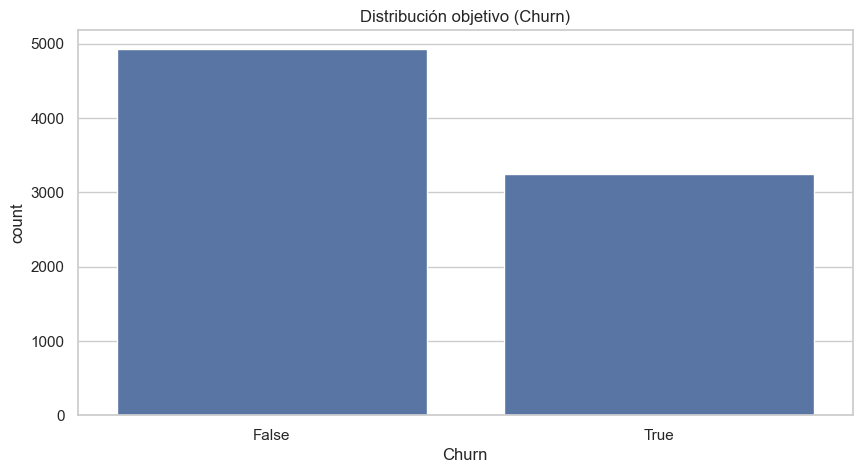

In [31]:
print('Target counts:')
print(df[TARGET].value_counts(dropna=False))
print('Target proportion:')
print(df[TARGET].value_counts(normalize=True))
sns.countplot(data=df, x=TARGET)
plt.title('Distribución objetivo (Churn)')
plt.show()


In [80]:
# Func para churn rate por grupo
def churn_rate_by(df, col, target=TARGET, min_count=50):
    ct = df.groupby(col)[target].agg(['mean','count']).rename(columns={'mean':'churn_rate'})
    ct = ct[ct['count']>=min_count].sort_values('churn_rate', ascending=False)
    return ct

# Ejemplos:
if 'TipoUltimoAbono' in df.columns:
    display(churn_rate_by(df, 'TipoUltimoAbono').head(20))
if 'Edad' in df.columns:
    # binned age churn
    df['Edad_bin'] = pd.cut(df['Edad'], bins=[0,18,30,45,60,120], labels=['<18','18-30','31-45','46-60','60+'])
    display(churn_rate_by(df, 'Edad_bin'))
# Sexo
if 'Sexo_Mujer' in df.columns:
    display(churn_rate_by(df, 'Sexo_Mujer'))

,churn_rate,count
TipoUltimoAbono,,
FM01,0.615385,78
AM00,0.582979,470
JO00,0.533467,1001
AC00,0.464115,209
MA00,0.440777,515
AA00,0.425309,2671
AT01,0.418750,160
AF00,0.369748,238
AR00,0.358025,324


,churn_rate,count
Edad_bin,,
18-30,0.549742,1548
31-45,0.461843,2018
<18,0.444245,1112
46-60,0.312962,2029
60+,0.225631,1467


,churn_rate,count
Sexo_Mujer,,
True,0.405283,4429
False,0.386709,3747


MesesDesdeUltimoPago       0.608220
RatioMesesPagados         -0.590388
NumRenovaciones           -0.590388
DuracionRenovacionMeses   -0.574911
TiempoActivoDias          -0.448714
SemanasTotales            -0.448174
TotalPagado               -0.427470
TotalRecibo               -0.425998
SemanasConVisita          -0.396923
DiasDesdeUltima            0.378375
SemanasConUnaVisita       -0.355686
DiasActivo                -0.326873
TotalVisitas              -0.322542
VisitasUlt180             -0.287938
MesesDesdeUltimoAbono     -0.272642
VisitasFindesemana        -0.261092
PropVerano                -0.254139
AntiguedadAños            -0.253744
VisitasUlt90              -0.242665
NumTiposAbono             -0.242412
VisitasUltimoTrimestre    -0.241732
MaxVisitasDia             -0.228742
HoraStdAcceso             -0.220157
VarDiasSemana             -0.217152
TotalAbono_AA00           -0.210853
Edad                      -0.207487
Edad                      -0.207487
MaxRachaConVisita         -0

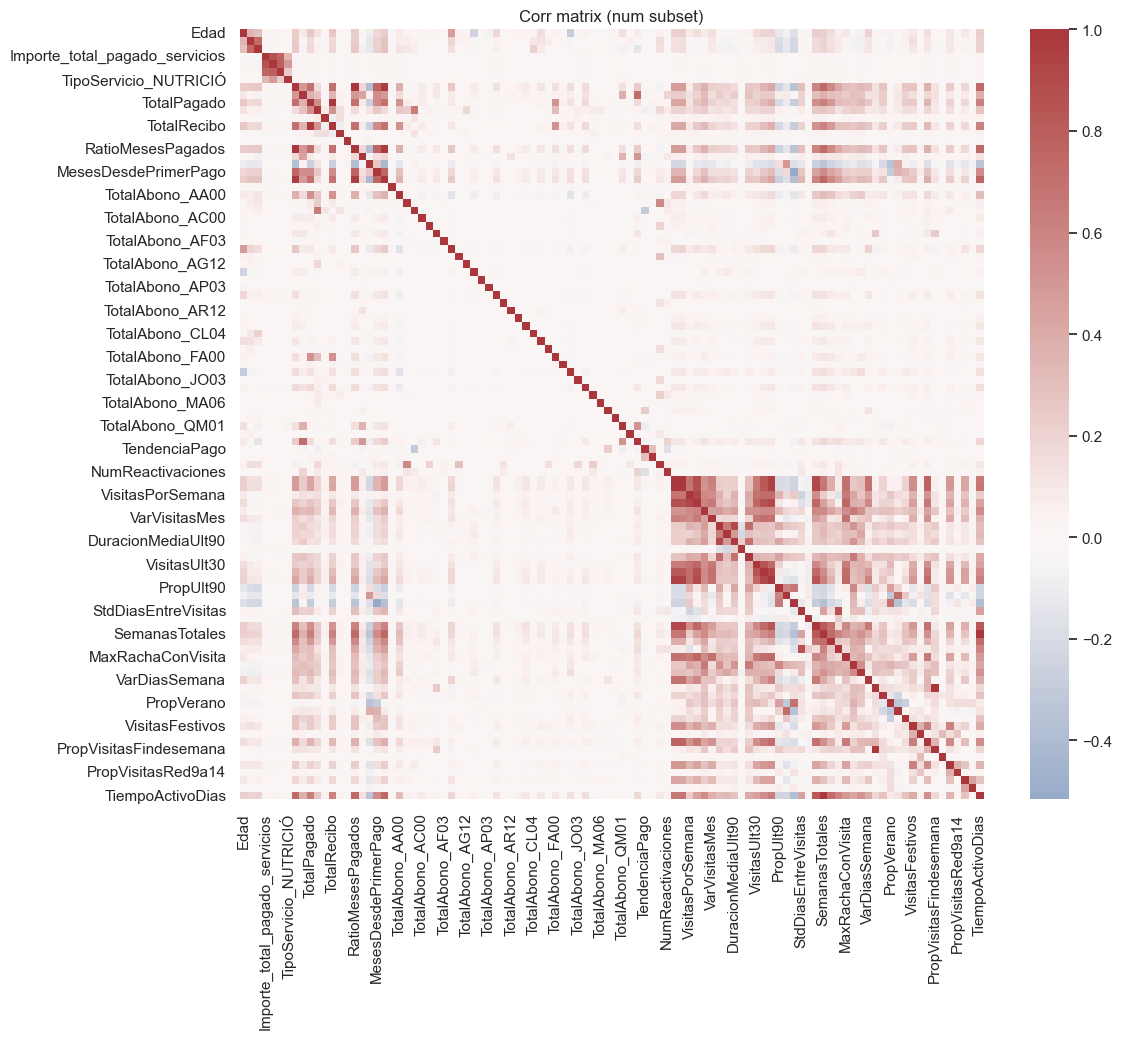

In [32]:
# Correlación con target
corr_with_target = df[num_cols + ['Edad']].corrwith(df[TARGET].astype(int)).sort_values(key=lambda x: x.abs(), ascending=False)
display(corr_with_target.head(30))

# Matriz completa (subsample si muchas columnas)
num_for_corr = num_cols.copy()
if len(num_for_corr) > 10:
    num_for_corr = num_for_corr[:100]  # limitar para visualizar
corr = df[num_for_corr].corr()
plt.figure(figsize=(12,10)); sns.heatmap(corr, cmap='vlag', center=0); plt.title('Corr matrix (num subset)')
plt.show()

In [33]:
# Calcular churn rate por cada boolean day/season
day_season_cols = [c for c in df.columns if c.startswith('DiaFav_') or c.startswith('EstFav_')]
churn_by_day = pd.DataFrame({
    'col': day_season_cols,
    'p_true': [df[c].mean() for c in day_season_cols],
    'churn_rate': [df.loc[df[c]==1, TARGET].mean() if df[c].sum()>0 else np.nan for c in day_season_cols],
    'n': [df[c].sum() for c in day_season_cols]
}).sort_values('churn_rate', ascending=False)
display(churn_by_day)

,col,p_true,churn_rate,n
8,EstFav_otono,0.234222,0.519582,1915
7,EstFav_invierno,0.099437,0.458795,813
1,DiaFav_jueves,0.085861,0.397436,702
4,DiaFav_miércoles,0.117417,0.372917,960
3,DiaFav_martes,0.176370,0.361304,1442
2,DiaFav_lunes,0.280700,0.343355,2295
5,DiaFav_sábado,0.062255,0.337917,509
6,DiaFav_viernes,0.065558,0.324627,536
0,DiaFav_domingo,0.034736,0.320423,284
9,EstFav_primavera,0.213063,0.287026,1742


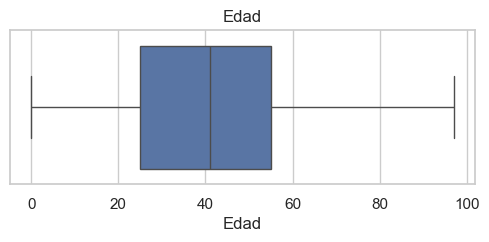

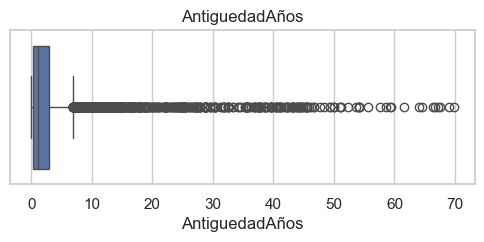

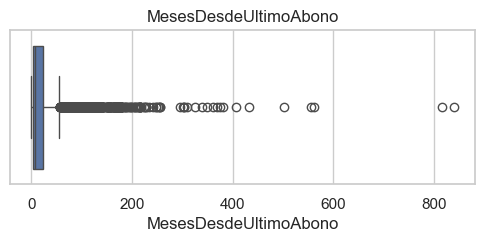

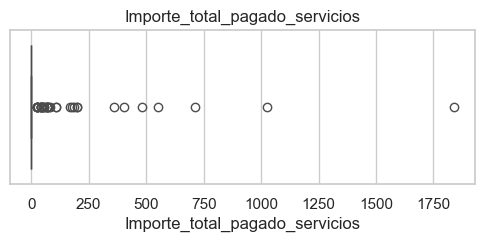

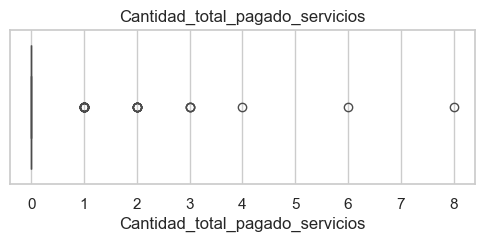

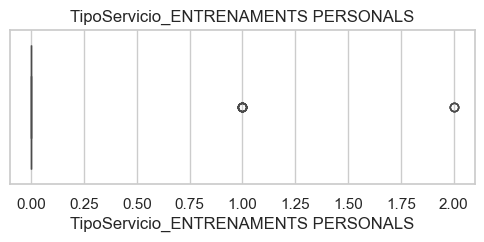

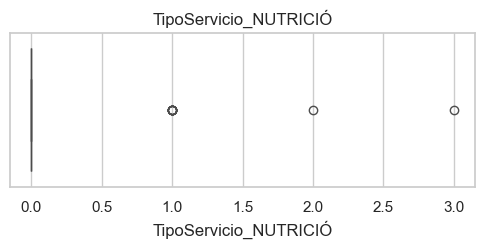

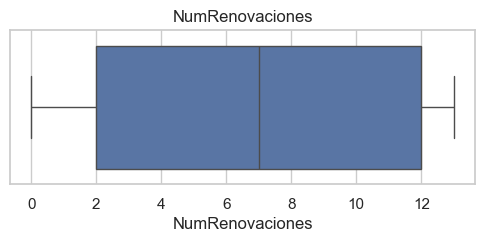

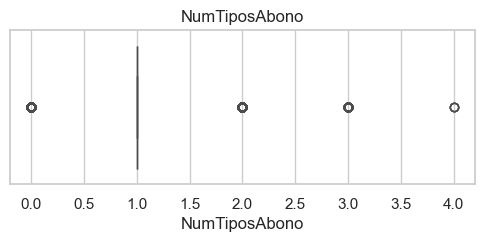

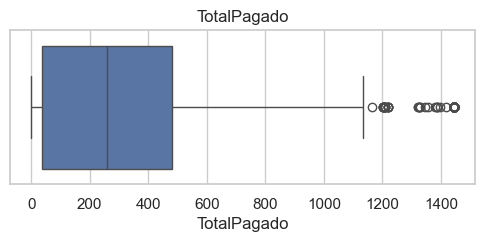

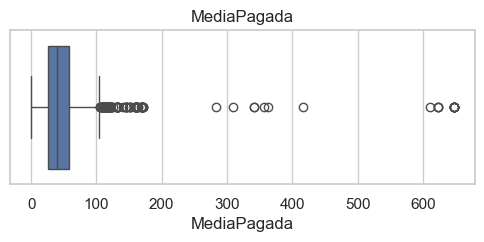

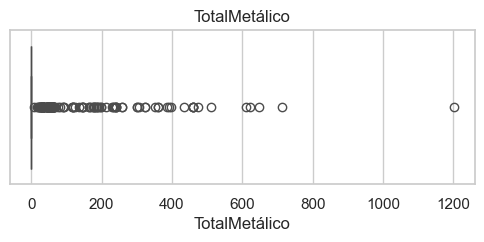

[('DeltaDuracionUlt90VsTotal', np.int64(3182)),
 ('MaxVisitasDia', np.int64(2911)),
 ('NumTiposAbono', np.int64(2040)),
 ('MesesDesdeUltimoPago', np.int64(1768)),
 ('VisitasFestivos', np.int64(1734)),
 ('PropVisitasFestivos', np.int64(1734)),
 ('TotalAbono_AA00', np.int64(1457)),
 ('TendenciaPago', np.int64(1391)),
 ('VisitasRed9a14', np.int64(1314)),
 ('PropVisitasRed9a14', np.int64(1314)),
 ('CefVarImporte', np.int64(1282)),
 ('VarDiasSemana', np.int64(1117)),
 ('FrecuenciaModal', np.int64(1046)),
 ('NumCambiosAbono', np.int64(994)),
 ('AntiguedadAños', np.int64(969)),
 ('TotalAbono_JO00', np.int64(926)),
 ('DiasDesdeUltima', np.int64(882)),
 ('MesesDesdeUltimoAbono', np.int64(851)),
 ('VarVisitasMes', np.int64(772)),
 ('TendenciaPagoMismoAbono', np.int64(753))]

In [34]:
# Boxplots para variables numéricas clave
for c in num_cols[:12]:
    plt.figure(figsize=(6,2))
    sns.boxplot(x=df[c].dropna()); plt.title(c); plt.show()

# Regla IQR para detectar extremos
def detect_outliers_iqr(series, k=1.5):
    q1 = series.quantile(0.25); q3 = series.quantile(0.75)
    iqr = q3-q1
    low = q1 - k*iqr; high = q3 + k*iqr
    return (series < low) | (series > high)

outlier_counts = {c: detect_outliers_iqr(df[c].dropna()).sum() if c in num_cols else 0 for c in num_cols}
sorted(outlier_counts.items(), key=lambda x: x[1], reverse=True)[:20]


## THE FINAL FEATURE ENGINEERING

## MODELAJE

In [35]:
list(df.columns)

['IdPersona',
 'Edad',
 'Sexo_Mujer',
 'Churn',
 'AntiguedadAños',
 'TipoUltimoAbono',
 'Irregularidad_ActivoIrregular',
 'Irregularidad_ActivoRegular',
 'Irregularidad_BajaFinalIrregular',
 'Irregularidad_BajaFinalRegular',
 'MesesDesdeUltimoAbono',
 'Importe_total_pagado_servicios',
 'Cantidad_total_pagado_servicios',
 'TipoServicio_ENTRENAMENTS PERSONALS',
 'TipoServicio_FISIOTERÀPIA',
 'TipoServicio_NUTRICIÓ',
 'UsoServiciosExtra',
 'NumRenovaciones',
 'NumTiposAbono',
 'TotalPagado',
 'MediaPagada',
 'TotalMetálico',
 'TotalRecibo',
 'TotalTarjeta',
 'TotalTransferencia',
 'CambioAbono',
 'RatioMesesPagados',
 'CefVarImporte',
 'MesesDesdeUltimoPago',
 'MesesDesdePrimerPago',
 'DuracionRenovacionMeses',
 'FormaPagoMayoritaria',
 'TipoAbonoInicial',
 'TipoAbonoFinal',
 'TotalAbono_AA0',
 'TotalAbono_AA00',
 'TotalAbono_AA03',
 'TotalAbono_AA12',
 'TotalAbono_AC00',
 'TotalAbono_AC03',
 'TotalAbono_AF00',
 'TotalAbono_AF03',
 'TotalAbono_AG00',
 'TotalAbono_AG03',
 'TotalAbono_AG12'

In [ ]:
X = df[['Edad', 'AntiguedadAños', 'Sexo_Mujer', 'Importe_total_pagado_servicios',
 'Cantidad_total_pagado_servicios', 'TipoServicio_ENTRENAMENTS PERSONALS',
 'TipoServicio_FISIOTERÀPIA',
 'TipoServicio_NUTRICIÓ',
 'UsoServiciosExtra','ratio_importe_2025_2024',
 'ratio_cantidad_2025_2024',
 'Uso_entrenamientos_personales',
 'Uso_fisioterapia',
 'Uso_nutricion',
 'Diversidad_servicios_extra','TotalPagado', 
       
        'TienePagos', 'TotalVisitas','VisitasUlt180', 'TieneAccesos',


        'VisitasPorSemana',
 'VisitasPorMes',
         'DiaFav_domingo',
 'DiaFav_jueves',
 'DiaFav_lunes',
 'DiaFav_martes',
 'DiaFav_miércoles',
 'DiaFav_sábado',
 'DiaFav_viernes',
 'EstFav_invierno',
 'EstFav_otono',
 'EstFav_primavera',
 'EstFav_verano',
        
        
        ]]

y = df['Churn']


In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Dividir train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Identificar tipos
num_cols = ['Edad', 'AntiguedadAños', 'TotalPagado', 'Importe_total_pagado_servicios','Cantidad_total_pagado_servicios','TipoServicio_ENTRENAMENTS PERSONALS',
 'TipoServicio_FISIOTERÀPIA',
 'TipoServicio_NUTRICIÓ', 'ratio_importe_2025_2024',
 'ratio_cantidad_2025_2024', 'Diversidad_servicios_extra', 'TotalVisitas','VisitasUlt180',]
bool_cols = ['Sexo_Mujer', 'Uso_entrenamientos_personales',
 'Uso_fisioterapia',
 'Uso_nutricion','UsoServiciosExtra', 'TienePagos', 'TieneAccesos',  'DiaFav_domingo',
 'DiaFav_jueves',
 'DiaFav_lunes',
 'DiaFav_martes',
 'DiaFav_miércoles',
 'DiaFav_sábado',
 'DiaFav_viernes',
 'EstFav_invierno',
 'EstFav_otono',
 'EstFav_primavera',
 'EstFav_verano',]

# Transformador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('bool', 'passthrough', bool_cols)
    ]
)

In [37]:
# Crear pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('bool', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


AUC: 0.8617357851170802
              precision    recall  f1-score   support

       False       0.82      0.84      0.83      1480
        True       0.74      0.72      0.73       973

    accuracy                           0.79      2453
   macro avg       0.78      0.78      0.78      2453
weighted avg       0.79      0.79      0.79      2453

Matriz de confusión:
 [[1241  239]
 [ 277  696]]


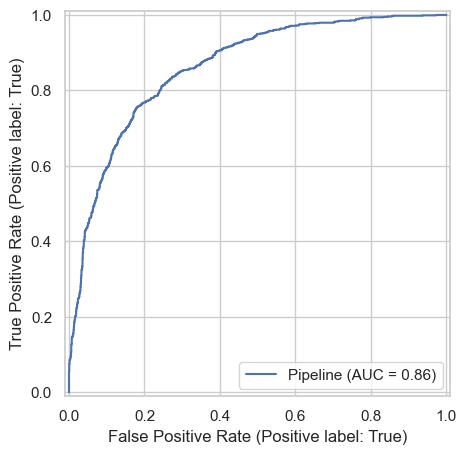

In [38]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print("AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:\n", cm)

RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()

In [45]:
clf = model.named_steps['classifier']
coef_df = pd.DataFrame({
    'Variable': num_cols + bool_cols,
    'Coeficiente': clf.coef_[0]
}).sort_values('Coeficiente', ascending=False)

print(coef_df)

                               Variable  Coeficiente
12                        VisitasUlt180     0.563988
5   TipoServicio_ENTRENAMENTS PERSONALS     0.214346
9              ratio_cantidad_2025_2024     0.159576
13                           Sexo_Mujer     0.080950
10           Diversidad_servicios_extra     0.076922
6             TipoServicio_FISIOTERÀPIA     0.056343
14        Uso_entrenamientos_personales     0.016902
3        Importe_total_pagado_servicios     0.012567
17                    UsoServiciosExtra     0.006107
15                     Uso_fisioterapia     0.002069
16                        Uso_nutricion    -0.013923
0                                  Edad    -0.089925
19                         TieneAccesos    -0.115987
7                 TipoServicio_NUTRICIÓ    -0.238898
8               ratio_importe_2025_2024    -0.273192
4       Cantidad_total_pagado_servicios    -0.511404
18                           TienePagos    -0.518319
2                           TotalPagado    -0.

In [82]:
list(df.columns)

['IdPersona',
 'Edad',
 'Sexo_Mujer',
 'Churn',
 'AntiguedadAños',
 'TipoUltimoAbono',
 'Irregularidad_ActivoIrregular',
 'Irregularidad_ActivoRegular',
 'Irregularidad_BajaFinalIrregular',
 'Irregularidad_BajaFinalRegular',
 'MesesDesdeUltimoAbono',
 'Importe_total_pagado_servicios',
 'Cantidad_total_pagado_servicios',
 'TipoServicio_ENTRENAMENTS PERSONALS',
 'TipoServicio_FISIOTERÀPIA',
 'TipoServicio_NUTRICIÓ',
 'UsoServiciosExtra',
 'NumRenovaciones',
 'NumTiposAbono',
 'TotalPagado',
 'MediaPagada',
 'TotalMetálico',
 'TotalRecibo',
 'TotalTarjeta',
 'TotalTransferencia',
 'CambioAbono',
 'RatioMesesPagados',
 'CefVarImporte',
 'MesesDesdeUltimoPago',
 'MesesDesdePrimerPago',
 'DuracionRenovacionMeses',
 'FormaPagoMayoritaria',
 'TipoAbonoInicial',
 'TipoAbonoFinal',
 'TotalAbono_AA0',
 'TotalAbono_AA00',
 'TotalAbono_AA03',
 'TotalAbono_AA12',
 'TotalAbono_AC00',
 'TotalAbono_AC03',
 'TotalAbono_AF00',
 'TotalAbono_AF03',
 'TotalAbono_AG00',
 'TotalAbono_AG03',
 'TotalAbono_AG12'

In [88]:
df[df['IdPersona']==90145
]

,IdPersona,Edad,Sexo_Mujer,Churn,AntiguedadAños,TipoUltimoAbono,Irregularidad_ActivoIrregular,Irregularidad_ActivoRegular,Irregularidad_BajaFinalIrregular,Irregularidad_BajaFinalRegular,MesesDesdeUltimoAbono,Importe_total_pagado_servicios,Cantidad_total_pagado_servicios,TipoServicio_ENTRENAMENTS PERSONALS,TipoServicio_FISIOTERÀPIA,TipoServicio_NUTRICIÓ,UsoServiciosExtra,NumRenovaciones,NumTiposAbono,TotalPagado,MediaPagada,TotalMetálico,TotalRecibo,TotalTarjeta,TotalTransferencia,CambioAbono,RatioMesesPagados,CefVarImporte,MesesDesdeUltimoPago,MesesDesdePrimerPago,DuracionRenovacionMeses,FormaPagoMayoritaria,TipoAbonoInicial,TipoAbonoFinal,TotalAbono_AA0,TotalAbono_AA00,TotalAbono_AA03,TotalAbono_AA12,TotalAbono_AC00,TotalAbono_AC03,TotalAbono_AF00,TotalAbono_AF03,TotalAbono_AG00,TotalAbono_AG03,TotalAbono_AG12,TotalAbono_AM00,TotalAbono_AM03,TotalAbono_AP00,TotalAbono_AP03,TotalAbono_AR00,TotalAbono_AR03,TotalAbono_AR12,TotalAbono_AT00,TotalAbono_AT01,TotalAbono_AVET,TotalAbono_CL04,TotalAbono_CR01,TotalAbono_CR03,TotalAbono_EMPF,TotalAbono_FA00,TotalAbono_FA12,TotalAbono_FM01,TotalAbono_JO00,TotalAbono_JO03,TotalAbono_MA00,TotalAbono_MA03,TotalAbono_MA06,TotalAbono_MA12,TotalAbono_NI00,TotalAbono_QM01,TotalAbono_QM03,TotalAbono_TEMP,TotalAbono_VIP,TipoAbonoFrecuente,NumCambiosAbono,TendenciaPago,TendenciaPagoMismoAbono,NumImpagosReales,NumReactivaciones,TienePagos,PagoSinSaltos_irregular,PagoSinSaltos_no_aplica,PagoSinSaltos_regular,TotalVisitas,DiasActivo,VisitasPorSemana,VisitasPorMes,MaxVisitasDia,VarVisitasMes,DuracionMediaTotal,DuracionStdTotal,DuracionMediaUlt90,DeltaDuracionUlt90VsTotal,PropVisitasLargas,VisitasUlt30,VisitasUlt90,VisitasUlt180,PropUlt90,DiasDesdeUltima,DiasHastaPrimera,StdDiasEntreVisitas,FrecuenciaModal,SemanasConVisita,SemanasTotales,SemanasConUnaVisita,MaxRachaSinVisita,MaxRachaConVisita,HoraMediaAcceso,HoraStdAcceso,VarDiasSemana,PropFindesemana,PropPrimavera,PropVerano,PropOtono,PropInvierno,VisitasFestivos,PropVisitasFestivos,VisitasFindesemana,PropVisitasFindesemana,VisitasCerrado,PropVisitasCerrado,VisitasRed9a14,PropVisitasRed9a14,VisitasRed7a20,PropVisitasRed7a20,VisitasRed7a15,PropVisitasRed7a15,TiempoActivoDias,VisitasPrimerTrimestre,VisitasUltimoTrimestre,DiaFav_domingo,DiaFav_jueves,DiaFav_lunes,DiaFav_martes,DiaFav_miércoles,DiaFav_sábado,DiaFav_viernes,EstFav_invierno,EstFav_otono,EstFav_primavera,EstFav_verano,TieneAccesos,ratio_importe_2025_2024,ratio_cantidad_2025_2024,Uso_entrenamientos_personales,Uso_fisioterapia,Uso_nutricion,Diversidad_servicios_extra
7976,90145,62.0,False,True,1.25,AR00,False,False,True,False,3.0,0.0,0.0,0.0,0.0,0.0,False,6.0,1.0,195.85,32.641667,0.0,195.85,0.0,0.0,0.0,0.5,0.038295,1.0,11.0,9.986859,Recibo,AR00,AR00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,195.85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AR00,0.0,0.00403,0.00403,2.0,0.0,True,True,False,False,6.0,6.0,0.140468,0.559006,1.0,0.25,46.058333,12.635674,54.727778,0.188227,0.166667,1.0,3.0,4.0,0.5,75.0,32.0,51.631773,2.0,5.0,42.0,4.0,128.0,1.0,12.363889,2.14518,0.693878,0.166667,0.0,0.5,0.333333,0.166667,0.0,0.0,1.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,292.0,2.0,3.0,False,False,True,False,False,False,False,False,False,False,True,True,0.0,0.0,False,False,False,0


In [85]:
X = df[['Edad', 'AntiguedadAños', 'Sexo_Mujer',  'NumTiposAbono']]
y = df['Churn']


🔍 Optimizando Regresión Logística...

🔍 Optimizando Random Forest...

🔍 Optimizando Gradient Boosting...

🔍 Optimizando SVM...

🔍 Optimizando KNN...


,Modelo,Mejores Parámetros,AUC,Accuracy,Recall,F1,Matriz Confusión,Tiempo (s),Best_Model
2,Gradient Boosting,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.828299,0.759169,0.640986,0.678630,"[[826, 161], [233, 416]]",13.80,([DecisionTreeRegressor(criterion='friedman_ms...
1,Random Forest,"{'max_depth': 10, 'min_samples_leaf': 2, 'min_...",0.821208,0.745721,0.651772,0.670365,"[[797, 190], [226, 423]]",11.60,"(DecisionTreeClassifier(max_depth=10, max_feat..."
0,Regresión Logística,"{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}",0.766244,0.692543,0.508475,0.567498,"[[803, 184], [319, 330]]",0.26,"LogisticRegression(C=10, max_iter=1000, random..."
3,SVM,"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}",0.760735,0.698044,0.522342,0.578498,"[[803, 184], [310, 339]]",208.98,"SVC(C=10, probability=True, random_state=42)"
4,KNN,"{'n_neighbors': 9, 'weights': 'uniform'}",0.754097,0.691320,0.582435,0.599524,"[[753, 234], [271, 378]]",0.16,KNeighborsClassifier(n_neighbors=9)


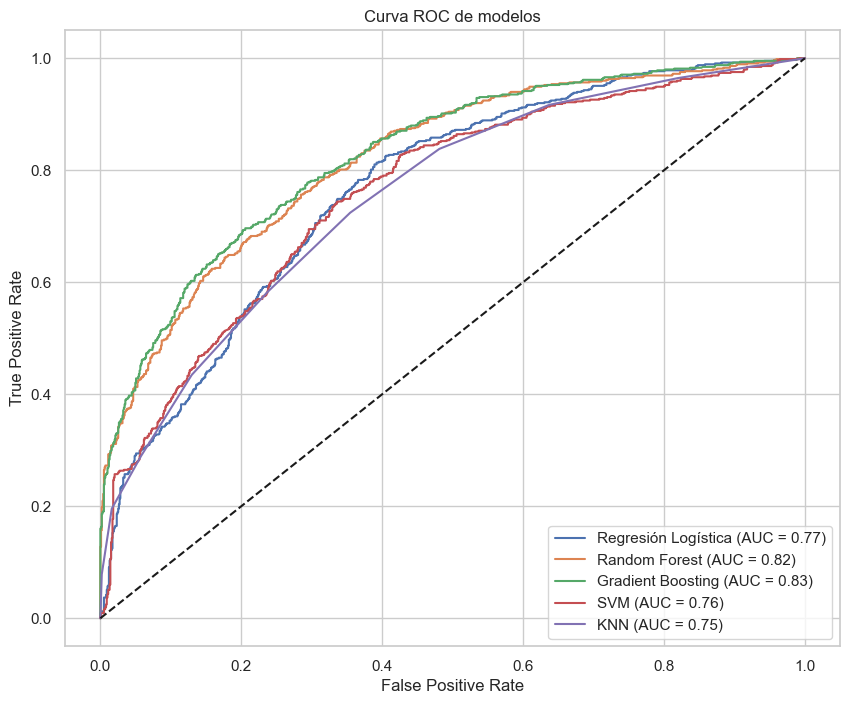

🏆 Mejor modelo:
Modelo: Gradient Boosting
AUC: 0.828
Accuracy: 0.759
Recall: 0.641
F1: 0.679
Mejores Parámetros: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Matriz de Confusión:
 [[826 161]
 [233 416]]

🔥 Importancia de variables del mejor modelo:


,Variable,Importancia
1,AntiguedadAños,0.740605
3,NumTiposAbono,0.157229
0,Edad,0.095273
2,Sexo_Mujer,0.006893


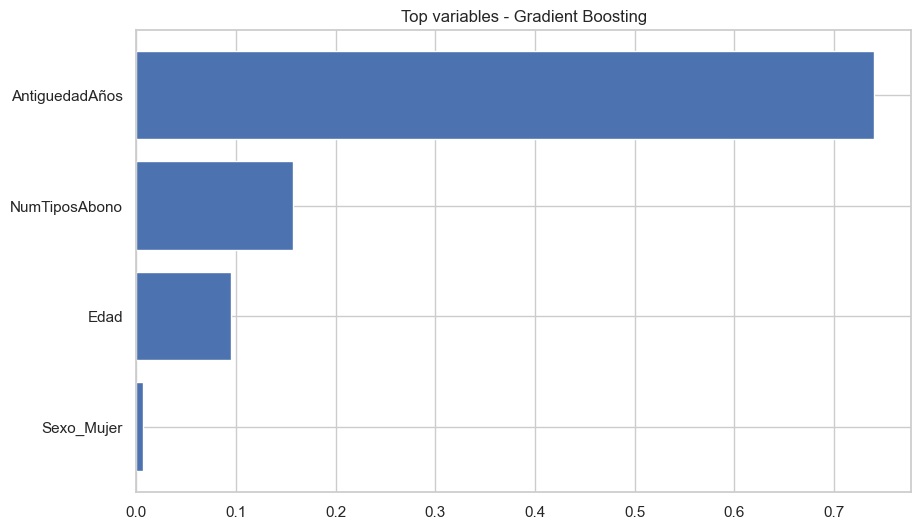

In [86]:
# ==============================
#  Librerías

import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_auc_score, accuracy_score, f1_score, recall_score,
                             confusion_matrix, roc_curve, auc)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns

# ==============================
#  Split de datos y escalado

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ==============================
#  Modelos y grids

modelos = {
    "Regresión Logística": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier()
}

param_grids = {
    "Regresión Logística": {"C": [0.01, 0.1, 1, 10], "penalty": ["l2"], "solver": ["lbfgs"]},
    "Random Forest": {"n_estimators": [100,200], "max_depth": [None,5,10], 
                      "min_samples_split": [2,5], "min_samples_leaf": [1,2]},
    "Gradient Boosting": {"n_estimators": [100,200], "learning_rate": [0.01,0.05,0.1], 
                          "max_depth": [2,3,4], "subsample": [0.8,1.0]},
    "SVM": {"C": [0.1,1,10], "kernel": ["rbf","poly"], "gamma": ["scale","auto"]},
    "KNN": {"n_neighbors": [3,5,7,9], "weights": ["uniform","distance"]}
}

# ==============================
#  Entrenamiento, evaluación y resultados

resultados = []

plt.figure(figsize=(10,8))

for i, (nombre, modelo) in enumerate(modelos.items(),1):
    print(f"\n🔍 Optimizando {nombre}...")
    start = time.time()
    
    grid = GridSearchCV(estimator=modelo, param_grid=param_grids[nombre], 
                        scoring='roc_auc', cv=5, n_jobs=-1, verbose=0)
    grid.fit(X_train_scaled, y_train)
    tiempo = round(time.time() - start,2)
    
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    y_prob = best_model.predict_proba(X_test_scaled)[:,1] if hasattr(best_model, "predict_proba") else None
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    
    # ROC curve
    if y_prob is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{nombre} (AUC = {roc_auc:.2f})')
    else:
        roc_auc = None

    resultados.append({
        "Modelo": nombre,
        "Mejores Parámetros": grid.best_params_,
        "AUC": roc_auc,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "Matriz Confusión": cm,
        "Tiempo (s)": tiempo,
        "Best_Model": best_model  # guardamos el objeto entrenado
    })

# ==============================
#  Resultados en DataFrame

df_resultados = pd.DataFrame(resultados).sort_values(by="AUC", ascending=False)
display(df_resultados)

# ==============================
#  Gráfico ROC de todos los modelos

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC de modelos")
plt.legend(loc="lower right")
plt.show()

# ==============================
# Mejor modelo según AUC

mejor_modelo = df_resultados.iloc[0]
best_model = mejor_modelo["Best_Model"]

print("🏆 Mejor modelo:")
print("Modelo:", mejor_modelo["Modelo"])
print("AUC:", round(mejor_modelo["AUC"],3))
print("Accuracy:", round(mejor_modelo["Accuracy"],3))
print("Recall:", round(mejor_modelo["Recall"],3))
print("F1:", round(mejor_modelo["F1"],3))
print("Mejores Parámetros:", mejor_modelo["Mejores Parámetros"])
print("Matriz de Confusión:\n", mejor_modelo["Matriz Confusión"])

# ==============================
# Importancia de variables solo si aplica

if hasattr(best_model, "feature_importances_"):
    importances = pd.DataFrame({
        'Variable': X_train.columns,
        'Importancia': best_model.feature_importances_
    }).sort_values(by='Importancia', ascending=False)

    print("\n🔥 Importancia de variables del mejor modelo:")
    display(importances)

    plt.figure(figsize=(10,6))
    plt.barh(importances['Variable'][:], importances['Importancia'][:])
    plt.gca().invert_yaxis()
    plt.title(f"Top variables - {mejor_modelo['Modelo']}")
    plt.show()
else:
    print("\n⚠️ Este modelo no tiene atributo 'feature_importances_'")


🔍 Optimizando Regresión Logística...

🔍 Optimizando Random Forest...

🔍 Optimizando Gradient Boosting...

🔍 Optimizando SVM...

🔍 Optimizando KNN...


,Modelo,Mejores Parámetros,AUC,Accuracy,Recall,F1,Matriz Confusión,Tiempo (s)
2,Gradient Boosting,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",0.955065,0.881491,0.836672,0.848437,"[[900, 88], [106, 543]]",27.57
1,Random Forest,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.932610,0.858888,0.790447,0.816229,"[[893, 95], [136, 513]]",12.15
4,KNN,"{'n_neighbors': 9, 'weights': 'distance'}",0.866108,0.791081,0.716487,0.731132,"[[830, 158], [184, 465]]",0.56
3,SVM,"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}",0.852227,0.776420,0.798151,0.738944,"[[753, 235], [131, 518]]",55.81
0,Regresión Logística,"{'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}",0.809674,0.731827,0.694915,0.672632,"[[747, 241], [198, 451]]",4.90


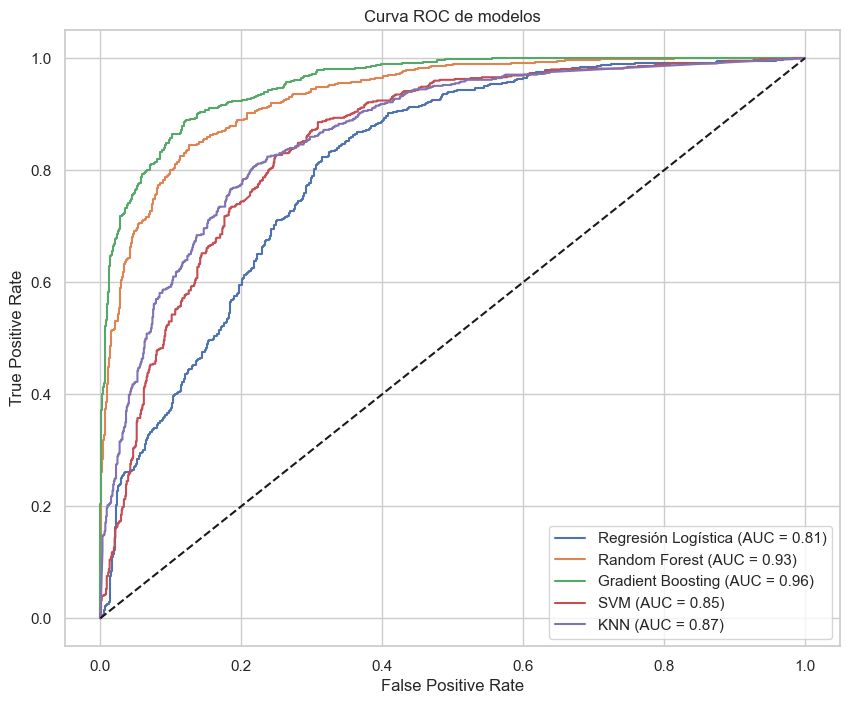

🏆 Mejor modelo:
Modelo: Gradient Boosting
AUC: 0.955
Accuracy: 0.881
Recall: 0.837
F1: 0.848
Mejores Parámetros: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.8}
Matriz de Confusión:
 [[900  88]
 [106 543]]

🔥 Importancia de variables - Gradient Boosting:


,Variable,Importancia
15,TotalPagado,5.815929e-01
1,AntiguedadAños,2.563096e-01
0,Edad,6.408673e-02
16,TienePagos,4.371929e-02
17,TotalVisitas,3.700555e-02
18,VisitasUlt180,1.318284e-02
2,Sexo_Mujer,2.267610e-03
19,TieneAccesos,1.032521e-03
9,ratio_importe_2025_2024,3.624951e-04
14,Diversidad_servicios_extra,3.251121e-04


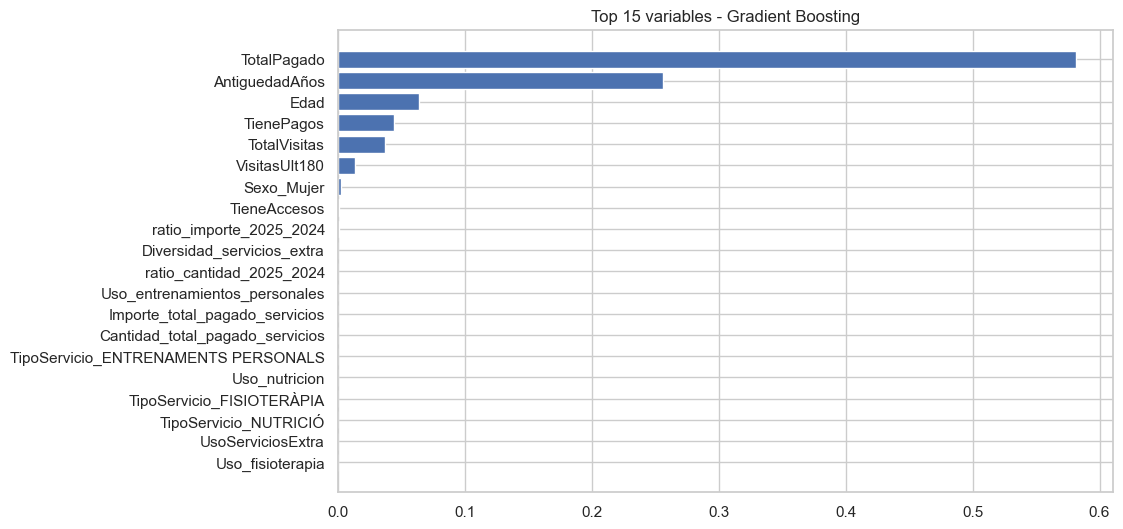

In [ ]:
# ==============================
#  Librerías

import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_auc_score, accuracy_score, f1_score, recall_score,
                             confusion_matrix, roc_curve, auc)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns

# ==============================
# Preparar datos

X = df[['Edad', 'AntiguedadAños', 'Sexo_Mujer', 'Importe_total_pagado_servicios',
        'Cantidad_total_pagado_servicios', 'TipoServicio_ENTRENAMENTS PERSONALS',
        'TipoServicio_FISIOTERÀPIA','TipoServicio_NUTRICIÓ','UsoServiciosExtra',
        'ratio_importe_2025_2024','ratio_cantidad_2025_2024','Uso_entrenamientos_personales',
        'Uso_fisioterapia','Uso_nutricion','Diversidad_servicios_extra','TotalPagado', 
        'TienePagos', 'TotalVisitas','VisitasUlt180','TieneAccesos']]
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ==============================
#  Modelos y grids

modelos = {
    "Regresión Logística": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier()
}

param_grids = {
    "Regresión Logística": {"C": [0.01, 0.1, 1, 10], "penalty": ["l2"], "solver": ["lbfgs"]},
    "Random Forest": {"n_estimators": [100,200], "max_depth": [None,5,10], 
                      "min_samples_split": [2,5], "min_samples_leaf": [1,2]},
    "Gradient Boosting": {"n_estimators": [100,200], "learning_rate": [0.01,0.05,0.1], 
                          "max_depth": [2,3,4], "subsample": [0.8,1.0]},
    "SVM": {"C": [0.1,1,10], "kernel": ["rbf","poly"], "gamma": ["scale","auto"]},
    "KNN": {"n_neighbors": [3,5,7,9], "weights": ["uniform","distance"]}
}

# ==============================
#  Entrenamiento, evaluación y resultados

resultados = []

plt.figure(figsize=(10,8))

for i, (nombre, modelo) in enumerate(modelos.items(),1):
    print(f"\n🔍 Optimizando {nombre}...")
    start = time.time()
    
    grid = GridSearchCV(estimator=modelo, param_grid=param_grids[nombre], 
                        scoring='roc_auc', cv=5, n_jobs=-1, verbose=0)
    grid.fit(X_train_scaled, y_train)
    tiempo = round(time.time() - start,2)
    
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    y_prob = best_model.predict_proba(X_test_scaled)[:,1] if hasattr(best_model, "predict_proba") else None
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    
    # ROC curve
    if y_prob is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{nombre} (AUC = {roc_auc:.2f})')
    else:
        roc_auc = None

    resultados.append({
        "Modelo": nombre,
        "Mejores Parámetros": grid.best_params_,
        "AUC": roc_auc,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "Matriz Confusión": cm,
        "Tiempo (s)": tiempo
    })

# ==============================
#  Resultados en DataFrame

df_resultados = pd.DataFrame(resultados).sort_values(by="AUC", ascending=False)
display(df_resultados)


# ==============================
#  Gráfico ROC

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC de modelos")
plt.legend(loc="lower right")
plt.show()

# ==============================
# Mejor modelo según AUC

mejor_modelo = df_resultados.iloc[0]
print("🏆 Mejor modelo:")
print("Modelo:", mejor_modelo["Modelo"])
print("AUC:", round(mejor_modelo["AUC"],3))
print("Accuracy:", round(mejor_modelo["Accuracy"],3))
print("Recall:", round(mejor_modelo["Recall"],3))
print("F1:", round(mejor_modelo["F1"],3))
print("Mejores Parámetros:", mejor_modelo["Mejores Parámetros"])
print("Matriz de Confusión:\n", mejor_modelo["Matriz Confusión"])

# ==============================
#  Importancia de variables 
if hasattr(best_model, "feature_importances_"):
    importances = pd.DataFrame({
        'Variable': X_train.columns,
        'Importancia': best_model.feature_importances_
    }).sort_values(by='Importancia', ascending=False)

    print("\n🔥 Importancia de variables del mejor modelo:")
    display(importances)

    plt.figure(figsize=(10,6))
    plt.barh(importances['Variable'][:], importances['Importancia'][:])
    plt.gca().invert_yaxis()
    plt.title(f"Top variables - {mejor_modelo['Modelo']}")
    plt.show()
else:
    print("\n⚠️ Este modelo no tiene atributo 'feature_importances_'")


PROBAMOS CON MÁS VARIABLES

In [ ]:
X = df[['Edad', 'AntiguedadAños', 'Sexo_Mujer', 'Importe_total_pagado_servicios',
        'Cantidad_total_pagado_servicios', 'TipoServicio_ENTRENAMENTS PERSONALS',
        'TipoServicio_FISIOTERÀPIA',
        'TipoServicio_NUTRICIÓ',
        'UsoServiciosExtra','ratio_importe_2025_2024',
        'ratio_cantidad_2025_2024',
        'Uso_entrenamientos_personales',
        'Uso_fisioterapia',
        'Uso_nutricion',
        'Diversidad_servicios_extra','TotalPagado', 

        'TienePagos', 'TotalVisitas','VisitasUlt180', 'TieneAccesos',

        
        'DiaFav_domingo',
        'DiaFav_jueves',
        'DiaFav_lunes',
        'DiaFav_martes',
        'DiaFav_miércoles',
        'DiaFav_sábado',
        'DiaFav_viernes',
        'EstFav_invierno',
        'EstFav_otono',
        'EstFav_primavera',
        'EstFav_verano',
        
        
        ]]

y = df['Churn']


🔍 Optimizando Regresión Logística...

🔍 Optimizando Random Forest...

🔍 Optimizando Gradient Boosting...

🔍 Optimizando SVM...

🔍 Optimizando KNN...


,Modelo,Mejores Parámetros,AUC,Accuracy,Recall,F1,Matriz Confusión,Tiempo (s),Best_Model
2,Gradient Boosting,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",0.957339,0.886308,0.821263,0.851438,"[[917, 70], [116, 533]]",33.06,([DecisionTreeRegressor(criterion='friedman_ms...
1,Random Forest,"{'max_depth': None, 'min_samples_leaf': 2, 'mi...",0.933080,0.867359,0.761171,0.819917,"[[925, 62], [155, 494]]",14.91,"(DecisionTreeClassifier(max_features='sqrt', m..."
3,SVM,"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}",0.872695,0.806235,0.739599,0.751762,"[[839, 148], [169, 480]]",66.96,"SVC(C=10, probability=True, random_state=42)"
0,Regresión Logística,"{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}",0.867672,0.792787,0.731895,0.737005,"[[822, 165], [174, 475]]",3.32,"LogisticRegression(C=1, max_iter=1000, random_..."
4,KNN,"{'n_neighbors': 9, 'weights': 'distance'}",0.861423,0.800122,0.721109,0.741093,"[[841, 146], [181, 468]]",0.68,"KNeighborsClassifier(n_neighbors=9, weights='d..."


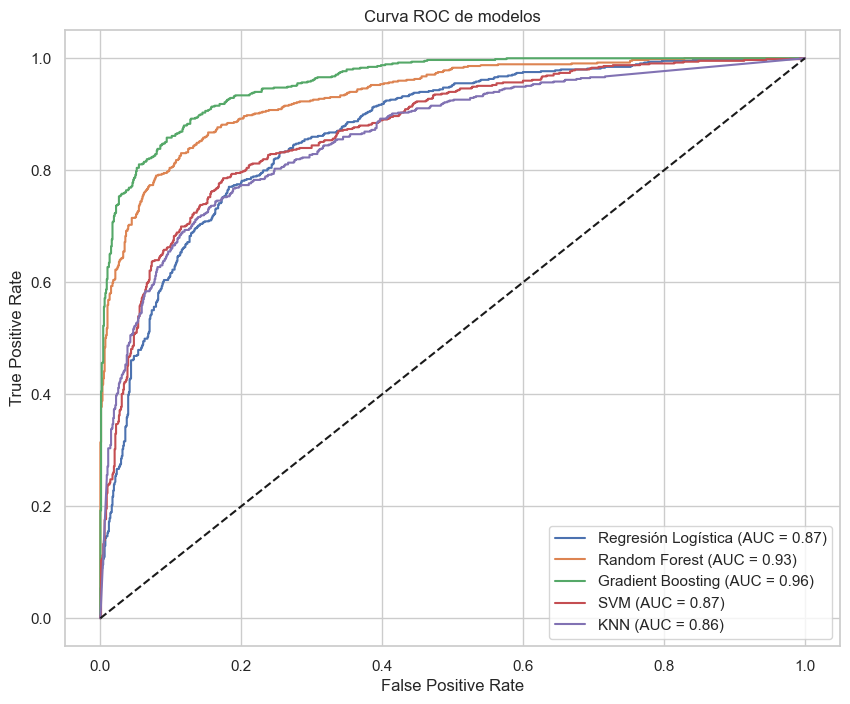

🏆 Mejor modelo:
Modelo: Gradient Boosting
AUC: 0.957
Accuracy: 0.886
Recall: 0.821
F1: 0.851
Mejores Parámetros: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'subsample': 1.0}
Matriz de Confusión:
 [[917  70]
 [116 533]]

🔥 Importancia de variables del mejor modelo:


,Variable,Importancia
15,TotalPagado,0.478830
1,AntiguedadAños,0.223044
30,EstFav_verano,0.091242
16,TienePagos,0.069056
0,Edad,0.045155
28,EstFav_otono,0.028572
17,TotalVisitas,0.022542
29,EstFav_primavera,0.017579
18,VisitasUlt180,0.010367
27,EstFav_invierno,0.003266


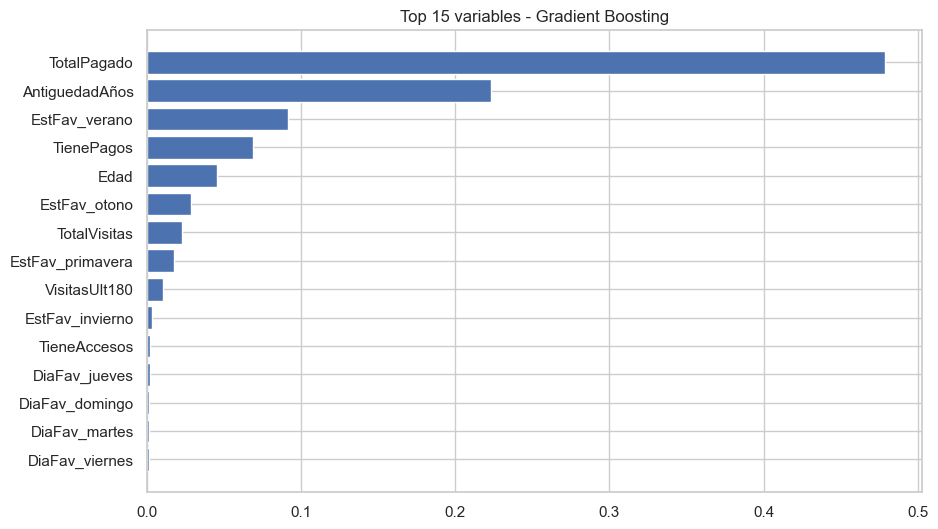

In [42]:
# ==============================
#  Librerías

import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_auc_score, accuracy_score, f1_score, recall_score,
                             confusion_matrix, roc_curve, auc)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns

# ==============================
#  Split de datos y escalado

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ==============================
#  Modelos y grids

modelos = {
    "Regresión Logística": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier()
}

param_grids = {
    "Regresión Logística": {"C": [0.01, 0.1, 1, 10], "penalty": ["l2"], "solver": ["lbfgs"]},
    "Random Forest": {"n_estimators": [100,200], "max_depth": [None,5,10], 
                      "min_samples_split": [2,5], "min_samples_leaf": [1,2]},
    "Gradient Boosting": {"n_estimators": [100,200], "learning_rate": [0.01,0.05,0.1], 
                          "max_depth": [2,3,4], "subsample": [0.8,1.0]},
    "SVM": {"C": [0.1,1,10], "kernel": ["rbf","poly"], "gamma": ["scale","auto"]},
    "KNN": {"n_neighbors": [3,5,7,9], "weights": ["uniform","distance"]}
}

# ==============================
#  Entrenamiento, evaluación y resultados

resultados = []

plt.figure(figsize=(10,8))

for i, (nombre, modelo) in enumerate(modelos.items(),1):
    print(f"\n🔍 Optimizando {nombre}...")
    start = time.time()
    
    grid = GridSearchCV(estimator=modelo, param_grid=param_grids[nombre], 
                        scoring='roc_auc', cv=5, n_jobs=-1, verbose=0)
    grid.fit(X_train_scaled, y_train)
    tiempo = round(time.time() - start,2)
    
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    y_prob = best_model.predict_proba(X_test_scaled)[:,1] if hasattr(best_model, "predict_proba") else None
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    
    # ROC curve
    if y_prob is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{nombre} (AUC = {roc_auc:.2f})')
    else:
        roc_auc = None

    resultados.append({
        "Modelo": nombre,
        "Mejores Parámetros": grid.best_params_,
        "AUC": roc_auc,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "Matriz Confusión": cm,
        "Tiempo (s)": tiempo,
        "Best_Model": best_model  # guardamos el objeto entrenado
    })

# ==============================
#  Resultados en DataFrame

df_resultados = pd.DataFrame(resultados).sort_values(by="AUC", ascending=False)
display(df_resultados)

# ==============================
#  Gráfico ROC de todos los modelos

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC de modelos")
plt.legend(loc="lower right")
plt.show()

# ==============================
# Mejor modelo según AUC

mejor_modelo = df_resultados.iloc[0]
best_model = mejor_modelo["Best_Model"]

print("🏆 Mejor modelo:")
print("Modelo:", mejor_modelo["Modelo"])
print("AUC:", round(mejor_modelo["AUC"],3))
print("Accuracy:", round(mejor_modelo["Accuracy"],3))
print("Recall:", round(mejor_modelo["Recall"],3))
print("F1:", round(mejor_modelo["F1"],3))
print("Mejores Parámetros:", mejor_modelo["Mejores Parámetros"])
print("Matriz de Confusión:\n", mejor_modelo["Matriz Confusión"])

# ==============================
# Importancia de variables solo si aplica

if hasattr(best_model, "feature_importances_"):
    importances = pd.DataFrame({
        'Variable': X_train.columns,
        'Importancia': best_model.feature_importances_
    }).sort_values(by='Importancia', ascending=False)

    print("\n🔥 Importancia de variables del mejor modelo:")
    display(importances)

    plt.figure(figsize=(10,6))
    plt.barh(importances['Variable'][:15], importances['Importancia'][:15])
    plt.gca().invert_yaxis()
    plt.title(f"Top 15 variables - {mejor_modelo['Modelo']}")
    plt.show()
else:
    print("\n⚠️ Este modelo no tiene atributo 'feature_importances_'")


In [ ]:
X = df[['Edad', 'AntiguedadAños', 'Sexo_Mujer', 'Importe_total_pagado_servicios',
        'Cantidad_total_pagado_servicios', 'TipoServicio_ENTRENAMENTS PERSONALS',
        'TipoServicio_FISIOTERÀPIA',
        'TipoServicio_NUTRICIÓ',
        'UsoServiciosExtra','ratio_importe_2025_2024',
        'ratio_cantidad_2025_2024',
        'Uso_entrenamientos_personales',
        'Uso_fisioterapia',
        'Uso_nutricion',
        'Diversidad_servicios_extra','TotalPagado', 

        'TienePagos', 'TotalVisitas','VisitasUlt180', 'TieneAccesos',


        'VisitasPorSemana',
        'VisitasPorMes',
        'DiaFav_domingo',
        'DiaFav_jueves',
        'DiaFav_lunes',
        'DiaFav_martes',
        'DiaFav_miércoles',
        'DiaFav_sábado',
        'DiaFav_viernes',
        'EstFav_invierno',
        'EstFav_otono',
        'EstFav_primavera',
        'EstFav_verano',
        
        
        ]]

y = df['Churn']


🔍 Optimizando Regresión Logística...

🔍 Optimizando Random Forest...

🔍 Optimizando Gradient Boosting...

🔍 Optimizando SVM...

🔍 Optimizando KNN...


,Modelo,Mejores Parámetros,AUC,Accuracy,Recall,F1,Matriz Confusión,Tiempo (s),Best_Model
2,Gradient Boosting,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",0.958774,0.886919,0.825886,0.852824,"[[915, 72], [113, 536]]",42.80,([DecisionTreeRegressor(criterion='friedman_ms...
1,Random Forest,"{'max_depth': None, 'min_samples_leaf': 2, 'mi...",0.934251,0.864914,0.764253,0.817807,"[[919, 68], [153, 496]]",14.73,"(DecisionTreeClassifier(max_features='sqrt', m..."
3,SVM,"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}",0.875293,0.811736,0.741140,0.757480,"[[847, 140], [168, 481]]",60.24,"SVC(C=10, probability=True, random_state=42)"
0,Regresión Logística,"{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}",0.868723,0.789120,0.728814,0.732765,"[[818, 169], [176, 473]]",5.40,"LogisticRegression(C=1, max_iter=1000, random_..."
4,KNN,"{'n_neighbors': 9, 'weights': 'distance'}",0.857586,0.802567,0.728814,0.745469,"[[840, 147], [176, 473]]",0.75,"KNeighborsClassifier(n_neighbors=9, weights='d..."


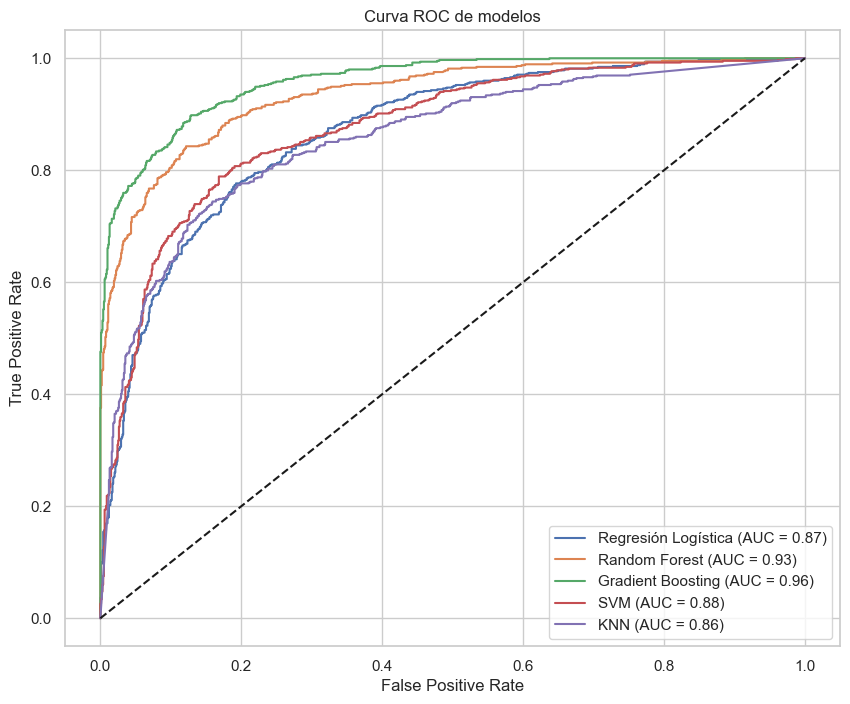

🏆 Mejor modelo:
Modelo: Gradient Boosting
AUC: 0.959
Accuracy: 0.887
Recall: 0.826
F1: 0.853
Mejores Parámetros: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.8}
Matriz de Confusión:
 [[915  72]
 [113 536]]

🔥 Importancia de variables del mejor modelo:


,Variable,Importancia
15,TotalPagado,0.453480
1,AntiguedadAños,0.221284
32,EstFav_verano,0.085196
16,TienePagos,0.064748
0,Edad,0.053721
30,EstFav_otono,0.026460
17,TotalVisitas,0.024090
20,VisitasPorSemana,0.017566
31,EstFav_primavera,0.014639
21,VisitasPorMes,0.012966


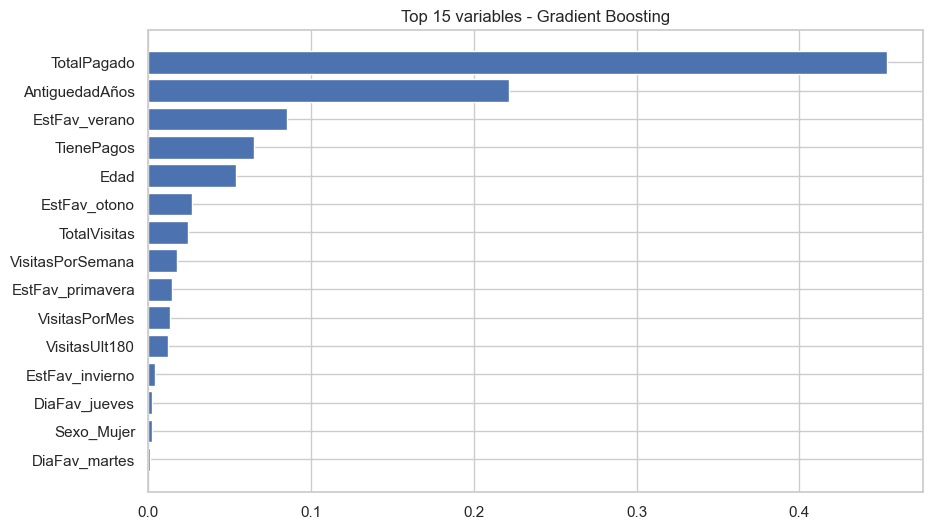

In [44]:
# ==============================
#  Librerías

import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_auc_score, accuracy_score, f1_score, recall_score,
                             confusion_matrix, roc_curve, auc)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns

# ==============================
#  Split de datos y escalado

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ==============================
#  Modelos y grids

modelos = {
    "Regresión Logística": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier()
}

param_grids = {
    "Regresión Logística": {"C": [0.01, 0.1, 1, 10], "penalty": ["l2"], "solver": ["lbfgs"]},
    "Random Forest": {"n_estimators": [100,200], "max_depth": [None,5,10], 
                      "min_samples_split": [2,5], "min_samples_leaf": [1,2]},
    "Gradient Boosting": {"n_estimators": [100,200], "learning_rate": [0.01,0.05,0.1], 
                          "max_depth": [2,3,4], "subsample": [0.8,1.0]},
    "SVM": {"C": [0.1,1,10], "kernel": ["rbf","poly"], "gamma": ["scale","auto"]},
    "KNN": {"n_neighbors": [3,5,7,9], "weights": ["uniform","distance"]}
}

# ==============================
#  Entrenamiento, evaluación y resultados

resultados = []

plt.figure(figsize=(10,8))

for i, (nombre, modelo) in enumerate(modelos.items(),1):
    print(f"\n🔍 Optimizando {nombre}...")
    start = time.time()
    
    grid = GridSearchCV(estimator=modelo, param_grid=param_grids[nombre], 
                        scoring='roc_auc', cv=5, n_jobs=-1, verbose=0)
    grid.fit(X_train_scaled, y_train)
    tiempo = round(time.time() - start,2)
    
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    y_prob = best_model.predict_proba(X_test_scaled)[:,1] if hasattr(best_model, "predict_proba") else None
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    
    # ROC curve
    if y_prob is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{nombre} (AUC = {roc_auc:.2f})')
    else:
        roc_auc = None

    resultados.append({
        "Modelo": nombre,
        "Mejores Parámetros": grid.best_params_,
        "AUC": roc_auc,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "Matriz Confusión": cm,
        "Tiempo (s)": tiempo,
        "Best_Model": best_model  # guardamos el objeto entrenado
    })

# ==============================
#  Resultados en DataFrame

df_resultados = pd.DataFrame(resultados).sort_values(by="AUC", ascending=False)
display(df_resultados)

# ==============================
#  Gráfico ROC de todos los modelos

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC de modelos")
plt.legend(loc="lower right")
plt.show()

# ==============================
# Mejor modelo según AUC

mejor_modelo = df_resultados.iloc[0]
best_model = mejor_modelo["Best_Model"]

print("🏆 Mejor modelo:")
print("Modelo:", mejor_modelo["Modelo"])
print("AUC:", round(mejor_modelo["AUC"],3))
print("Accuracy:", round(mejor_modelo["Accuracy"],3))
print("Recall:", round(mejor_modelo["Recall"],3))
print("F1:", round(mejor_modelo["F1"],3))
print("Mejores Parámetros:", mejor_modelo["Mejores Parámetros"])
print("Matriz de Confusión:\n", mejor_modelo["Matriz Confusión"])

# ==============================
# Importancia de variables solo si aplica

if hasattr(best_model, "feature_importances_"):
    importances = pd.DataFrame({
        'Variable': X_train.columns,
        'Importancia': best_model.feature_importances_
    }).sort_values(by='Importancia', ascending=False)

    print("\n🔥 Importancia de variables del mejor modelo:")
    display(importances)

    plt.figure(figsize=(10,6))
    plt.barh(importances['Variable'][:15], importances['Importancia'][:15])
    plt.gca().invert_yaxis()
    plt.title(f"Top 15 variables - {mejor_modelo['Modelo']}")
    plt.show()
else:
    print("\n⚠️ Este modelo no tiene atributo 'feature_importances_'")


In [45]:
X = df[['Edad', 'AntiguedadAños', 'Sexo_Mujer', 'Importe_total_pagado_servicios',
        'Cantidad_total_pagado_servicios', 'TipoServicio_ENTRENAMENTS PERSONALS',
        'TipoServicio_FISIOTERÀPIA',
        'TipoServicio_NUTRICIÓ',
        'UsoServiciosExtra','ratio_importe_2025_2024',
        'ratio_cantidad_2025_2024',
        'Uso_entrenamientos_personales',
        'Uso_fisioterapia',
        'Uso_nutricion',
        'Diversidad_servicios_extra','TotalPagado', 
        'TienePagos', 'TotalVisitas','VisitasUlt180', 'TieneAccesos',
        'VisitasPorSemana',
        'VisitasPorMes',
        'DiaFav_domingo',
        'DiaFav_jueves',
        'DiaFav_lunes',
        'DiaFav_martes',
        'DiaFav_miércoles',
        'DiaFav_sábado',
        'DiaFav_viernes',
        'EstFav_invierno',
        'EstFav_otono',
        'EstFav_primavera',
        'EstFav_verano',
        
        'NumCambiosAbono',
        'TendenciaPago',
        'TendenciaPagoMismoAbono',
        'NumImpagosReales',
        'NumReactivaciones',

        
        ]]

y = df['Churn']


🔍 Optimizando Regresión Logística...

🔍 Optimizando Random Forest...

🔍 Optimizando Gradient Boosting...

🔍 Optimizando SVM...

🔍 Optimizando KNN...


,Modelo,Mejores Parámetros,AUC,Accuracy,Recall,F1,Matriz Confusión,Tiempo (s),Best_Model
2,Gradient Boosting,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",0.966529,0.907090,0.850539,0.878981,"[[932, 55], [97, 552]]",52.93,([DecisionTreeRegressor(criterion='friedman_ms...
1,Random Forest,"{'max_depth': None, 'min_samples_leaf': 2, 'mi...",0.958946,0.893032,0.822804,0.859212,"[[927, 60], [115, 534]]",16.13,"(DecisionTreeClassifier(max_features='sqrt', m..."
3,SVM,"{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}",0.887317,0.831296,0.781202,0.786047,"[[853, 134], [142, 507]]",75.79,"SVC(C=10, gamma='auto', probability=True, rand..."
0,Regresión Logística,"{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}",0.875808,0.801345,0.742681,0.747867,"[[829, 158], [167, 482]]",4.99,"LogisticRegression(C=1, max_iter=1000, random_..."
4,KNN,"{'n_neighbors': 9, 'weights': 'distance'}",0.869963,0.805623,0.730354,0.748815,"[[844, 143], [175, 474]]",0.72,"KNeighborsClassifier(n_neighbors=9, weights='d..."


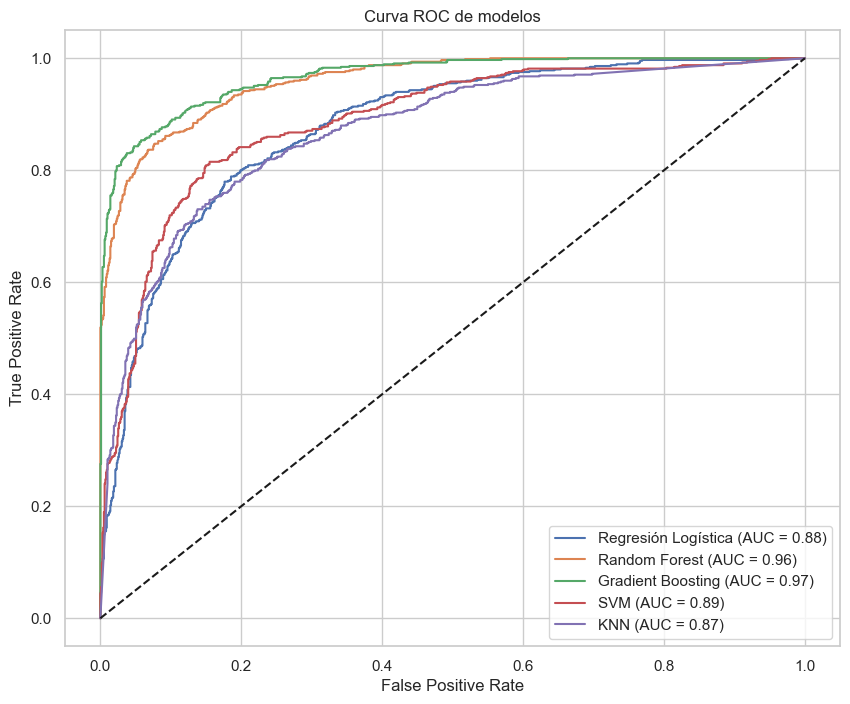

🏆 Mejor modelo:
Modelo: Gradient Boosting
AUC: 0.967
Accuracy: 0.907
Recall: 0.851
F1: 0.879
Mejores Parámetros: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.8}
Matriz de Confusión:
 [[932  55]
 [ 97 552]]

🔥 Importancia de variables del mejor modelo:


,Variable,Importancia
15,TotalPagado,0.394191
1,AntiguedadAños,0.177969
32,EstFav_verano,0.084441
35,TendenciaPagoMismoAbono,0.072615
34,TendenciaPago,0.062195
16,TienePagos,0.058044
0,Edad,0.031742
36,NumImpagosReales,0.025899
17,TotalVisitas,0.018241
31,EstFav_primavera,0.013226


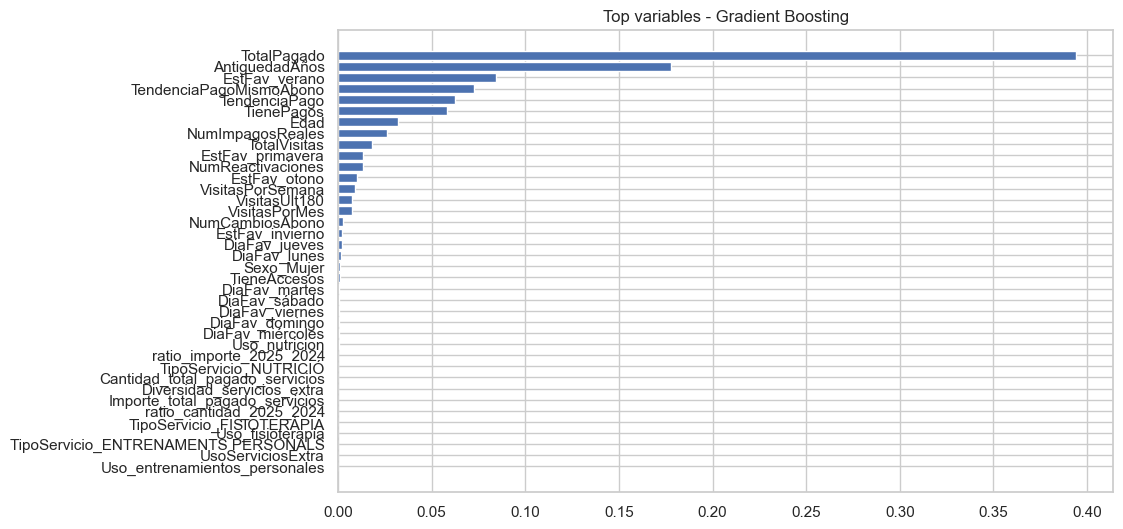

In [46]:
# ==============================
#  Librerías

import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_auc_score, accuracy_score, f1_score, recall_score,
                             confusion_matrix, roc_curve, auc)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns

# ==============================
#  Split de datos y escalado

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ==============================
#  Modelos y grids

modelos = {
    "Regresión Logística": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier()
}

param_grids = {
    "Regresión Logística": {"C": [0.01, 0.1, 1, 10], "penalty": ["l2"], "solver": ["lbfgs"]},
    "Random Forest": {"n_estimators": [100,200], "max_depth": [None,5,10], 
                      "min_samples_split": [2,5], "min_samples_leaf": [1,2]},
    "Gradient Boosting": {"n_estimators": [100,200], "learning_rate": [0.01,0.05,0.1], 
                          "max_depth": [2,3,4], "subsample": [0.8,1.0]},
    "SVM": {"C": [0.1,1,10], "kernel": ["rbf","poly"], "gamma": ["scale","auto"]},
    "KNN": {"n_neighbors": [3,5,7,9], "weights": ["uniform","distance"]}
}

# ==============================
#  Entrenamiento, evaluación y resultados

resultados = []

plt.figure(figsize=(10,8))

for i, (nombre, modelo) in enumerate(modelos.items(),1):
    print(f"\n🔍 Optimizando {nombre}...")
    start = time.time()
    
    grid = GridSearchCV(estimator=modelo, param_grid=param_grids[nombre], 
                        scoring='roc_auc', cv=5, n_jobs=-1, verbose=0)
    grid.fit(X_train_scaled, y_train)
    tiempo = round(time.time() - start,2)
    
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    y_prob = best_model.predict_proba(X_test_scaled)[:,1] if hasattr(best_model, "predict_proba") else None
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    
    # ROC curve
    if y_prob is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{nombre} (AUC = {roc_auc:.2f})')
    else:
        roc_auc = None

    resultados.append({
        "Modelo": nombre,
        "Mejores Parámetros": grid.best_params_,
        "AUC": roc_auc,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "Matriz Confusión": cm,
        "Tiempo (s)": tiempo,
        "Best_Model": best_model  # guardamos el objeto entrenado
    })

# ==============================
#  Resultados en DataFrame

df_resultados = pd.DataFrame(resultados).sort_values(by="AUC", ascending=False)
display(df_resultados)

# ==============================
#  Gráfico ROC de todos los modelos

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC de modelos")
plt.legend(loc="lower right")
plt.show()

# ==============================
# Mejor modelo según AUC

mejor_modelo = df_resultados.iloc[0]
best_model = mejor_modelo["Best_Model"]

print("🏆 Mejor modelo:")
print("Modelo:", mejor_modelo["Modelo"])
print("AUC:", round(mejor_modelo["AUC"],3))
print("Accuracy:", round(mejor_modelo["Accuracy"],3))
print("Recall:", round(mejor_modelo["Recall"],3))
print("F1:", round(mejor_modelo["F1"],3))
print("Mejores Parámetros:", mejor_modelo["Mejores Parámetros"])
print("Matriz de Confusión:\n", mejor_modelo["Matriz Confusión"])

# ==============================
# Importancia de variables solo si aplica

if hasattr(best_model, "feature_importances_"):
    importances = pd.DataFrame({
        'Variable': X_train.columns,
        'Importancia': best_model.feature_importances_
    }).sort_values(by='Importancia', ascending=False)

    print("\n🔥 Importancia de variables del mejor modelo:")
    display(importances)

    plt.figure(figsize=(10,6))
    plt.barh(importances['Variable'][:], importances['Importancia'][:])
    plt.gca().invert_yaxis()
    plt.title(f"Top variables - {mejor_modelo['Modelo']}")
    plt.show()
else:
    print("\n⚠️ Este modelo no tiene atributo 'feature_importances_'")



🔥 Importancia de variables del mejor modelo (solo >0):


,Variable,Importancia
15,TotalPagado,0.394191
1,AntiguedadAños,0.177969
32,EstFav_verano,0.084441
35,TendenciaPagoMismoAbono,0.072615
34,TendenciaPago,0.062195
16,TienePagos,0.058044
0,Edad,0.031742
36,NumImpagosReales,0.025899
17,TotalVisitas,0.018241
31,EstFav_primavera,0.013226


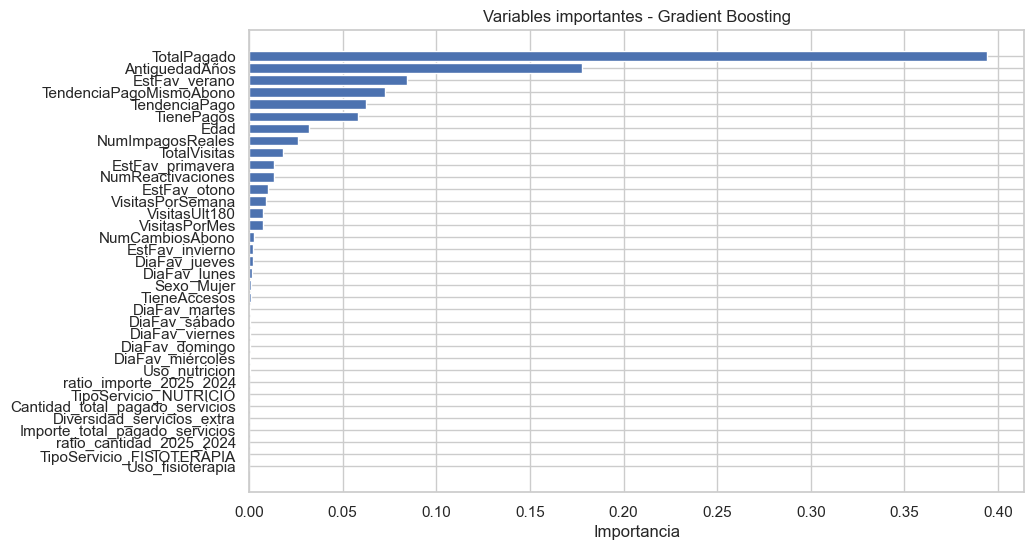

In [47]:
# Importancia de variables solo si aplica
if hasattr(best_model, "feature_importances_"):
    importances = pd.DataFrame({
        'Variable': X_train.columns,
        'Importancia': best_model.feature_importances_
    })

    # Filtrar solo variables con importancia > 0
    importances = importances[importances['Importancia'] > 0].sort_values(by='Importancia', ascending=False)

    print("\n🔥 Importancia de variables del mejor modelo (solo >0):")
    display(importances)

    # Gráfico
    plt.figure(figsize=(10,6))
    plt.barh(importances['Variable'], importances['Importancia'])
    plt.gca().invert_yaxis()
    plt.title(f"Variables importantes - {mejor_modelo['Modelo']}")
    plt.xlabel("Importancia")
    plt.show()
else:
    print("\n⚠️ Este modelo no tiene atributo 'feature_importances_'")

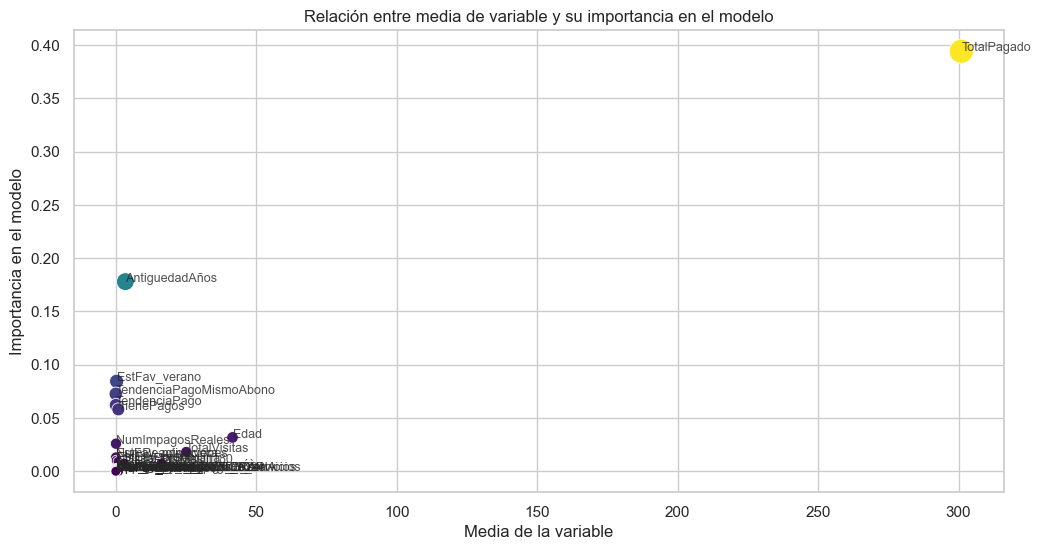

In [48]:
# Filtramos solo variables con importancia > 0
importances = importances[importances['Importancia'] > 0].copy()

# Calculamos media de cada variable en X_train
importances['Media'] = [X_train[col].mean() for col in importances['Variable']]

# Scatter plot: Media vs Importancia
plt.figure(figsize=(12,6))
sns.scatterplot(data=importances, x='Media', y='Importancia', hue='Importancia', 
                palette='viridis', size='Importancia', sizes=(50,300), legend=False)

for i, row in importances.iterrows():
    plt.text(row['Media'], row['Importancia'], row['Variable'], fontsize=9, alpha=0.8)

plt.xlabel("Media de la variable")
plt.ylabel("Importancia en el modelo")
plt.title("Relación entre media de variable y su importancia en el modelo")
plt.show()

In [50]:
# ==============================
# Predicción en todo el dataset original

# Seleccionamos las mismas columnas de X que usamos para entrenar
X_full_scaled = scaler.transform(X)  # escalado usando el mismo StandardScaler

# Predicciones
y_pred_full = best_model.predict(X_full_scaled)
y_prob_full = best_model.predict_proba(X_full_scaled)[:,1] if hasattr(best_model, "predict_proba") else None

# Creamos DataFrame con resultados
df_predicciones = pd.DataFrame({
    'IdPersona': df['IdPersona'],
    'Sexo_Mujer': df['Sexo_Mujer'],
    'Edad': df['Edad'],
    'AntiguedadAños': df['AntiguedadAños'],
    'TipoUltimoAbono': df['TipoUltimoAbono'],
    'Churn_Real': df['Churn'],
    'Churn_Predicho': y_pred_full,
    'Prob_Churn': y_prob_full
})

# Opcional: si quieres, puedes añadir columnas extra que tengas
# df_predicciones['TotalPagado'] = df['TotalPagado']
# df_predicciones['TotalVisitas'] = df['TotalVisitas']

# Mostramos los primeros registros
display(df_predicciones)

,IdPersona,Sexo_Mujer,Edad,AntiguedadAños,TipoUltimoAbono,Churn_Real,Churn_Predicho,Prob_Churn
0,334,False,82.0,69.81,AVET,False,False,0.153481
1,452,False,85.0,69.00,AVET,False,False,0.044148
2,642,False,77.0,67.54,AVET,False,False,0.044780
3,849,False,85.0,67.12,CL04,False,False,0.479682
4,891,False,78.0,66.70,AVET,False,False,0.044780
...,...,...,...,...,...,...,...,...
8180,116944,True,11.0,1.10,FA00,True,True,0.699278
8181,116981,False,17.0,0.09,AM00,True,True,0.939634
8182,116987,False,23.0,0.08,JO00,True,True,0.878503
8183,116996,False,17.0,1.00,AM00,True,True,0.702897


In [53]:
pd.set_option('display.max_rows', None)

In [56]:
df_predicciones[df_predicciones['Churn_Real']==False].head(5)

,IdPersona,Sexo_Mujer,Edad,AntiguedadAños,TipoUltimoAbono,Churn_Real,Churn_Predicho,Prob_Churn
0,334,False,82.0,69.81,AVET,False,False,0.153481
1,452,False,85.0,69.00,AVET,False,False,0.044148
2,642,False,77.0,67.54,AVET,False,False,0.044780
3,849,False,85.0,67.12,CL04,False,False,0.479682
4,891,False,78.0,66.70,AVET,False,False,0.044780


In [59]:
# Aseguramos que existan probabilidades
if 'Prob_Churn' not in df_predicciones or df_predicciones['Prob_Churn'].isnull().all():
    print("No hay probabilidades disponibles para clasificar el riesgo")
else:
    # 5 niveles de riesgo: Muy Bajo, Bajo, Medio, Alto, Muy Alto
    bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    labels = ['Muy Bajo', 'Bajo', 'Medio', 'Alto', 'Muy Alto']

    df_predicciones['Nivel_Riesgo'] = pd.cut(df_predicciones['Prob_Churn'], bins=bins, labels=labels, include_lowest=True)

    # Mostramos algunos resultados
    display(df_predicciones[['IdPersona', 'Churn_Real', 'Churn_Predicho', 'Prob_Churn', 'Nivel_Riesgo']].head())


,IdPersona,Churn_Real,Churn_Predicho,Prob_Churn,Nivel_Riesgo
0,334,False,False,0.153481,Muy Bajo
1,452,False,False,0.044148,Muy Bajo
2,642,False,False,0.044780,Muy Bajo
3,849,False,False,0.479682,Medio
4,891,False,False,0.044780,Muy Bajo


In [78]:
df_activos= df_predicciones[df_predicciones['Churn_Real']==False]
df_activos.shape

(4932, 9)

In [71]:
df_noactivos= df_predicciones[df_predicciones['Churn_Real']!=False]

In [79]:
# Estadísticas básicas de churn real y predicho por nivel de riesgo
resumen_riesgo = df_activos.groupby('Nivel_Riesgo').agg(
    Cantidad=('IdPersona','count'),
    Churn_Real_Promedio=('Churn_Real','mean'),
    Churn_Predicho_Promedio=('Churn_Predicho','mean'),
    Prob_Churn_Promedio=('Prob_Churn','mean')
).reset_index()

display(resumen_riesgo)

,Nivel_Riesgo,Cantidad,Churn_Real_Promedio,Churn_Predicho_Promedio,Prob_Churn_Promedio
0,Muy Bajo,4191,0.0,0.000000,0.047215
1,Bajo,466,0.0,0.000000,0.275986
2,Medio,176,0.0,0.443182,0.494479
3,Alto,65,0.0,1.000000,0.687768
4,Muy Alto,34,0.0,1.000000,0.863399


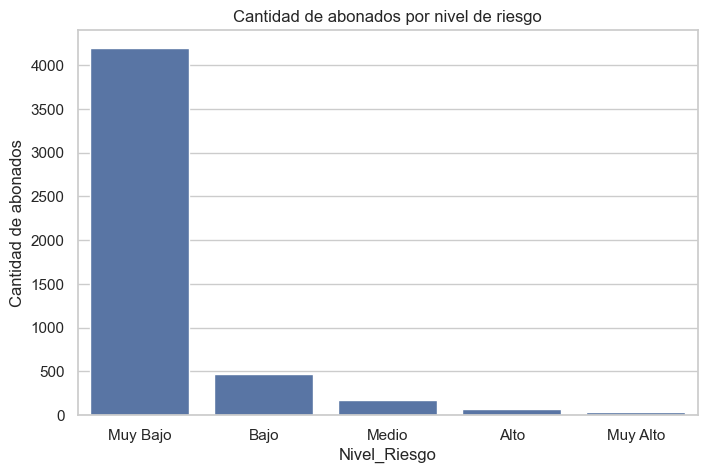

In [77]:
plt.figure(figsize=(8,5))
sns.countplot(data=df_activos, x='Nivel_Riesgo', order=['Muy Bajo','Bajo','Medio','Alto','Muy Alto'])
plt.title("Cantidad de abonados por nivel de riesgo")
plt.ylabel("Cantidad de abonados")
plt.show()

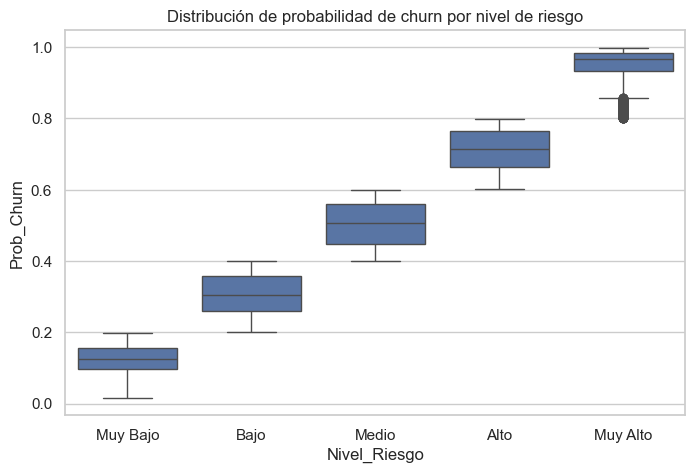

In [74]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df_noactivos, x='Nivel_Riesgo', y='Prob_Churn', order=['Muy Bajo','Bajo','Medio','Alto','Muy Alto'])
plt.title("Distribución de probabilidad de churn por nivel de riesgo")
plt.show()

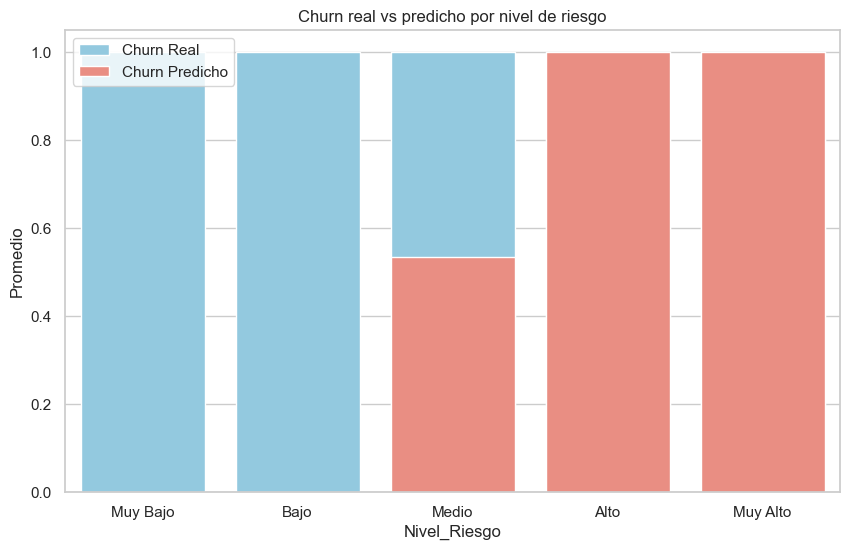

In [75]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=df_noactivos.groupby('Nivel_Riesgo')[['Churn_Real','Churn_Predicho']].mean().reset_index(),
    x='Nivel_Riesgo', y='Churn_Real', color='skyblue', label='Churn Real'
)
sns.barplot(
    data=df_noactivos.groupby('Nivel_Riesgo')[['Churn_Real','Churn_Predicho']].mean().reset_index(),
    x='Nivel_Riesgo', y='Churn_Predicho', color='salmon', label='Churn Predicho'
)
plt.title("Churn real vs predicho por nivel de riesgo")
plt.ylabel("Promedio")
plt.legend()
plt.show()

In [129]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import pandas as pd

# Escalado (recomendado para modelos basados en distancia o gradiente)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelos a comparar
modelos = {
    "Regresión Logística": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

resultados = []

# Entrenar y evaluar cada modelo
for nombre, modelo in modelos.items():
    modelo.fit(X_train_scaled, y_train)
    y_pred = modelo.predict(X_test_scaled)
    y_prob = modelo.predict_proba(X_test_scaled)[:, 1] if hasattr(modelo, "predict_proba") else None
    
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    resultados.append({
        "Modelo": nombre,
        "Accuracy": acc,
        "F1": f1,
        "AUC": auc
    })

# Tabla resumen
df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values(by="AUC", ascending=False)
print(df_resultados)

                Modelo  Accuracy        F1       AUC
2    Gradient Boosting  0.909499  0.882540  0.969402
1        Random Forest  0.911129  0.884656  0.968379
3                  SVM  0.835304  0.779956  0.893642
4                  KNN  0.803098  0.747781  0.869972
0  Regresión Logística  0.808806  0.752245  0.866773


In [130]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

param_grids = {
    "Regresión Logística": {
        "C": [0.01, 0.1, 1, 10],
        "penalty": ["l2"],
        "solver": ["lbfgs"]
    },
    "Random Forest": {
        "n_estimators": [100, 200],
        "max_depth": [None, 5, 10],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2]
    },
    "Gradient Boosting": {
        "n_estimators": [100, 200],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [2, 3, 4],
        "subsample": [0.8, 1.0]
    },
    "SVM": {
        "C": [0.1, 1, 10],
        "kernel": ["rbf", "poly"],
        "gamma": ["scale", "auto"]
    },
    "KNN": {
        "n_neighbors": [3, 5, 7, 9],
        "weights": ["uniform", "distance"]
    }
}

In [131]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
import pandas as pd
import time

modelos = {
    "Regresión Logística": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier()
}

resultados = []

for nombre, modelo in modelos.items():
    print(f"\n🔍 Optimizando {nombre}...")
    start = time.time()
    grid = GridSearchCV(
        estimator=modelo,
        param_grid=param_grids[nombre],
        scoring='roc_auc',
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train_scaled, y_train)
    tiempo = time.time() - start

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    y_prob = best_model.predict_proba(X_test_scaled)[:, 1]

    resultados.append({
        "Modelo": nombre,
        "Mejores Parámetros": grid.best_params_,
        "AUC": roc_auc_score(y_test, y_prob),
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "Tiempo (s)": round(tiempo, 2)
    })

df_resultados = pd.DataFrame(resultados).sort_values(by="AUC", ascending=False)
print("\n📈 Resultados finales:")
print(df_resultados)


🔍 Optimizando Regresión Logística...
Fitting 5 folds for each of 4 candidates, totalling 20 fits

🔍 Optimizando Random Forest...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

🔍 Optimizando Gradient Boosting...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

🔍 Optimizando SVM...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

🔍 Optimizando KNN...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

📈 Resultados finales:
                Modelo                                 Mejores Parámetros  \
2    Gradient Boosting  {'learning_rate': 0.1, 'max_depth': 4, 'n_esti...   
1        Random Forest  {'max_depth': None, 'min_samples_leaf': 1, 'mi...   
3                  SVM       {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}   
4                  KNN          {'n_neighbors': 9, 'weights': 'distance'}   
0  Regresión Logística      {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}   

        AUC  Accuracy        F1  Tiempo (s)  
2  0.976217  

In [132]:
df_resultados

,Modelo,Mejores Parámetros,AUC,Accuracy,F1,Tiempo (s)
2,Gradient Boosting,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",0.976217,0.920913,0.897787,41.52
1,Random Forest,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.968379,0.911129,0.884656,13.20
3,SVM,"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}",0.908584,0.845088,0.791209,56.96
4,KNN,"{'n_neighbors': 9, 'weights': 'distance'}",0.888339,0.813698,0.757302,0.76
0,Regresión Logística,"{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}",0.866496,0.808806,0.752245,0.26


                           Variable  Importancia
9                       TotalPagado     0.328643
10                      MediaPagada     0.150700
1                    AntiguedadAños     0.129443
2             MesesDesdeUltimoAbono     0.123129
29                    EstFav_verano     0.084804
17                       TienePagos     0.053097
12                      TotalRecibo     0.032936
0                              Edad     0.022836
18                     TotalVisitas     0.022215
28                 EstFav_primavera     0.016129
27                     EstFav_otono     0.015769
13                     TotalTarjeta     0.004657
26                  EstFav_invierno     0.003651
30                     TieneAccesos     0.002671
11                    TotalMetálico     0.002232
15                       Sexo_Mujer     0.001453
25                   DiaFav_viernes     0.001021
20                    DiaFav_jueves     0.000886
22                    DiaFav_martes     0.000787
21                  

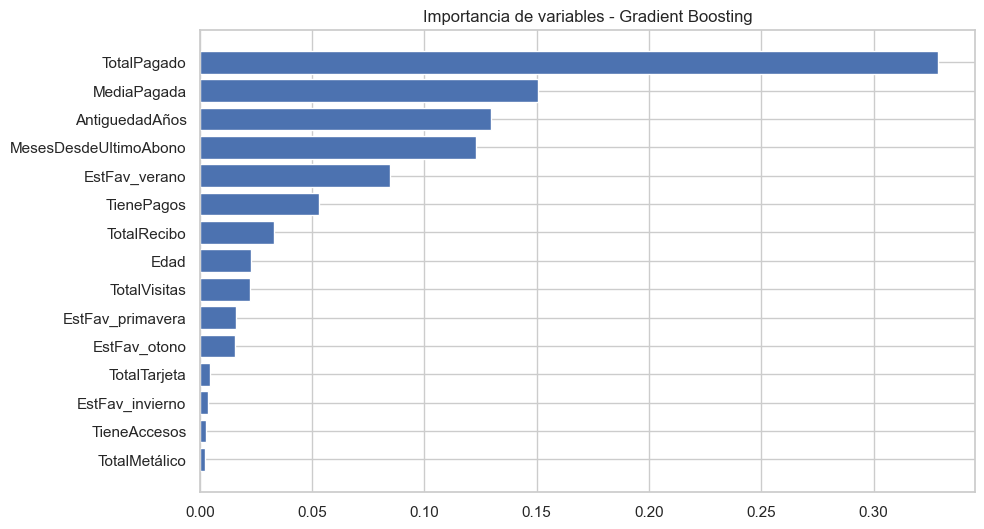

In [134]:
best_gb = GradientBoostingClassifier(
    learning_rate=0.1,
    max_depth=4,
    n_estimators=200,
    subsample=0.8,
    random_state=42
)
best_gb.fit(X_train_scaled, y_train)

import pandas as pd
import matplotlib.pyplot as plt

# Importancia de variables
importances = pd.DataFrame({
    'Variable': X_train.columns,
    'Importancia': best_gb.feature_importances_
}).sort_values(by='Importancia', ascending=False)

print(importances)

# Gráfico
plt.figure(figsize=(10,6))
plt.barh(importances['Variable'][:15], importances['Importancia'][:15])
plt.gca().invert_yaxis()
plt.title("Importancia de variables - Gradient Boosting")
plt.show()

In [135]:
df_test = X_test.copy()
df_test['prob_abandono'] = best_gb.predict_proba(X_test_scaled)[:, 1]

In [136]:
# Crear una segmentación de riesgo
df_test['segmento'] = pd.cut(
    df_test['prob_abandono'],
    bins=[0, 0.3, 0.6, 1],
    labels=['Bajo', 'Medio', 'Alto']
)

# Ver resumen
df_test[[ 'prob_abandono', 'segmento']]

,prob_abandono,segmento
7756,0.908273,Alto
5478,0.908244,Alto
4293,0.218989,Bajo
6515,0.043726,Bajo
6993,0.968837,Alto
...,...,...
779,0.004054,Bajo
4091,0.240542,Bajo
2169,0.530145,Medio
2744,0.023277,Bajo


MÁS VARIABLES

In [141]:
list(df.columns)

['IdPersona',
 'Edad',
 'Sexo_Mujer',
 'Churn',
 'AntiguedadAños',
 'TipoUltimoAbono',
 'Irregularidad_ActivoIrregular',
 'Irregularidad_ActivoRegular',
 'Irregularidad_BajaFinalIrregular',
 'Irregularidad_BajaFinalRegular',
 'MesesDesdeUltimoAbono',
 'Importe_2024_servicios',
 'Cantidad_2024_servicios',
 'Importe_2025_servicios',
 'Cantidad_2025_servicios',
 'Importe_total_pagado_servicios',
 'Cantidad_total_pagado_servicios',
 'Concepto_ENTRENADOR PERSONAL 1 /2 SESSIO ABONAT',
 'Concepto_ENTRENADOR PERSONAL 1 SESSIO',
 'Concepto_ENTRENADOR PERSONAL 1 SESSIÓ ABONAT',
 'Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS)',
 'Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS) ABONAT',
 'Concepto_ENTRENADOR PERSONAL 10 SESSIONS ABONAT',
 'Concepto_ENTRENADOR PERSONAL 5 (30 MINUTS) ABONAT',
 'Concepto_ENTRENADOR PERSONAL 5 SESSIONS ABONAT',
 "Concepto_FISIO ABONAMENT 10 SESSIONS 60' ABONAT",
 "Concepto_FISIO ABONAMENT 5 SESSIONS  30' ABONAT",
 "Concepto_FISIO ABONAMENT 5 SESSIONS  60'  ",
 'Concepto_FIS

In [144]:
df

,IdPersona,Edad,Sexo_Mujer,Churn,AntiguedadAños,TipoUltimoAbono,Irregularidad_ActivoIrregular,Irregularidad_ActivoRegular,Irregularidad_BajaFinalIrregular,Irregularidad_BajaFinalRegular,MesesDesdeUltimoAbono,Importe_2024_servicios,Cantidad_2024_servicios,Importe_2025_servicios,Cantidad_2025_servicios,Importe_total_pagado_servicios,Cantidad_total_pagado_servicios,Concepto_ENTRENADOR PERSONAL 1 /2 SESSIO ABONAT,Concepto_ENTRENADOR PERSONAL 1 SESSIO,Concepto_ENTRENADOR PERSONAL 1 SESSIÓ ABONAT,Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS),Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS) ABONAT,Concepto_ENTRENADOR PERSONAL 10 SESSIONS ABONAT,Concepto_ENTRENADOR PERSONAL 5 (30 MINUTS) ABONAT,Concepto_ENTRENADOR PERSONAL 5 SESSIONS ABONAT,Concepto_FISIO ABONAMENT 10 SESSIONS 60' ABONAT,Concepto_FISIO ABONAMENT 5 SESSIONS 30' ABONAT,Concepto_FISIO ABONAMENT 5 SESSIONS 60',Concepto_FISIO PACK BENVINGUDA,Concepto_FISIOTERÀPIA 60' ABONAT,Concepto_FISIOTERÀPIA 30' ABONAT,Concepto_NUTRI ANTROPOMETRIA,Concepto_NUTRI ANTROPOMETRIA ABONAT,Concepto_NUTRI PACK 3 SEGUIMENTS ABONAT,Concepto_NUTRI VISITA DE SEGUIMENT ABONAT,Concepto_PACK 3 SEGUIMENTS ABONAT,Concepto_PACK NUTRICIÓ (2 VISITES) ABONAT,TipoServicio_ENTRENAMENTS PERSONALS,TipoServicio_FISIOTERÀPIA,TipoServicio_NUTRICIÓ,Total_conceptos_unicos,Total_tipos_servicios_unicos,UsoServiciosExtra,NumRenovaciones,NumTiposAbono,TotalPagado,MediaPagada,TotalMetálico,TotalRecibo,TotalTarjeta,TotalTransferencia,CambioAbono,RatioMesesPagados,CefVarImporte,MesesDesdeUltimoPago,MesesDesdePrimerPago,DuracionRenovacionMeses,FormaPagoMayoritaria,TipoAbonoInicial,TipoAbonoFinal,TotalAbono_AA0,TotalAbono_AA00,TotalAbono_AA03,TotalAbono_AA12,TotalAbono_AC00,TotalAbono_AC03,TotalAbono_AF00,TotalAbono_AF03,TotalAbono_AG00,TotalAbono_AG03,TotalAbono_AG12,TotalAbono_AM00,TotalAbono_AM03,TotalAbono_AP00,TotalAbono_AP03,TotalAbono_AR00,TotalAbono_AR03,TotalAbono_AR12,TotalAbono_AT00,TotalAbono_AT01,TotalAbono_AVET,TotalAbono_CL04,TotalAbono_CR01,TotalAbono_CR03,TotalAbono_EMPF,TotalAbono_FA00,TotalAbono_FA12,TotalAbono_FM01,TotalAbono_JO00,TotalAbono_JO03,TotalAbono_MA00,TotalAbono_MA03,TotalAbono_MA06,TotalAbono_MA12,TotalAbono_NI00,TotalAbono_QM01,TotalAbono_QM03,TotalAbono_TEMP,TotalAbono_VIP,TipoAbonoFrecuente,NumCambiosAbono,TendenciaPago,TendenciaPagoMismoAbono,NumImpagosReales,NumReactivaciones,TienePagos,PagoSinSaltos_irregular,PagoSinSaltos_no_aplica,PagoSinSaltos_regular,TotalVisitas,DiasActivo,VisitasPorSemana,VisitasPorMes,MaxVisitasDia,VarVisitasMes,DuracionMediaTotal,DuracionStdTotal,DuracionMediaUlt90,DeltaDuracionUlt90VsTotal,PropVisitasLargas,VisitasUlt30,VisitasUlt90,VisitasUlt180,PropUlt90,DiasDesdeUltima,DiasHastaPrimera,StdDiasEntreVisitas,FrecuenciaModal,SemanasConVisita,SemanasTotales,SemanasConUnaVisita,MaxRachaSinVisita,MaxRachaConVisita,HoraMediaAcceso,HoraStdAcceso,VarDiasSemana,PropFindesemana,PropPrimavera,PropVerano,PropOtono,PropInvierno,VisitasFestivos,PropVisitasFestivos,VisitasFindesemana,PropVisitasFindesemana,VisitasCerrado,PropVisitasCerrado,VisitasRed9a14,PropVisitasRed9a14,VisitasRed7a20,PropVisitasRed7a20,VisitasRed7a15,PropVisitasRed7a15,TiempoActivoDias,VisitasPrimerTrimestre,VisitasUltimoTrimestre,DiaFav_domingo,DiaFav_jueves,DiaFav_lunes,DiaFav_martes,DiaFav_miércoles,DiaFav_sábado,DiaFav_viernes,EstFav_invierno,EstFav_otono,EstFav_primavera,EstFav_verano,TieneAccesos,Edad_bin
0,334,82.0,False,0,69.81,AVET,True,False,False,False,175.9,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,False,2.0,1.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.166667,0.0,1.0,7.0,5.946124,Metálico,AVET,AVET,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AVET,0.0,0.0,0.0,1.0,0.0,True,True,False,False,3.0,3.0,1.500000,2.432432,1.0,0.00,50.422222,8.675597,50.422222,0.0,0.333333,3.0,3.0,3.0,1

In [180]:
X = df[['Edad', 'AntiguedadAños', 'MesesDesdeUltimoAbono',
        'Importe_2024_servicios','Cantidad_2024_servicios',
        'Importe_2025_servicios','Cantidad_2025_servicios',
        'Importe_total_pagado_servicios','Cantidad_total_pagado_servicios', 'Concepto_ENTRENADOR PERSONAL 1 /2 SESSIO ABONAT',
 'Concepto_ENTRENADOR PERSONAL 1 SESSIO',
 'Concepto_ENTRENADOR PERSONAL 1 SESSIÓ ABONAT',
 'Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS)',
 'Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS) ABONAT',
 'Concepto_ENTRENADOR PERSONAL 10 SESSIONS ABONAT',
 'Concepto_ENTRENADOR PERSONAL 5 (30 MINUTS) ABONAT',
 'Concepto_ENTRENADOR PERSONAL 5 SESSIONS ABONAT',
 "Concepto_FISIO ABONAMENT 10 SESSIONS 60' ABONAT",
 "Concepto_FISIO ABONAMENT 5 SESSIONS  30' ABONAT",
 "Concepto_FISIO ABONAMENT 5 SESSIONS  60'  ",
 'Concepto_FISIO PACK BENVINGUDA',
 "Concepto_FISIOTERÀPIA  60' ABONAT",
 "Concepto_FISIOTERÀPIA 30' ABONAT",
 'Concepto_NUTRI ANTROPOMETRIA',
 'Concepto_NUTRI ANTROPOMETRIA ABONAT',
 'Concepto_NUTRI PACK 3 SEGUIMENTS ABONAT',
 'Concepto_NUTRI VISITA DE SEGUIMENT ABONAT',
 'Concepto_PACK 3 SEGUIMENTS ABONAT',
 'Concepto_PACK NUTRICIÓ (2 VISITES) ABONAT', 'TipoServicio_ENTRENAMENTS PERSONALS',
 'TipoServicio_FISIOTERÀPIA',
 'TipoServicio_NUTRICIÓ',
 'Total_conceptos_unicos',
 'Total_tipos_servicios_unicos','NumRenovaciones',
 'NumTiposAbono','TotalPagado',
        'MediaPagada',
        'TotalMetálico',
        'TotalRecibo',
        'TotalTarjeta',
        'TotalTransferencia','RatioMesesPagados','CefVarImporte','MesesDesdeUltimoPago','MesesDesdePrimerPago','DuracionRenovacionMeses',
        'TotalAbono_AA0',
 'TotalAbono_AA00',
 'TotalAbono_AA03',
 'TotalAbono_AA12',
 'TotalAbono_AC00',
 'TotalAbono_AC03',
 'TotalAbono_AF00',
 'TotalAbono_AF03',
 'TotalAbono_AG00',
 'TotalAbono_AG03',
 'TotalAbono_AG12',
 'TotalAbono_AM00',
 'TotalAbono_AM03',
 'TotalAbono_AP00',
 'TotalAbono_AP03',
 'TotalAbono_AR00',
 'TotalAbono_AR03',
 'TotalAbono_AR12',
 'TotalAbono_AT00',
 'TotalAbono_AT01',
 'TotalAbono_AVET',
 'TotalAbono_CL04',
 'TotalAbono_CR01',
 'TotalAbono_CR03',
 'TotalAbono_EMPF',
 'TotalAbono_FA00',
 'TotalAbono_FA12',
 'TotalAbono_FM01',
 'TotalAbono_JO00',
 'TotalAbono_JO03',
 'TotalAbono_MA00',
 'TotalAbono_MA03',
 'TotalAbono_MA06',
 'TotalAbono_MA12',
 'TotalAbono_NI00',
 'TotalAbono_QM01',
 'TotalAbono_QM03',
 'TotalAbono_TEMP',
 'TotalAbono_VIP',
        'Sexo_Mujer',
        'UsoServiciosExtra', 
        'TienePagos', 'TotalVisitas',
        
        
        'DiaFav_domingo',
        'DiaFav_jueves',
        'DiaFav_lunes',
        'DiaFav_martes',
        'DiaFav_miércoles',
        'DiaFav_sábado',
        'DiaFav_viernes',
        'EstFav_invierno',
        'EstFav_otono',
        'EstFav_primavera',
        'EstFav_verano', 'TieneAccesos']]

y = df['Churn']

In [181]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Dividir train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Identificar tipos
num_cols = ['Edad', 'AntiguedadAños', 'MesesDesdeUltimoAbono',
        'Importe_2024_servicios','Cantidad_2024_servicios',
        'Importe_2025_servicios','Cantidad_2025_servicios',
        'Importe_total_pagado_servicios','Cantidad_total_pagado_servicios', 'TipoServicio_ENTRENAMENTS PERSONALS',
 'TipoServicio_FISIOTERÀPIA',
 'TipoServicio_NUTRICIÓ',
 'Total_conceptos_unicos',
 'Total_tipos_servicios_unicos','NumRenovaciones',
 'NumTiposAbono','TotalPagado',
        'MediaPagada',
        'TotalMetálico',
        'TotalRecibo',
        'TotalTarjeta',
        'TotalTransferencia', 'RatioMesesPagados','CefVarImporte','MesesDesdeUltimoPago','MesesDesdePrimerPago','DuracionRenovacionMeses',
        'TotalAbono_AA0',
 'TotalAbono_AA00',
 'TotalAbono_AA03',
 'TotalAbono_AA12',
 'TotalAbono_AC00',
 'TotalAbono_AC03',
 'TotalAbono_AF00',
 'TotalAbono_AF03',
 'TotalAbono_AG00',
 'TotalAbono_AG03',
 'TotalAbono_AG12',
 'TotalAbono_AM00',
 'TotalAbono_AM03',
 'TotalAbono_AP00',
 'TotalAbono_AP03',
 'TotalAbono_AR00',
 'TotalAbono_AR03',
 'TotalAbono_AR12',
 'TotalAbono_AT00',
 'TotalAbono_AT01',
 'TotalAbono_AVET',
 'TotalAbono_CL04',
 'TotalAbono_CR01',
 'TotalAbono_CR03',
 'TotalAbono_EMPF',
 'TotalAbono_FA00',
 'TotalAbono_FA12',
 'TotalAbono_FM01',
 'TotalAbono_JO00',
 'TotalAbono_JO03',
 'TotalAbono_MA00',
 'TotalAbono_MA03',
 'TotalAbono_MA06',
 'TotalAbono_MA12',
 'TotalAbono_NI00',
 'TotalAbono_QM01',
 'TotalAbono_QM03',
 'TotalAbono_TEMP',
 'TotalAbono_VIP',
        
        'TotalVisitas',
        
        ]
bool_cols = ['Sexo_Mujer', 'Concepto_ENTRENADOR PERSONAL 1 /2 SESSIO ABONAT',
 'Concepto_ENTRENADOR PERSONAL 1 SESSIO',
 'Concepto_ENTRENADOR PERSONAL 1 SESSIÓ ABONAT',
 'Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS)',
 'Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS) ABONAT',
 'Concepto_ENTRENADOR PERSONAL 10 SESSIONS ABONAT',
 'Concepto_ENTRENADOR PERSONAL 5 (30 MINUTS) ABONAT',
 'Concepto_ENTRENADOR PERSONAL 5 SESSIONS ABONAT',
 "Concepto_FISIO ABONAMENT 10 SESSIONS 60' ABONAT",
 "Concepto_FISIO ABONAMENT 5 SESSIONS  30' ABONAT",
 "Concepto_FISIO ABONAMENT 5 SESSIONS  60'  ",
 'Concepto_FISIO PACK BENVINGUDA',
 "Concepto_FISIOTERÀPIA  60' ABONAT",
 "Concepto_FISIOTERÀPIA 30' ABONAT",
 'Concepto_NUTRI ANTROPOMETRIA',
 'Concepto_NUTRI ANTROPOMETRIA ABONAT',
 'Concepto_NUTRI PACK 3 SEGUIMENTS ABONAT',
 'Concepto_NUTRI VISITA DE SEGUIMENT ABONAT',
 'Concepto_PACK 3 SEGUIMENTS ABONAT',
 'Concepto_PACK NUTRICIÓ (2 VISITES) ABONAT','UsoServiciosExtra', 'TienePagos', 'DiaFav_domingo',
        'DiaFav_jueves',
        'DiaFav_lunes',
        'DiaFav_martes',
        'DiaFav_miércoles',
        'DiaFav_sábado',
        'DiaFav_viernes',
        'EstFav_invierno',
        'EstFav_otono',
        'EstFav_primavera',
        'EstFav_verano', 'TieneAccesos']

# Transformador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('bool', 'passthrough', bool_cols)
    ]
)

Las columnas de irregularidad hacen que el ROC me salga 1

In [182]:
# Crear pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('bool', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


AUC: 0.977304102663815
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1480
           1       0.94      0.90      0.92       973

    accuracy                           0.94      2453
   macro avg       0.94      0.93      0.94      2453
weighted avg       0.94      0.94      0.94      2453

Matriz de confusión:
 [[1424   56]
 [  94  879]]


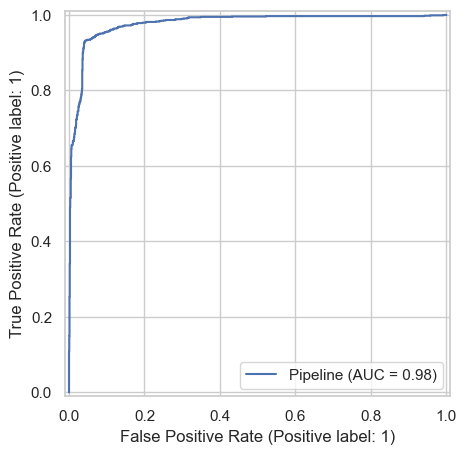

In [183]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print("AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:\n", cm)

RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()

In [184]:
clf = model.named_steps['classifier']
coef_df = pd.DataFrame({
    'Variable': num_cols + bool_cols,
    'Coeficiente': clf.coef_[0]
}).sort_values('Coeficiente', ascending=False)

print(coef_df)

                  Variable  Coeficiente
24    MesesDesdeUltimoPago     5.626372
25    MesesDesdePrimerPago     3.646782
101           TieneAccesos     0.404915
90          DiaFav_domingo     0.296894
97         EstFav_invierno     0.270151
..                     ...          ...
30         TotalAbono_AA12    -1.277858
2    MesesDesdeUltimoAbono    -1.852333
14         NumRenovaciones    -2.196260
22       RatioMesesPagados    -2.196260
89              TienePagos    -2.566956

[102 rows x 2 columns]


In [ ]:
# ============================================================
# 📦 1. Librerías
# ============================================================
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import time

# ============================================================
# 🧹 2. Preparación de datos
# ============================================================

# Ejemplo: suponemos que df tiene todas las variables limpias
# y la columna objetivo es 'Churn'
# (ajusta nombres si son distintos)
X = df.drop(columns=['Churn', 'TipoUltimoAbono', 'TipoAbonoInicial',
 'TipoAbonoFinal','TipoAbonoFrecuente', 'FormaPagoMayoritaria',     "Irregularidad_BajaFinalRegular", 'Irregularidad_BajaFinalRegular','Irregularidad_ActivoIrregular',
 'Irregularidad_ActivoRegular'])
y = df['Churn']

# Evita data leakage (quita columnas con info futura si las hay)
# leak_vars = ['MesesDesdeUltimoAbono', 'MesesDesdeUltimoPago']
# X = X.drop(columns=leak_vars, errors='ignore')

# Dividir dataset (estratificado)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ============================================================
# ⚙️ 3. Escalado (solo para modelos que lo necesitan)
# ============================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ============================================================
# 🤖 4. Modelos
# ============================================================
modelos = {
    "Regresión Logística": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

# ============================================================
# 🧠 5. Entrenamiento y evaluación
# ============================================================
resultados = []

for nombre, modelo in modelos.items():
    inicio = time.time()

    # Escalar solo los modelos que lo necesitan
    if nombre in ["Regresión Logística", "SVM", "KNN"]:
        modelo.fit(X_train_scaled, y_train)
        y_pred = modelo.predict(X_test_scaled)
        y_prob = modelo.predict_proba(X_test_scaled)[:, 1]
    else:
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
        y_prob = modelo.predict_proba(X_test)[:, 1]

    fin = time.time()

    auc = roc_auc_score(y_test, y_prob)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    resultados.append({
        "Modelo": nombre,
        "Accuracy": acc,
        "F1": f1,
        "AUC": auc,
        "Tiempo (s)": round(fin - inicio, 2)
    })

# ============================================================
# 📊 6. Resultados comparativos
# ============================================================
df_resultados = pd.DataFrame(resultados).sort_values(by="AUC", ascending=False)
df_resultados


,Modelo,Accuracy,F1,AUC,Tiempo (s)
2,Gradient Boosting,0.973716,0.966589,0.996240,13.41
1,Random Forest,0.970049,0.961927,0.995235,2.67
0,Regresión Logística,0.939487,0.922353,0.977804,0.20
3,SVM,0.923594,0.899275,0.968187,8.38
4,KNN,0.872249,0.833995,0.917039,0.12


In [20]:
corr_target = df.corr(numeric_only=True)['Churn'].sort_values(ascending=False)
print(corr_target.tail(60))

DuracionStdTotal                              -0.112043
EstFav_primavera                              -0.116723
NumCambiosAbono                               -0.118164
StdDiasEntreVisitas                           -0.120792
MediaPagada                                   -0.129312
PropVisitasLargas                             -0.144682
HoraMediaAcceso                               -0.157979
PropPrimavera                                 -0.158910
VisitasRed7a20                                -0.160667
TotalAbono_AG00                               -0.167903
VisitasFestivos                               -0.172103
VarVisitasMes                                 -0.180915
MesesDesdePrimerPago                          -0.181860
TieneAccesos                                  -0.187607
MaxRachaSinVisita                             -0.191154
VisitasUlt30                                  -0.195745
VisitasRed9a14                                -0.200876
VisitasPrimerTrimestre                        -0

In [26]:
# Calcular correlación absoluta
corr_target = df.corr(numeric_only=True)['Churn'].abs().sort_values(ascending=False)

# Detectar leakage
cols_leakage = corr_target[corr_target > 0.9].index.tolist()

# Detectar columnas sin correlación (NaN o constantes)
cols_nan = [col for col in df.columns if df[col].nunique() <= 1 or df[col].isna().all()]
cols_nan

['Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS)',
 "Concepto_FISIO ABONAMENT 5 SESSIONS  60'  ",
 'Concepto_NUTRI ANTROPOMETRIA',
 'TotalAbono_AP00',
 'TotalAbono_AVET',
 'TotalAbono_EMPF',
 'TotalAbono_FA12',
 'TotalAbono_TEMP',
 'TotalAbono_VIP',
 'VisitasRed7a15',
 'PropVisitasRed7a15']

In [32]:
cols_leakage

['Churn', 'Irregularidad_BajaFinalRegular']

In [27]:
# Combinar listas de exclusión
cols_excluir = list(set(cols_leakage + cols_nan))

print("🔴 Variables eliminadas por leakage o NaN:", cols_excluir)

🔴 Variables eliminadas por leakage o NaN: ['Churn', 'VisitasRed7a15', 'TotalAbono_AP00', 'TotalAbono_AVET', 'Concepto_NUTRI ANTROPOMETRIA', 'TotalAbono_FA12', 'Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS)', "Concepto_FISIO ABONAMENT 5 SESSIONS  60'  ", 'TotalAbono_TEMP', 'TotalAbono_EMPF', 'TotalAbono_VIP', 'PropVisitasRed7a15', 'Irregularidad_BajaFinalRegular']


In [28]:
# Crear dataset limpio
X = df.drop(columns=['Churn','TipoUltimoAbono', 'TipoAbonoInicial',
 'TipoAbonoFinal','TipoAbonoFrecuente', 'FormaPagoMayoritaria','Irregularidad_BajaFinalIrregular',
 'Irregularidad_ActivoIrregular', 'Irregularidad_ActivoRegular', 'MesesDesdeUltimoPago',
 'RatioMesesPagados','NumRenovaciones', 'DuracionRenovacionMeses'] + cols_excluir, errors='ignore')
y = df['Churn']

In [31]:
import os
import joblib


SEED = 42
np.random.seed(SEED)

# ML libs
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_score,
    brier_score_loss, confusion_matrix, f1_score, recall_score
)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# imbalanced
from imblearn.over_sampling import SMOTE

# LightGBM
import lightgbm as lgb

# SHAP
import shap

# ============================================================
# 📦 1. Librerías
# ============================================================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import time

In [32]:
# Dividir dataset (estratificado)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

# ============================================================
# ⚙️ 3. Escalado (solo para modelos que lo necesitan)
# ============================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ============================================================
# 🤖 4. Modelos
# ============================================================
modelos = {
    "Regresión Logística": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

# ============================================================
# 🧠 5. Entrenamiento y evaluación
# ============================================================
resultados = []

for nombre, modelo in modelos.items():
    inicio = time.time()

    # Escalar solo los modelos que lo necesitan
    if nombre in ["Regresión Logística", "SVM", "KNN"]:
        modelo.fit(X_train_scaled, y_train)
        y_pred = modelo.predict(X_test_scaled)
        y_prob = modelo.predict_proba(X_test_scaled)[:, 1]
    else:
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
        y_prob = modelo.predict_proba(X_test)[:, 1]

    fin = time.time()

    auc = roc_auc_score(y_test, y_prob)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    resultados.append({
        "Modelo": nombre,
        "Accuracy": acc,
        "F1": f1,
        "AUC": auc,
        "Tiempo (s)": round(fin - inicio, 2)
    })

# ============================================================
# 📊 6. Resultados comparativos
# ============================================================
df_resultados = pd.DataFrame(resultados).sort_values(by="AUC", ascending=False)
df_resultados

,Modelo,Accuracy,F1,AUC,Tiempo (s)
2,Gradient Boosting,0.927262,0.907823,0.983361,13.25
1,Random Forest,0.911980,0.883871,0.973186,3.32
3,SVM,0.874694,0.836131,0.932849,9.91
0,Regresión Logística,0.868582,0.831373,0.932458,0.20
4,KNN,0.834352,0.787451,0.884804,2.26


In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

param_grids = {
    "Regresión Logística": {
        "C": [0.01, 0.1, 1, 10],
        "penalty": ["l2"],
        "solver": ["lbfgs"]
    },
    "Random Forest": {
        "n_estimators": [100, 200],
        "max_depth": [None, 5, 10],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2]
    },
    "Gradient Boosting": {
        "n_estimators": [100, 200],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [2, 3, 4],
        "subsample": [0.8, 1.0]
    },
    "SVM": {
        "C": [0.1, 1, 10],
        "kernel": ["rbf", "poly"],
        "gamma": ["scale", "auto"]
    },
    "KNN": {
        "n_neighbors": [3, 5, 7, 9],
        "weights": ["uniform", "distance"]
    }
}

In [34]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
import pandas as pd
import time

modelos = {
    "Regresión Logística": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier()
}

resultados = []

for nombre, modelo in modelos.items():
    print(f"\n🔍 Optimizando {nombre}...")
    start = time.time()
    grid = GridSearchCV(
        estimator=modelo,
        param_grid=param_grids[nombre],
        scoring='roc_auc',
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train_scaled, y_train)
    tiempo = time.time() - start

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    y_prob = best_model.predict_proba(X_test_scaled)[:, 1]

    resultados.append({
        "Modelo": nombre,
        "Mejores Parámetros": grid.best_params_,
        "AUC": roc_auc_score(y_test, y_prob),
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "Tiempo (s)": round(tiempo, 2)
    })

df_resultados = pd.DataFrame(resultados).sort_values(by="AUC", ascending=False)
print("\n📈 Resultados finales:")
print(df_resultados)


🔍 Optimizando Regresión Logística...
Fitting 5 folds for each of 4 candidates, totalling 20 fits

🔍 Optimizando Random Forest...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

🔍 Optimizando Gradient Boosting...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

🔍 Optimizando SVM...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

🔍 Optimizando KNN...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

📈 Resultados finales:
                Modelo                                 Mejores Parámetros  \
2    Gradient Boosting  {'learning_rate': 0.1, 'max_depth': 4, 'n_esti...   
1        Random Forest  {'max_depth': None, 'min_samples_leaf': 1, 'mi...   
3                  SVM        {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}   
0  Regresión Logística      {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}   
4                  KNN          {'n_neighbors': 9, 'weights': 'distance'}   

        AUC  Accuracy        F1  Tiempo (s)  
2  0.989130  

In [37]:
df_resultados['Mejores Parámetros'][2]

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.8}

In [38]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np

model = GradientBoostingClassifier(
    n_estimators=200, learning_rate=0.1, max_depth=4, subsample=0.8, random_state=42
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='roc_auc')

print(f"AUC medio (CV): {np.mean(scores):.4f} ± {np.std(scores):.4f}")

AUC medio (CV): 0.9821 ± 0.0036


✔️ No hay data leakage (porque el AUC ya no es 1.0 perfecto)

✔️ El modelo generaliza bien

✔️ Los resultados que obtuviste en X_test (≈0.983) son consistentes con la validación cruzada

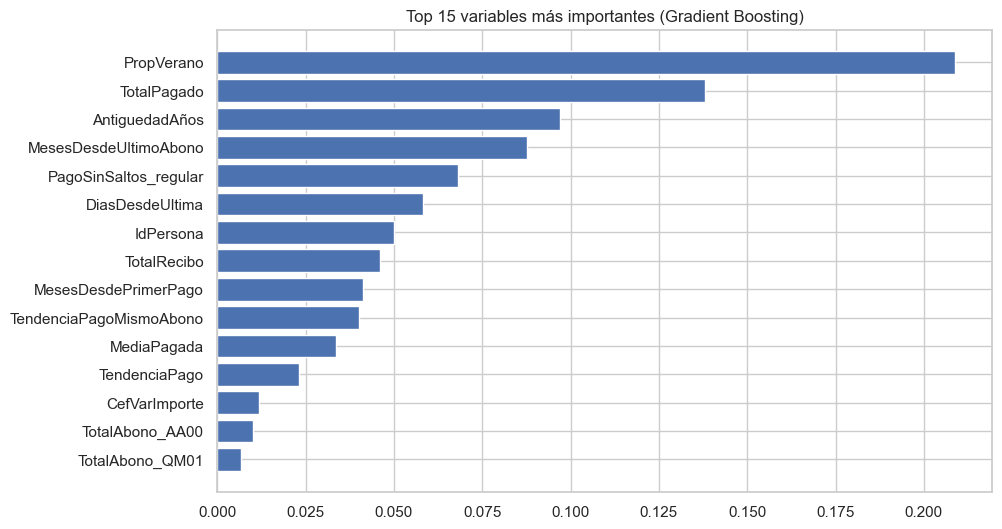

In [81]:
# Entrenamiento final en todo el dataset (ya escalado)
X_full_scaled = scaler.fit_transform(X)
y_full = y

final_model = GradientBoostingClassifier(
    n_estimators=200, learning_rate=0.1, max_depth=4, subsample=0.8, random_state=42
)
final_model.fit(X_full_scaled, y_full)

# Importancia de variables
import pandas as pd
import matplotlib.pyplot as plt

importances = pd.DataFrame({
    'Variable': X.columns,
    'Importancia': final_model.feature_importances_
}).sort_values(by='Importancia', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(importances['Variable'][:15], importances['Importancia'][:15])
plt.gca().invert_yaxis()
plt.title("Top 15 variables más importantes (Gradient Boosting)")
plt.show()

In [29]:
df_temporal= df.copy()

In [30]:
df_temporal

,IdPersona,Edad,Sexo_Mujer,Churn,AntiguedadAños,TipoUltimoAbono,Irregularidad_ActivoIrregular,Irregularidad_ActivoRegular,Irregularidad_BajaFinalIrregular,Irregularidad_BajaFinalRegular,MesesDesdeUltimoAbono,Importe_2024_servicios,Cantidad_2024_servicios,Importe_2025_servicios,Cantidad_2025_servicios,Importe_total_pagado_servicios,Cantidad_total_pagado_servicios,Concepto_ENTRENADOR PERSONAL 1 /2 SESSIO ABONAT,Concepto_ENTRENADOR PERSONAL 1 SESSIO,Concepto_ENTRENADOR PERSONAL 1 SESSIÓ ABONAT,Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS),Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS) ABONAT,Concepto_ENTRENADOR PERSONAL 10 SESSIONS ABONAT,Concepto_ENTRENADOR PERSONAL 5 (30 MINUTS) ABONAT,Concepto_ENTRENADOR PERSONAL 5 SESSIONS ABONAT,Concepto_FISIO ABONAMENT 10 SESSIONS 60' ABONAT,Concepto_FISIO ABONAMENT 5 SESSIONS 30' ABONAT,Concepto_FISIO ABONAMENT 5 SESSIONS 60',Concepto_FISIO PACK BENVINGUDA,Concepto_FISIOTERÀPIA 60' ABONAT,Concepto_FISIOTERÀPIA 30' ABONAT,Concepto_NUTRI ANTROPOMETRIA,Concepto_NUTRI ANTROPOMETRIA ABONAT,Concepto_NUTRI PACK 3 SEGUIMENTS ABONAT,Concepto_NUTRI VISITA DE SEGUIMENT ABONAT,Concepto_PACK 3 SEGUIMENTS ABONAT,Concepto_PACK NUTRICIÓ (2 VISITES) ABONAT,TipoServicio_ENTRENAMENTS PERSONALS,TipoServicio_FISIOTERÀPIA,TipoServicio_NUTRICIÓ,Total_conceptos_unicos,Total_tipos_servicios_unicos,UsoServiciosExtra,NumRenovaciones,NumTiposAbono,TotalPagado,MediaPagada,TotalMetálico,TotalRecibo,TotalTarjeta,TotalTransferencia,CambioAbono,RatioMesesPagados,CefVarImporte,MesesDesdeUltimoPago,MesesDesdePrimerPago,DuracionRenovacionMeses,FormaPagoMayoritaria,TipoAbonoInicial,TipoAbonoFinal,TotalAbono_AA0,TotalAbono_AA00,TotalAbono_AA03,TotalAbono_AA12,TotalAbono_AC00,TotalAbono_AC03,TotalAbono_AF00,TotalAbono_AF03,TotalAbono_AG00,TotalAbono_AG03,TotalAbono_AG12,TotalAbono_AM00,TotalAbono_AM03,TotalAbono_AP00,TotalAbono_AP03,TotalAbono_AR00,TotalAbono_AR03,TotalAbono_AR12,TotalAbono_AT00,TotalAbono_AT01,TotalAbono_AVET,TotalAbono_CL04,TotalAbono_CR01,TotalAbono_CR03,TotalAbono_EMPF,TotalAbono_FA00,TotalAbono_FA12,TotalAbono_FM01,TotalAbono_JO00,TotalAbono_JO03,TotalAbono_MA00,TotalAbono_MA03,TotalAbono_MA06,TotalAbono_MA12,TotalAbono_NI00,TotalAbono_QM01,TotalAbono_QM03,TotalAbono_TEMP,TotalAbono_VIP,TipoAbonoFrecuente,NumCambiosAbono,TendenciaPago,TendenciaPagoMismoAbono,NumImpagosReales,NumReactivaciones,TienePagos,PagoSinSaltos_irregular,PagoSinSaltos_no_aplica,PagoSinSaltos_regular,TotalVisitas,DiasActivo,VisitasPorSemana,VisitasPorMes,MaxVisitasDia,VarVisitasMes,DuracionMediaTotal,DuracionStdTotal,DuracionMediaUlt90,DeltaDuracionUlt90VsTotal,PropVisitasLargas,VisitasUlt30,VisitasUlt90,VisitasUlt180,PropUlt90,DiasDesdeUltima,DiasHastaPrimera,StdDiasEntreVisitas,FrecuenciaModal,SemanasConVisita,SemanasTotales,SemanasConUnaVisita,MaxRachaSinVisita,MaxRachaConVisita,HoraMediaAcceso,HoraStdAcceso,VarDiasSemana,PropFindesemana,PropPrimavera,PropVerano,PropOtono,PropInvierno,VisitasFestivos,PropVisitasFestivos,VisitasFindesemana,PropVisitasFindesemana,VisitasCerrado,PropVisitasCerrado,VisitasRed9a14,PropVisitasRed9a14,VisitasRed7a20,PropVisitasRed7a20,VisitasRed7a15,PropVisitasRed7a15,TiempoActivoDias,VisitasPrimerTrimestre,VisitasUltimoTrimestre,DiaFav_domingo,DiaFav_jueves,DiaFav_lunes,DiaFav_martes,DiaFav_miércoles,DiaFav_sábado,DiaFav_viernes,EstFav_invierno,EstFav_otono,EstFav_primavera,EstFav_verano,TieneAccesos
0,334,82.0,False,0,69.81,AVET,True,False,False,False,175.9,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,False,2.0,1.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.166667,0.0,1.0,7.0,5.946124,Metálico,AVET,AVET,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AVET,0.0,0.0,0.0,1.0,0.0,True,True,False,False,3.0,3.0,1.500000,2.432432,1.0,0.00,50.422222,8.675597,50.422222,0.0,0.333333,3.0,3.0,3.0,1.0,383.0,

⚠️ Posibles columnas con fuga temporal: ['Irregularidad_ActivoIrregular', 'Irregularidad_ActivoRegular', 'Irregularidad_BajaFinalIrregular', 'Irregularidad_BajaFinalRegular', 'MesesDesdeUltimoAbono', 'Importe_2025_servicios', 'Cantidad_2025_servicios', 'NumRenovaciones', 'MesesDesdeUltimoPago', 'DuracionRenovacionMeses', 'DuracionMediaTotal', 'DuracionStdTotal', 'DuracionMediaUlt90', 'DeltaDuracionUlt90VsTotal']

--- Entrenando modelos base ---
LogReg: AUC=0.974 | F1=0.920 | Acc=0.937
KNN: AUC=0.901 | F1=0.804 | Acc=0.850
SVM: AUC=0.956 | F1=0.870 | Acc=0.899
RF: AUC=0.981 | F1=0.900 | Acc=0.924
GB: AUC=0.993 | F1=0.946 | Acc=0.958

Resultados iniciales:
    Modelo       AUC        F1  Accuracy
4      GB  0.992614  0.945967  0.957824
3      RF  0.980818  0.900161  0.924205
0  LogReg  0.974465  0.919969  0.937042
2     SVM  0.956011  0.869771  0.899144
1     KNN  0.900655  0.804157  0.850244

--- Optimizando Gradient Boosting ---
Fitting 5 folds for each of 10 candidates, totalling 50 f

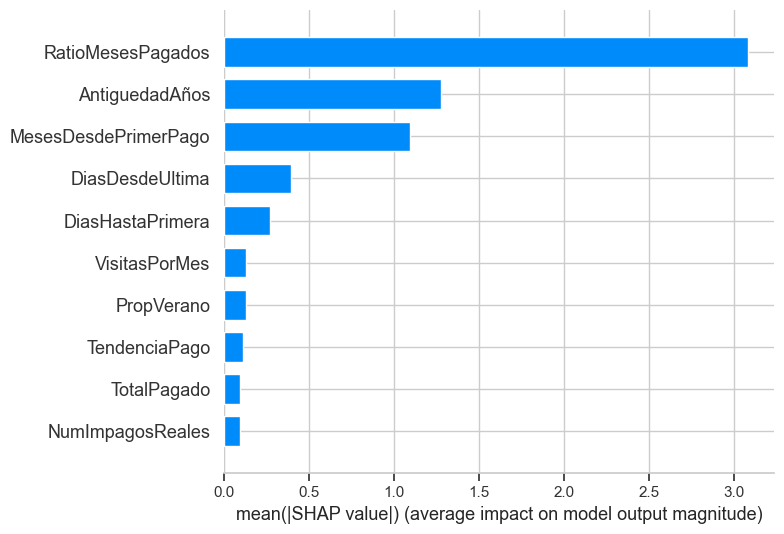

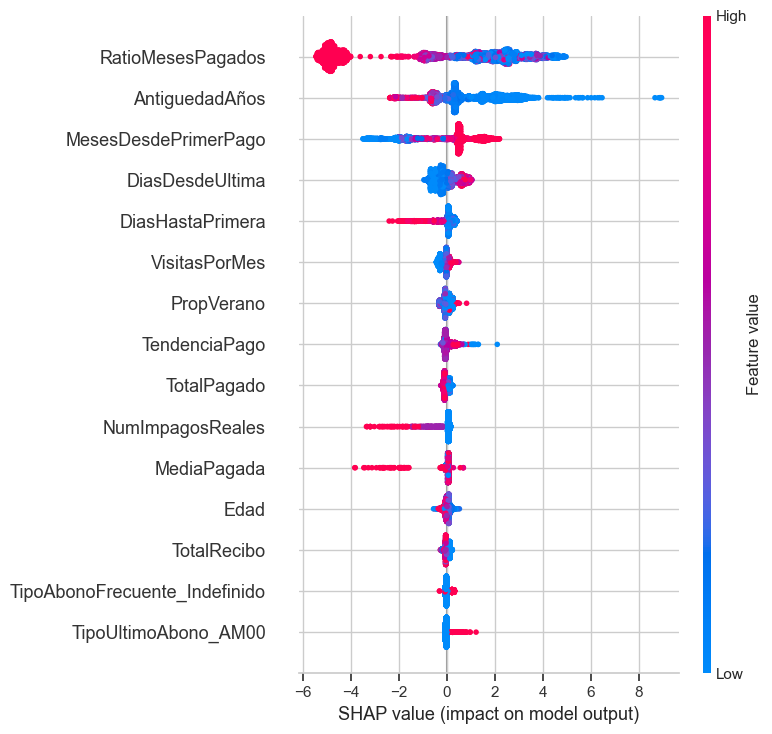


Top factores que más explican el churn:

                  Feature  Mean_SHAP
38      RatioMesesPagados   3.080581
2          AntiguedadAños   1.278487
40   MesesDesdePrimerPago   1.095307
94        DiasDesdeUltima   0.394417
95       DiasHastaPrimera   0.270680
86          VisitasPorMes   0.130066
108            PropVerano   0.130040
75          TendenciaPago   0.116077
31            TotalPagado   0.097995
77       NumImpagosReales   0.095748


In [31]:
# ============================================================
# 🧠 PREDICCIÓN DE CHURN – PIPELINE MEJORADO Y EXPLICABLE
# ============================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import shap
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# ============================================================
# 1️⃣ CARGA Y PREPARACIÓN DE DATOS
# ============================================================


# --- 1.1. Eliminamos columnas vacías o constantes
df_temporal = df_temporal.dropna(axis=1, how="all")
constant_cols = [c for c in df_temporal.columns if df_temporal[c].nunique() <= 1]
df_temporal = df_temporal.drop(columns=constant_cols)

# --- 1.2. Eliminamos identificadores
drop_cols = ['IdPersona']  # ajusta según tus datos
df_temporal = df_temporal.drop(columns=[c for c in drop_cols if c in df_temporal.columns])

# --- 1.3. Detectamos columnas con riesgo de fuga temporal
suspect_words = ["_2025", "2025_", "desdeUltimo", "UltimoPago", "Duracion", "Renovacion", 'Irregularidad']
leak_cols = [c for c in df_temporal.columns if any(w.lower() in c.lower() for w in suspect_words)]
print(f"⚠️ Posibles columnas con fuga temporal: {leak_cols}")

# Las quitamos de momento (revisa si deben quedarse)
df_temporal = df_temporal.drop(columns=leak_cols)

# --- 1.4. Variables categóricas → one-hot encoding
df_temporal = pd.get_dummies(df_temporal, drop_first=True)

# --- 1.5. Target y features
y = df_temporal["Churn"]
X = df_temporal.drop(columns=["Churn"])

# ============================================================
# 2️⃣ SPLIT Y ESCALADO
# ============================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ============================================================
# 3️⃣ MODELOS BASE
# ============================================================

models = {
    "LogReg": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(probability=True, class_weight='balanced'),
    "RF": RandomForestClassifier(class_weight='balanced', random_state=42),
    "GB": GradientBoostingClassifier(random_state=42)
}

results = []

print("\n--- Entrenando modelos base ---")
for name, model in models.items():
    if name in ["LogReg", "KNN", "SVM"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
    
    auc = roc_auc_score(y_test, y_prob)
    f1 = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    results.append((name, auc, f1, acc))
    print(f"{name}: AUC={auc:.3f} | F1={f1:.3f} | Acc={acc:.3f}")

results_df = pd.DataFrame(results, columns=["Modelo", "AUC", "F1", "Accuracy"])
print("\nResultados iniciales:\n", results_df.sort_values(by="AUC", ascending=False))

# ============================================================
# 4️⃣ VALIDACIÓN CRUZADA Y OPTIMIZACIÓN
# ============================================================

print("\n--- Optimizando Gradient Boosting ---")

param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.05, 0.1, 0.2],
    "max_depth": [2, 3, 4],
    "subsample": [0.8, 1.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gb = GradientBoostingClassifier(random_state=42)

search = RandomizedSearchCV(
    gb,
    param_distributions=param_grid,
    scoring="roc_auc",
    n_iter=10,
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

search.fit(X_train, y_train)
best_model = search.best_estimator_
print(f"Mejor modelo: {search.best_params_}")

# Validación cruzada final
cv_auc = cross_val_score(best_model, X_train, y_train, cv=cv, scoring="roc_auc")
print(f"AUC CV promedio: {cv_auc.mean():.3f} ± {cv_auc.std():.3f}")

# ============================================================
# 5️⃣ EVALUACIÓN FINAL
# ============================================================

y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print("\n--- Resultados finales ---")
print("AUC:", roc_auc_score(y_test, y_prob))
print("F1:", f1_score(y_test, y_pred))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

# ============================================================
# 6️⃣ INTERPRETABILIDAD (SHAP)
# ============================================================

print("\n--- Analizando importancia de variables ---")

# --- Paso 1: aseguramos que los datos sean numéricos (SHAP no acepta objetos)
X_train_shap = X_train.copy()
for col in X_train_shap.columns:
    if X_train_shap[col].dtype == "object":
        X_train_shap[col] = pd.to_numeric(X_train_shap[col], errors="coerce").fillna(0)

# --- Paso 2: elegimos el tipo de explicador adecuado
try:
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_train_shap)
    print("✅ Usando TreeExplainer (rápido y preciso para modelos tipo árbol).")
except Exception as e:
    print("⚠️ TreeExplainer falló, usando KernelExplainer (más lento pero universal).")
    # Usamos un muestreo de 200 observaciones para acelerar
    sample = X_train_shap.sample(200, random_state=42)
    explainer = shap.KernelExplainer(best_model.predict_proba, sample)
    shap_values = explainer.shap_values(sample, nsamples=100)

# --- Paso 3: convertimos los valores SHAP a matriz compatible
if isinstance(shap_values, list):  # Algunos modelos devuelven lista por clase
    shap_values = shap_values[1]  # clase positiva (churn)

# --- Paso 4: resumen gráfico
shap.summary_plot(shap_values, X_train_shap, plot_type="bar", max_display=10)
shap.summary_plot(shap_values, X_train_shap, max_display=15)

# --- Paso 5: ranking de importancia medio
importance = pd.DataFrame({
    "Feature": X_train_shap.columns,
    "Mean_SHAP": np.abs(shap_values).mean(axis=0)
}).sort_values(by="Mean_SHAP", ascending=False)

print("\nTop factores que más explican el churn:\n")
print(importance.head(10))


In [38]:
# --- 1️⃣ Creamos copia del dataset original
df_pred = df.copy()  # dataset original completo con IdPersona, Edad, Sexo, etc.

# --- 2️⃣ Preparamos features para predicción
X_all = df_pred.drop(columns=["Churn"])  # si Churn está en df
# Si hiciste one-hot encoding en entrenamiento, asegurarte de usar las mismas columnas
X_all_encoded = pd.get_dummies(X_all, drop_first=True)

# Añadimos columnas que falten (si alguna categoría no estaba en el train)
for col in X_train.columns:
    if col not in X_all_encoded.columns:
        X_all_encoded[col] = 0
X_all_encoded = X_all_encoded[X_train.columns]  # orden correcto de columnas

# --- 3️⃣ Predicción con Gradient Boosting (best_model)
y_prob_all = best_model.predict_proba(X_all_encoded)[:, 1]
y_pred_all = best_model.predict(X_all_encoded)

# --- 4️⃣ Creamos dataframe de comparación con info relevante
df_comparison = df_pred[["IdPersona", "Edad", "Sexo_Mujer", "AntiguedadAños", "Churn"]].copy()
df_comparison["Churn_Pred"] = y_pred_all
df_comparison["Churn_Prob"] = y_prob_all

# --- 5️⃣ Revisamos primeras filas
print("\nPredicciones sobre todo el dataset:\n", df_comparison.head())

# --- 5️⃣ Métricas generales sobre todo el dataset
from sklearn.metrics import confusion_matrix

print("\nAccuracy:", accuracy_score(y_all, y_pred_all))
print("F1:", f1_score(y_all, y_pred_all))
print("AUC:", roc_auc_score(y_all, y_prob_all))
print("\nConfusion matrix:\n", confusion_matrix(y_all, y_pred_all))


Predicciones sobre todo el dataset:
    IdPersona  Edad  Sexo_Mujer  AntiguedadAños  Churn  Churn_Pred  Churn_Prob
0        334  82.0       False           69.81      0           0    0.162648
1        452  85.0       False           69.00      0           0    0.015559
2        642  77.0       False           67.54      0           0    0.015559
3        849  85.0       False           67.12      0           0    0.224948
4        891  78.0       False           66.70      0           0    0.015559

Accuracy: 0.9859344422700587
F1: 0.9822008976938554
AUC: 0.9985594154483716

Confusion matrix:
 [[4888   44]
 [  71 3173]]


In [40]:
df_comparison

,IdPersona,Edad,Sexo_Mujer,AntiguedadAños,Churn,Churn_Pred,Churn_Prob
0,334,82.0,False,69.81,0,0,0.162648
1,452,85.0,False,69.00,0,0,0.015559
2,642,77.0,False,67.54,0,0,0.015559
3,849,85.0,False,67.12,0,0,0.224948
4,891,78.0,False,66.70,0,0,0.015559
...,...,...,...,...,...,...,...
8180,116944,11.0,True,1.10,1,1,0.955518
8181,116981,17.0,False,0.09,1,1,0.964966
8182,116987,23.0,False,0.08,1,1,0.960883
8183,116996,17.0,False,1.00,1,1,0.983346


In [42]:
df_comparison[df_comparison['Churn'] != df_comparison['Churn_Pred']]

,IdPersona,Edad,Sexo_Mujer,AntiguedadAños,Churn,Churn_Pred,Churn_Prob
77,13268,58.0,True,41.24,0,1,0.641792
86,14254,74.0,True,39.69,0,1,0.554966
345,29537,74.0,True,17.94,0,1,0.635971
481,31502,20.0,False,1.80,0,1,0.943452
523,32429,18.0,True,3.41,0,1,0.936362
...,...,...,...,...,...,...,...
7956,117348,36.0,False,0.00,1,0,0.135201
7957,117352,50.0,True,0.01,1,0,0.250139
7958,117370,73.0,True,0.00,1,0,0.495874
7959,117421,26.0,True,0.00,1,0,0.378960


In [45]:
# --- 1️⃣ Definir los rangos de probabilidad
bins = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]  # puedes ajustar según distribución
labels = ["Muy bajo", "Bajo", "Medio", "Alto", "Muy alto"]

# --- 2️⃣ Crear nueva columna con rango de churn
df_comparison["Churn_Rango"] = pd.cut(df_comparison["Churn_Prob"], bins=bins, labels=labels, include_lowest=True)

# --- 3️⃣ Revisar resultados
print(df_comparison[["IdPersona", "Churn_Prob", "Churn_Rango"]].head(20))

    IdPersona  Churn_Prob Churn_Rango
0         334    0.162648    Muy bajo
1         452    0.015559    Muy bajo
2         642    0.015559    Muy bajo
3         849    0.224948        Bajo
4         891    0.015559    Muy bajo
5        1047    0.015559    Muy bajo
6        1715    0.015559    Muy bajo
7        1836    0.015559    Muy bajo
8        2476    0.003046    Muy bajo
9        3461    0.003718    Muy bajo
10       3593    0.002515    Muy bajo
11       3774    0.015559    Muy bajo
12       4016    0.016206    Muy bajo
13       4525    0.007730    Muy bajo
14       5130    0.003543    Muy bajo
15       5374    0.004334    Muy bajo
16       5753    0.089470    Muy bajo
17       5754    0.012863    Muy bajo
18       5767    0.015559    Muy bajo
19       5818    0.143460    Muy bajo


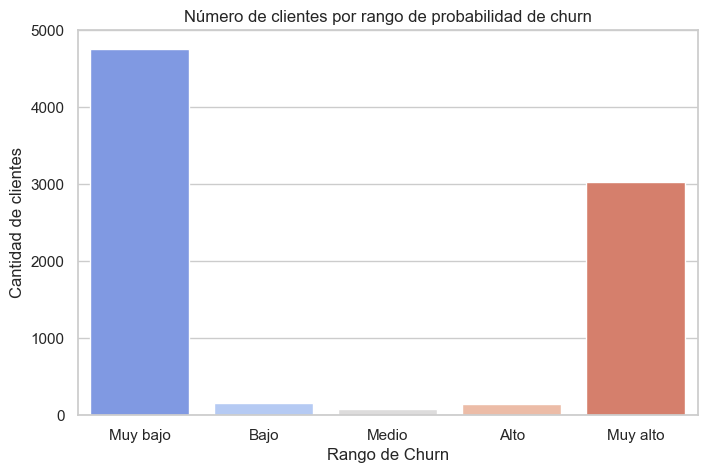

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración estética
sns.set_style("whitegrid")

# Conteo de clientes por rango
plt.figure(figsize=(8,5))
sns.countplot(x="Churn_Rango", data=df_comparison, order=["Muy bajo","Bajo","Medio","Alto","Muy alto"], palette="coolwarm")
plt.title("Número de clientes por rango de probabilidad de churn")
plt.xlabel("Rango de Churn")
plt.ylabel("Cantidad de clientes")
plt.show()

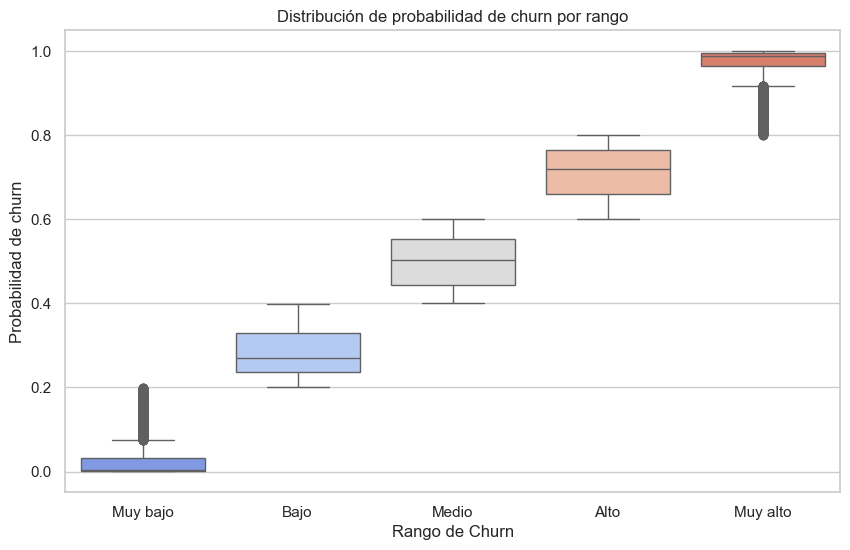

In [47]:
plt.figure(figsize=(10,6))
sns.boxplot(x="Churn_Rango", y="Churn_Prob", data=df_comparison, order=["Muy bajo","Bajo","Medio","Alto","Muy alto"], palette="coolwarm")
plt.title("Distribución de probabilidad de churn por rango")
plt.xlabel("Rango de Churn")
plt.ylabel("Probabilidad de churn")
plt.show()

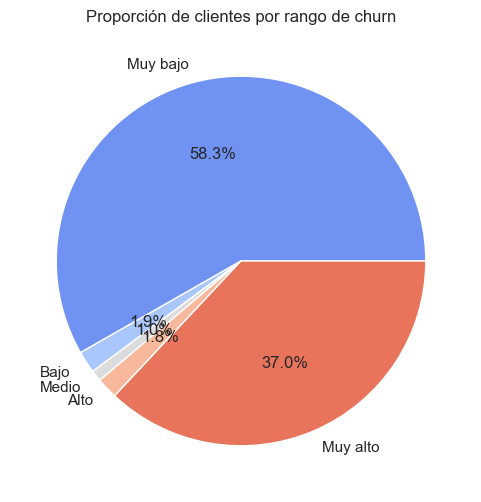

In [48]:
df_comparison["Churn_Rango"].value_counts().reindex(["Muy bajo","Bajo","Medio","Alto","Muy alto"]).plot(
    kind="pie", autopct="%1.1f%%", figsize=(6,6), colors=sns.color_palette("coolwarm", 5)
)
plt.ylabel("")
plt.title("Proporción de clientes por rango de churn")
plt.show()

In [51]:
df_comparison[df_comparison['Churn_Rango'] == 'Bajo'		]  # reemplaza 12345 por el IdPersona que quieras revisar

,IdPersona,Edad,Sexo_Mujer,AntiguedadAños,Churn,Churn_Pred,Churn_Prob,Churn_Rango
3,849,85.0,False,67.12,0,0,0.224948,Bajo
130,17383,71.0,True,35.24,0,0,0.354742,Bajo
252,26764,62.0,True,22.52,0,0,0.266429,Bajo
300,28507,54.0,False,19.32,0,0,0.383943,Bajo
458,31199,16.0,False,0.10,0,0,0.285052,Bajo
...,...,...,...,...,...,...,...,...
7862,116904,15.0,False,0.00,1,0,0.253647,Bajo
7872,116932,10.0,True,0.00,1,0,0.340181,Bajo
7957,117352,50.0,True,0.01,1,0,0.250139,Bajo
7959,117421,26.0,True,0.00,1,0,0.378960,Bajo
